# Datenauswerter
#### Dieses Dokument ist zur Auswertung der Online Daten von Pavlovia geschaffen. Im Prinzip werden die CSV Dateien der Probanden und Probandinnen eingelesen, verarbeitet und die resultierenden Daten konsolidiert. Später wird dieses Dokument auch die Vanianzanalyse durchführen.

In [1]:
from os import listdir
from PIL import Image, ImageOps
from shutil import copy
import helperScript as hs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
imgsDictByCategory = hs.getFinalImgsByCategory(hs.finalImagesFolderPath)
allImgs = []
for key in imgsDictByCategory.keys():
    for img in imgsDictByCategory[key]:
        allImgs.append(img)
imgsDict = dict()
for img in allImgs:
    imgsDict[img.expNameNoExt] = img

In [3]:
testImage = imgsDictByCategory['beach_invisiblesun_noclouds'][0]
testImage

In [4]:
def parseCsv(csvFileName, path='./data/'):
    csvFile = open(path + csvFileName, 'r')
    header = csvFile.readline()[:-1].split(',')
    data = dict()
    print('Header length:', len(header))
    
    #Initialize variable dict
#     fbclidIndex = None
    for variable, varCounter in zip(header, range(0,len(header))):
#         if (variable == 'fbclid'):
#             fbclidIndex = varCounter
        data[variable] = []
#     if fbclidIndex!= None:
    #                     print("DELETING fbclid in header with index", fbclidIndex)
    #             print("New header value at position", fbclidIndex, ":", header[fbclidIndex])
    #             print("New header length:", len(header))
#         del header[fbclidIndex]
#         del data['fbclid']
        
        
    data['imageName'] = []
    data['csvFileName'] = csvFileName
    data['path'] = path + csvFileName
    #Parse the lines
    lines = csvFile.readlines()
    
    for line, lineCounter in zip(lines, range(0,len(lines))):
        line = line[:-1]
        if '"' in line:
            quoteSplitLine = line.split('"')
            if (len(quoteSplitLine) == 3):
                #print(line.split('"'), len(line.split('"')))
                values1, client, values2 = quoteSplitLine
                values = values1.split(',')[:-1] + [client] + values2.split(',')[1:]  #Client contains , -> Breaks the split
            elif (len(quoteSplitLine) == 5):
                values1, client, values2, imgSize, values3 = quoteSplitLine
                values = values1.split(',')[:-1] + [client] + values2.split(',')[1:-1] + [imgSize] + values3.split(',')[1:]
            else:
                print("UNKNOWN CASE")
                print("LINE:",line)
                print('" SPLIT:', line.split('"'))
                print('LENGTH OF " SPLIT:',len(line.split('"')))
                print(', SPLIT:', line.split(','))
                print('LENGTH OF , SPLIT:', len(line.split(',')))
        else:
            values = line.split(',')
            
#         if (len(values)==52):
#             print("DELETING fbclid from values, index:", fbclidIndex, "value:", values[fbclidIndex])
#             del values[fbclidIndex]
#             print("New value of column", fbclidIndex, ":", values[fbclidIndex])
#             print("New length of values:", len(values))
        print("size of commaSplitLine:", len(values))
        
        for variable, i in zip(header, range(0,len(header))):
#             print("HEADER LENGTH:", len(header), "CURRENT POSITION:", i, "CURRENT VAR NAME:", variable, "=", values[i], data[variable])
#             if (len(values)==52):
#                 if (i == fbclidIndex):
#                     continue
            value = values[i]
            if (variable == 'rating_slider.response' and value!=''):
                data[variable].append(value)
            elif (variable == 'rating_slider.rt' and value!=''):
                data[variable].append(value)
            elif (variable == 'environment' and value!=''):
                data[variable].append(value)
            elif (variable == 'sunVisibility' and value!=''):
                data[variable].append(value)
            elif (variable == 'cloudVisibility' and value!=''):
                data[variable].append(value)
            elif (variable == 'imageId' and value!=''):
                data[variable].append(value)
            elif (not (value in data[variable]) and not (value=='')):
                data[variable].append(value)
            else:
                continue
            print(variable,"=",value)
        if(values[-6]!=''):
            imageName = '_'.join([data['environment'][-1], data['sunVisibility'][-1], data['cloudVisibility'][-1], data['imageId'][-1]])
            data['imageName'].append(imageName)
            print('imageName',"=",data['imageName'][-1])
        print(f"********** End of Line {lineCounter+1} **************")
    if (len(data['rating_slider.response']) != len(data['rating_slider.rt'])):
        print("Throwing exception next, here are some values:")
        print("File name:", csvFileName)
        print("Response Data:",data['rating_slider.response'])
        print("Response Time Data:", data['rating_slider.rt'])
        raise Exception(f"Parsing error, response len {len(data['rating_slider.response'])} and " + 
                        f"reaction time len {len(data['rating_slider.rt'])} are not the same.")
        print(data['rating_slider.response'])
        print(data['rating_slider.rt'])
        print(len(header))
        print(len(line.split(',')))
    for key, i in zip(data.keys(), range(0,len(data.keys()))):
        if (len(data[key])==1):
            data[key] = data[key][0]
        elif(len(data[key])==0 and (key=='email' or key=='cancel_reasons')):
            data[key] = None
            print("Setting",key,"to None")
        elif (len(data[key])==0):
            raise Exception(f"Parsing error, data[{key}] = {data[key]}")
    csvFile.close()
    return data
    

In [5]:
def validateDataFile(df):
    valid = True
    
    dtype = type(df)
    if (dtype!=type(dict())):
        print("dtype =",dtype)
        valid=False
    
    attrAmount = len(df.keys())
    if (attrAmount<54 or attrAmount > 55):
        print("attrAmount =", attrAmount)
        valid=False
    
    sliderResponseAmount = len(df['rating_slider.response'])
    if(sliderResponseAmount!=80):
        print("sliderResponseAmount =", sliderResponseAmount)
        valid=False

    sliderRtAmount = len(df['rating_slider.rt'])
    if(sliderRtAmount!=80):
        print("sliderRtAmount =", sliderRtAmount)
        valid=False
    
    if (valid == False):
        print("INVALID DATA FILE")
        print("DATA FILE:", df)
    
    return valid

In [6]:
class Person:
    def __init__(self, csvFileDict):
        self.fileName = csvFileDict['csvFileName']
        self.filePath = csvFileDict['path']
        flagClick = csvFileDict['language_mouse.clicked_name']
        if flagClick == 'gr_flag':
            self.language = 'gr'
        elif flagClick == 'de_flag':
            self.language = 'de'
        else:
            print("INVALID LANGUAGE FLAG CLICK:", flagClick)
        self.nationality = csvFileDict['nationality']
        self.mother_tongue = csvFileDict['mother_tongue']
        self.homeland = csvFileDict['homeland']
        self.gender = csvFileDict['gender']
        self.age = int(csvFileDict['age'])
        self.email = csvFileDict['email']
        self.imageNames = csvFileDict['imageName']
        self.ratings = [int(rating) for rating in csvFileDict['rating_slider.response']]
        self.ratingResponseTimes = [float(responseTime) for responseTime in csvFileDict['rating_slider.rt']]
        self.time = float(csvFileDict['globalClockTime'])
        self.ratingDict = dict()
        self.ratingsByCategoryDict = dict()
        for category in imgsDictByCategory.keys():
            self.ratingsByCategoryDict[category] = []
        for imName, imRating in zip(self.imageNames, self.ratings):
            imCat = '_'.join(imName.split('_')[:-1])
            self.ratingDict[imName] = imRating
            self.ratingsByCategoryDict[imCat].append(imRating)
            
    
    def getAverage(self):
        return np.average(self.ratings)
    
    def getMax(self):
        return np.max(self.ratings)
    
    def getMin(self):
        return np.min(self.ratings)
    
    def getMinMax(self):
        return (min(self.ratings), max(self.ratings))
    
    def getVariance(self):
        return np.var(self.ratings)
    
    def getStd(self):
        return np.std(self.ratings)
    
    def getAverageResponseTime(self):
        return np.average(self.ratingResponseTimes)
    
    def getTime(self):
        return self.time
    
    def getRatingForImage(imageName):
        for i, imName in enumerate(self.imageNames):
            if imName == imageName:
                return self.ratings[i]
            
    def getRatingDict(self):
        return self.ratingDict
    
    def getRatingsByCategoryDict(self):
        return self.ratingsByCategoryDict
    
    def getCategoryStatsDict(self):
        if (hasattr(self, 'categoryStatsDict') == False):
            self.categoryStatsDict = dict()
            for category in self.ratingsByCategoryDict.keys():
                category_entry = dict()
                ratings = self.ratingsByCategoryDict[category]
                category_entry['average'] = np.average(ratings)
                category_entry['variance'] = np.var(ratings)
                category_entry['std'] = np.std(ratings)
                self.categoryStatsDict[category] = category_entry
        return self.categoryStatsDict
    
    def getFavoriteCategory(self):
        categoryDict = self.getCategoryStatsDict()
        res = ''
        currMax = 0
        for category in categoryDict.keys():
            currAvg = categoryDict[category]['average']
            if currAvg > currMax:
                currMax = currAvg
                res = category
            else:
                continue
        return res, currMax
    
    def getStatsDict(self):
        if (hasattr(self, 'statsDict') == False):
            self.statsDict = dict()
            self.statsDict['average_rating'] = self.getAverage()
            self.statsDict['variance_of_ratings'] = self.getVariance()
            self.statsDict['std_of_ratings'] = self.getStd()
            self.statsDict['average_response_time'] = self.getAverageResponseTime()
            self.statsDict['total_time_s'] = self.getTime()
            self.statsDict['total_time_min'] = self.getTime()/60
            self.statsDict['min_rating'] = self.getMin()
            self.statsDict['max_rating'] = self.getMax()
        return self.statsDict
    
    
    def getAllStats(self):
        return self.getCategoryStatsDict(), self.getFavoriteCategory(), self.getStatsDict()
    
    def printAllStats(self):
        toPrint = self.getAllStats()
        faveCatTuple = toPrint[1]
        faveCat = faveCatTuple[0]
        faveCatAvg = faveCatTuple[1]
        
        generalStats = toPrint[2]
        
        statsByCat = toPrint[0]
        
        print("Favorite category:", toPrint[1][0])
        print("   with average score:", toPrint[1][1])
        print("General statistics:")
        for key in generalStats.keys():
            print(f"   {key:21}: {generalStats[key]:7.3f}")
        print("Stats by category:")
        for cat in statsByCat:
            print(f"   {cat:32}: {statsByCat[cat]}")
            
#             print(" "*37 + f"{statsByCat[cat]}")
        

In [7]:
def extractPersonRatings(person,imageDict):
    if len(person.ratings) != len(person.imageNames) and len(person.ratings) != len(person.ratingResponseTimes):
        print("UNEVEN RATINGS-IMAGENAMES")
        return
    homeland = person.homeland
    for rating, imName in zip(person.ratings, person.imageNames):
        imageDict[imName].addRating(homeland, rating)

In [8]:
def parseAllCsvToPerson(path='./data/'):
    persons = []
    csvNames = listdir(path)
    for csvName in csvNames:
        print("\nParsing:", csvName,'\n')
        csvDict = parseCsv(csvName)
        if (validateDataFile(csvDict)==False):
            print("CSV File:", csvName, "IS NOT VALID", csvDict)
            print("Returning all valid persons up to this point.")
            return persons
        person = Person(csvDict)
        persons.append(person)
    print("Everything was ok, all csv files are valid.")
    return persons
    

In [9]:
persons = parseAllCsvToPerson()


Parsing: PARTICIPANT_online_experiment_2021-07-08_21h26.34.670.csv 

Header length: 52
size of commaSplitLine: 52
language_mouse.x = 0.302083333
language_mouse.y = -0.217447917
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 4.6229
language_mouse.clicked_name = gr_flag
nationality = gr
mother_tongue = gr
homeland = gr
gender = m
age = 22
date = 2021-07-08_21h26.34.670
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 29.9850075
fbclid = IwAR0bACSzbGwuRpKQz-znwBHQs1D838_S3NeYnQjXcYZPqC4mDCwHnP7Bo7Q
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36
windowWidth = 1366
windowHeight = 657
xRes = 1366
yRes = 768
********** End of Line 1 **************
size of commaSplitLine: 52
start_exp_mouse.x = -0.028645833
start_exp_mouse.y = -0.358072917
start_exp_mouse.leftButton = 1
start_exp_

sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 684.8635235732011,500
imageName = beach_invisiblesun_yesclouds_2
********** End of Line 47 **************
size of commaSplitLine: 52
rating_slider.response = 3
rating_slider.rt = 2.5961
next_trial_mouse.x = 0.376302083
trials.thisTrialN = 46
trials.thisN = 46
trials.thisIndex = 63
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 7
imgSize = 331.94444444444446,500
imageName = landscape_visiblesun_yesclouds_7
********** End of Line 48 **************
size of commaSplitLine: 52
rating_slider.response = 4
rating_slider.rt = 4.5812
next_trial_mouse.x = 0.377604167
trials.thisTrialN = 47
trials.thisN = 47
trials.thisIndex = 11
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 989.8132427843803,500
imageName = beach_visiblesun_yesclouds_1
********** End of Line 49 **************
size of commaSplitLine: 52
rating_slider.response = 

next_trial_mouse.x = 0.40625
trials.thisTrialN = 14
trials.thisN = 14
trials.thisIndex = 71
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 8
imageName = landscape_visiblesun_yesclouds_8
********** End of Line 16 **************
size of commaSplitLine: 52
rating_slider.response = 5
rating_slider.rt = 5.4377
next_trial_mouse.x = 0.470052083
trials.thisTrialN = 15
trials.thisN = 15
trials.thisIndex = 14
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 1
imgSize = 745.9919839679359,500
imageName = landscape_visiblesun_noclouds_1
********** End of Line 17 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 2.4661
next_trial_mouse.x = 0.498697917
next_trial_mouse.y = -0.428385417
trials.thisTrialN = 16
trials.thisN = 16
trials.thisIndex = 26
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 3
imgSize = 888.8888888888888,500
imageName = beach_vi

size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 2.1504
next_trial_mouse.x = 0.53515625
trials.thisTrialN = 53
trials.thisN = 53
trials.thisIndex = 34
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 4
imageName = beach_visiblesun_noclouds_4
********** End of Line 55 **************
size of commaSplitLine: 52
rating_slider.response = 9
rating_slider.rt = 2.1219
next_trial_mouse.y = -0.423177083
trials.thisTrialN = 54
trials.thisN = 54
trials.thisIndex = 49
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 6
imgSize = 858.4474885844749,500
imageName = beach_invisiblesun_yesclouds_6
********** End of Line 56 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 2.8532
next_trial_mouse.y = -0.411458333
trials.thisTrialN = 55
trials.thisN = 55
trials.thisIndex = 38
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 4
imgSize =

cloudVisibility = yesclouds
imageId = 0
imgSize = 750.4690431519699,500
imageName = landscape_invisiblesun_yesclouds_0
********** End of Line 23 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 4.6503
next_trial_mouse.x = 0.48425928
next_trial_mouse.y = -0.422222236
trials.thisTrialN = 22
trials.thisN = 22
trials.thisIndex = 73
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 9
imageName = beach_invisiblesun_yesclouds_9
********** End of Line 24 **************
size of commaSplitLine: 52
rating_slider.response = 9
rating_slider.rt = 5.7359
next_trial_mouse.x = 0.426851871
next_trial_mouse.y = -0.420370384
trials.thisTrialN = 23
trials.thisN = 23
trials.thisIndex = 65
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 8
imgSize = 750,500
imageName = beach_invisiblesun_yesclouds_8
********** End of Line 25 **************
size of commaSplitLine: 52
rating_slider.response = 10
ra

Header length: 52
size of commaSplitLine: 52
language_mouse.x = 0.329166667
language_mouse.y = -0.218333333
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 0.9345
language_mouse.clicked_name = gr_flag
nationality = gr
mother_tongue = gr
homeland = gr
gender = m
age = 41
date = 2021-07-12_19h18.40.968
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 59.94844434
fbclid = IwAR2WANOuCu6CLdijplgHXEIeNR5m0qElexIyGGiEyQWYqhLQHYjbnUkdUN8
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36
windowWidth = 1920
windowHeight = 1057
xRes = 1920
yRes = 1200
********** End of Line 1 **************
size of commaSplitLine: 52
start_exp_mouse.x = -0.01
start_exp_mouse.y = -0.403333333
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time =

trials.thisN = 54
trials.thisIndex = 38
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 4
imgSize = 733.3333333333333,500
imageName = landscape_visiblesun_noclouds_4
********** End of Line 56 **************
size of commaSplitLine: 52
rating_slider.response = 1
rating_slider.rt = 3.2521
next_trial_mouse.x = 0.350833333
trials.thisTrialN = 55
trials.thisN = 55
trials.thisIndex = 60
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 7
imgSize = 666.7268134247564,500
imageName = landscape_invisiblesun_noclouds_7
********** End of Line 57 **************
size of commaSplitLine: 52
rating_slider.response = 3
rating_slider.rt = 8.7345
next_trial_mouse.x = 0.396666667
trials.thisTrialN = 56
trials.thisN = 56
trials.thisIndex = 15
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 333.3333333333333,500
imageName = landscape_visiblesun_yesclouds_1
********** End of Line

imageId = 2
imgSize = 752.8089887640449,500
imageName = beach_invisiblesun_noclouds_2
********** End of Line 30 **************
size of commaSplitLine: 52
rating_slider.response = 4
rating_slider.rt = 3.3724
next_trial_mouse.x = 0.355833333
next_trial_mouse.y = -0.409166667
trials.thisTrialN = 29
trials.thisN = 29
trials.thisIndex = 23
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 767.97829036635,500
imageName = landscape_visiblesun_yesclouds_2
********** End of Line 31 **************
size of commaSplitLine: 52
rating_slider.response = 10
rating_slider.rt = 2.0085
next_trial_mouse.y = -0.41
trials.thisTrialN = 30
trials.thisN = 30
trials.thisIndex = 2
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 0
imgSize = 375,500
imageName = beach_visiblesun_noclouds_0
********** End of Line 32 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 3.0625
next_trial_mouse.x = 

Header length: 51
size of commaSplitLine: 51
language_mouse.x = -0.35308642
language_mouse.y = -0.256790123
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 0.682
language_mouse.clicked_name = de_flag
nationality = de
mother_tongue = de
homeland = de
gender = f
age = 42
date = 2021-07-13_07h27.47.261
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Linux x86_64
frameRate = 61.05006105
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (X11; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0
windowWidth = 1421
windowHeight = 628
xRes = 1440
yRes = 810
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = 0.028395062
start_exp_mouse.y = -0.420987654
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 4.149
start_exp_mouse.clicked_name = cont_gr
rating_slider.response = 6
rating_slider.rt = 7.887
next_trial

rating_slider.response = 8
rating_slider.rt = 4.981
next_trial_mouse.y = -0.444444444
trials.thisTrialN = 54
trials.thisN = 54
trials.thisIndex = 11
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 989.8132427843803,500
imageName = beach_visiblesun_yesclouds_1
********** End of Line 56 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 4.541
next_trial_mouse.x = 0.343209877
trials.thisTrialN = 55
trials.thisN = 55
trials.thisIndex = 18
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 2
imageName = beach_visiblesun_noclouds_2
********** End of Line 57 **************
size of commaSplitLine: 51
rating_slider.response = 3
rating_slider.rt = 1.912
trials.thisTrialN = 56
trials.thisN = 56
trials.thisIndex = 30
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 3
imgSize = 346.3035019455253,500
imageName = landscape_visiblesun_noclouds_3


imgSize = 417.42389822807814,500
imageName = landscape_visiblesun_noclouds_7
********** End of Line 24 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 1.81624
next_trial_mouse.x = 0.388571429
next_trial_mouse.y = -0.437142857
trials.thisTrialN = 23
trials.thisN = 23
trials.thisIndex = 8
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 1
imgSize = 1215.1898734177216,500
imageName = beach_invisiblesun_noclouds_1
********** End of Line 25 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 2.864375
next_trial_mouse.x = 0.39047619
next_trial_mouse.y = -0.439047619
trials.thisTrialN = 24
trials.thisN = 24
trials.thisIndex = 32
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 4
imageName = beach_invisiblesun_noclouds_4
********** End of Line 26 **************
size of commaSplitLine: 51
rating_slider.response = 3
rating_slider.rt = 1.974925
next

Setting email to None
Setting cancel_reasons to None

Parsing: PARTICIPANT_online_experiment_2021-07-14_22h51.05.778.csv 

Header length: 51
size of commaSplitLine: 51
language_mouse.x = -0.315740741
language_mouse.y = -0.284259259
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 5.331615
language_mouse.clicked_name = de_flag
nationality = de
mother_tongue = de
homeland = de
gender = f
age = 34
date = 2021-07-14_22h51.05.778
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Linux x86_64
frameRate = 60.0132029
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (X11; Fedora; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.138 Safari/537.36
windowWidth = 1920
windowHeight = 950
xRes = 1920
yRes = 1080
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = 0.018518519
start_exp_mouse.y = -0.422222222
start_exp_mouse.leftButton = 1
start_exp_mouse.midB

environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 2
imgSize = 749.3333333333333,500
imageName = landscape_visiblesun_noclouds_2
********** End of Line 56 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 2.79622
next_trial_mouse.x = 0.377777778
trials.thisTrialN = 55
trials.thisN = 55
trials.thisIndex = 39
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 749.7656982193065,500
imageName = landscape_visiblesun_yesclouds_4
********** End of Line 57 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 2.45567
next_trial_mouse.x = 0.348148148
trials.thisTrialN = 56
trials.thisN = 56
trials.thisIndex = 12
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 1
imageName = landscape_invisiblesun_noclouds_1
********** End of Line 58 **************
size of commaSplitLine: 51
rating_slider.response =

cloudVisibility = yesclouds
imageId = 7
imgSize = 888.9689978370584,500
imageName = beach_visiblesun_yesclouds_7
********** End of Line 37 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 17.1842
next_trial_mouse.x = 0.33462606
next_trial_mouse.y = -0.414404446
trials.thisTrialN = 36
trials.thisN = 36
trials.thisIndex = 1
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 0
imageName = beach_invisiblesun_yesclouds_0
********** End of Line 38 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 1.9307
next_trial_mouse.x = 0.385595589
next_trial_mouse.y = -0.416620512
trials.thisTrialN = 37
trials.thisN = 37
trials.thisIndex = 6
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 0
imgSize = 1413.8005159071367,500
imageName = landscape_visiblesun_noclouds_0
********** End of Line 39 **************
size of commaSplitLine: 51
rating_slider.respon

environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 7
imgSize = 331.94444444444446,500
imageName = landscape_visiblesun_yesclouds_7
********** End of Line 19 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 3.351
next_trial_mouse.y = -0.398148148
trials.thisTrialN = 18
trials.thisN = 18
trials.thisIndex = 19
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 770.1393095093882,500
imageName = beach_visiblesun_yesclouds_2
********** End of Line 20 **************
size of commaSplitLine: 51
rating_slider.response = 2
rating_slider.rt = 4.689
next_trial_mouse.x = 0.366898148
trials.thisTrialN = 19
trials.thisN = 19
trials.thisIndex = 61
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 7
imgSize = 500,500
imageName = landscape_invisiblesun_yesclouds_7
********** End of Line 21 **************
size of commaSplitLine: 51
rating_slide

Header length: 51
size of commaSplitLine: 51
language_mouse.x = 0.226851852
language_mouse.y = -0.127314815
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 8.558
language_mouse.clicked_name = gr_flag
nationality = gr
mother_tongue = gr
homeland = gr
gender = f
age = 47
email = dimitradikatou@gmail.com
date = 2021-07-26_16h48.58.860
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 60.0240096
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:89.0) Gecko/20100101 Firefox/89.0
windowWidth = 1509
windowHeight = 670
xRes = 1536
yRes = 864
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = 0.101851852
start_exp_mouse.y = -0.421296296
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 12.048
start_exp_mouse.clicked_name = cont_gr
rating_slider.response = 3

trials.thisTrialN = 53
trials.thisN = 53
trials.thisIndex = 46
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 5
imageName = landscape_visiblesun_noclouds_5
********** End of Line 55 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 2.467
next_trial_mouse.x = 0.438657407
trials.thisTrialN = 54
trials.thisN = 54
trials.thisIndex = 28
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 3
imageName = landscape_invisiblesun_noclouds_3
********** End of Line 56 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 3.758
next_trial_mouse.x = 0.319444444
trials.thisTrialN = 55
trials.thisN = 55
trials.thisIndex = 14
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 1
imgSize = 745.9919839679359,500
imageName = landscape_visiblesun_noclouds_1
********** End of Line 57 **************
size of commaSplitLine: 51

trials.thisTrialN = 24
trials.thisN = 24
trials.thisIndex = 3
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 0
imgSize = 1152.5122276567363,500
imageName = beach_visiblesun_yesclouds_0
********** End of Line 26 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 4.009
next_trial_mouse.x = 0.341435185
trials.thisTrialN = 25
trials.thisN = 25
trials.thisIndex = 50
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 6
imageName = beach_visiblesun_noclouds_6
********** End of Line 27 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 4.113
next_trial_mouse.x = 0.414351852
next_trial_mouse.y = -0.396990741
trials.thisTrialN = 26
trials.thisN = 26
trials.thisIndex = 19
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 770.1393095093882,500
imageName = beach_visiblesun_yesclouds_2
********** End of Line 28

Header length: 51
size of commaSplitLine: 51
language_mouse.x = -0.345833333
language_mouse.y = -0.156944444
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 24.864
language_mouse.clicked_name = de_flag
nationality = de
mother_tongue = de
homeland = de
gender = f
age = 23
email = hannah.hullmeine@web.de
date = 2021-08-01_13h27.23.171
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 60.0240096
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:89.0) Gecko/20100101 Firefox/89.0
windowWidth = 1280
windowHeight = 595
xRes = 1280
yRes = 720
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = 0.0625
start_exp_mouse.y = -0.402777778
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 14.082
start_exp_mouse.clicked_name = cont_gr
rating_slider.response = 8
rat

imageName = landscape_visiblesun_noclouds_8
********** End of Line 58 **************
size of commaSplitLine: 51
rating_slider.response = 10
rating_slider.rt = 1.741
trials.thisTrialN = 57
trials.thisN = 57
trials.thisIndex = 45
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 5
imageName = landscape_invisiblesun_yesclouds_5
********** End of Line 59 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 2.126
next_trial_mouse.y = -0.398611111
trials.thisTrialN = 58
trials.thisN = 58
trials.thisIndex = 28
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 3
imageName = landscape_invisiblesun_noclouds_3
********** End of Line 60 **************
size of commaSplitLine: 51
rating_slider.response = 3
rating_slider.rt = 5.474
next_trial_mouse.x = 0.470833333
trials.thisTrialN = 59
trials.thisN = 59
trials.thisIndex = 7
environment = landscape
sunVisibility = visiblesun
cloudVisibi

rating_slider.rt = 5.671
next_trial_mouse.y = -0.421296296
trials.thisTrialN = 35
trials.thisN = 35
trials.thisIndex = 30
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 3
imgSize = 346.3035019455253,500
imageName = landscape_visiblesun_noclouds_3
********** End of Line 37 **************
size of commaSplitLine: 52
rating_slider.response = 9
rating_slider.rt = 4.194
trials.thisTrialN = 36
trials.thisN = 36
trials.thisIndex = 49
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 6
imgSize = 858.4474885844749,500
imageName = beach_invisiblesun_yesclouds_6
********** End of Line 38 **************
size of commaSplitLine: 52
rating_slider.response = 9
rating_slider.rt = 2.044
next_trial_mouse.x = 0.399074074
trials.thisTrialN = 37
trials.thisN = 37
trials.thisIndex = 59
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 7
imgSize = 888.9689978370584,500
imageName = beach_visiblesun_y

imgSize = 750.089190153407,500
imageName = beach_invisiblesun_noclouds_3
********** End of Line 19 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 1.6
next_trial_mouse.x = 0.375555556
next_trial_mouse.y = -0.442222222
trials.thisTrialN = 18
trials.thisN = 18
trials.thisIndex = 31
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 3
imgSize = 638.0622837370242,500
imageName = landscape_visiblesun_yesclouds_3
********** End of Line 20 **************
size of commaSplitLine: 51
rating_slider.response = 3
rating_slider.rt = 1.947
next_trial_mouse.x = 0.398888889
next_trial_mouse.y = -0.414444444
trials.thisTrialN = 19
trials.thisN = 19
trials.thisIndex = 14
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 1
imgSize = 745.9919839679359,500
imageName = landscape_visiblesun_noclouds_1
********** End of Line 21 **************
size of commaSplitLine: 51
rating_slider.response = 3


sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 3
imageName = beach_invisiblesun_yesclouds_3
********** End of Line 79 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 1.933
trials.thisTrialN = 78
trials.thisN = 78
trials.thisIndex = 29
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 3
imgSize = 749.8660953401178,500
imageName = landscape_invisiblesun_yesclouds_3
********** End of Line 80 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 1.81
next_trial_mouse.x = 0.396666667
trials.thisTrialN = 79
trials.thisN = 79
trials.thisIndex = 6
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 0
imgSize = 1413.8005159071367,500
imageName = landscape_visiblesun_noclouds_0
********** End of Line 81 **************
size of commaSplitLine: 51
globalClockTime = 252.064
********** End of Line 82 **************
Setting email to 

rating_slider.response = 5
rating_slider.rt = 1.8598
next_trial_mouse.x = 0.397222354
trials.thisTrialN = 50
trials.thisN = 50
trials.thisIndex = 35
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 4
imageName = beach_visiblesun_yesclouds_4
********** End of Line 52 **************
size of commaSplitLine: 51
rating_slider.response = 2
rating_slider.rt = 2.3522
next_trial_mouse.x = 0.413888908
trials.thisTrialN = 51
trials.thisN = 51
trials.thisIndex = 78
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 9
imageName = landscape_visiblesun_noclouds_9
********** End of Line 53 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 1.8011
trials.thisTrialN = 52
trials.thisN = 52
trials.thisIndex = 13
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 783.1192660550458,500
imageName = landscape_invisiblesun_yesclouds_1
********** End o

trials.thisN = 18
trials.thisIndex = 48
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 6
imageName = beach_invisiblesun_noclouds_6
********** End of Line 20 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 2.129
next_trial_mouse.y = -0.421111111
trials.thisTrialN = 19
trials.thisN = 19
trials.thisIndex = 11
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 989.8132427843803,500
imageName = beach_visiblesun_yesclouds_1
********** End of Line 21 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 2.047
next_trial_mouse.x = 0.456666667
next_trial_mouse.y = -0.402222222
trials.thisTrialN = 20
trials.thisN = 20
trials.thisIndex = 9
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 1
imageName = beach_invisiblesun_yesclouds_1
********** End of Line 22 **************
size of commaSplitLine: 51
rati

rating_slider.response = 7
rating_slider.rt = 3.781
trials.thisTrialN = 75
trials.thisN = 75
trials.thisIndex = 10
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 1
imgSize = 747.0261697065821,500
imageName = beach_visiblesun_noclouds_1
********** End of Line 77 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 2.026
next_trial_mouse.x = 0.428888889
trials.thisTrialN = 76
trials.thisN = 76
trials.thisIndex = 8
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 1
imgSize = 1215.1898734177216,500
imageName = beach_invisiblesun_noclouds_1
********** End of Line 78 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 3.495
trials.thisTrialN = 77
trials.thisN = 77
trials.thisIndex = 23
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 767.97829036635,500
imageName = landscape_visiblesun_yesclouds_2


size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 2.2381
trials.thisTrialN = 51
trials.thisN = 51
trials.thisIndex = 76
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 9
imgSize = 1056.6037735849056,500
imageName = landscape_invisiblesun_noclouds_9
********** End of Line 53 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 2.012
next_trial_mouse.x = 0.397222222
next_trial_mouse.y = -0.375925926
trials.thisTrialN = 52
trials.thisN = 52
trials.thisIndex = 39
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 749.7656982193065,500
imageName = landscape_visiblesun_yesclouds_4
********** End of Line 54 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 2.7951
next_trial_mouse.x = 0.422222222
next_trial_mouse.y = -0.432407407
trials.thisTrialN = 53
trials.thisN = 53
trials.thisIndex = 25
environment = bea

trials.thisTrialN = 15
trials.thisN = 15
trials.thisIndex = 14
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 1
imgSize = 745.9919839679359,500
imageName = landscape_visiblesun_noclouds_1
********** End of Line 17 **************
size of commaSplitLine: 51
rating_slider.response = 3
rating_slider.rt = 2.833
next_trial_mouse.x = 0.386261261
trials.thisTrialN = 16
trials.thisN = 16
trials.thisIndex = 15
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 333.3333333333333,500
imageName = landscape_visiblesun_yesclouds_1
********** End of Line 18 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 4.632
next_trial_mouse.x = 0.367492492
next_trial_mouse.y = -0.426426426
trials.thisTrialN = 17
trials.thisN = 17
trials.thisIndex = 2
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 0
imgSize = 375,500
imageName = beach_visiblesun_noclo

trials.thisN = 77
trials.thisIndex = 19
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 770.1393095093882,500
imageName = beach_visiblesun_yesclouds_2
********** End of Line 79 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 2.672
next_trial_mouse.x = 0.381756757
trials.thisTrialN = 78
trials.thisN = 78
trials.thisIndex = 43
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 5
imageName = beach_visiblesun_yesclouds_5
********** End of Line 80 **************
size of commaSplitLine: 51
rating_slider.response = 2
rating_slider.rt = 2.255
next_trial_mouse.x = 0.299924925
trials.thisTrialN = 79
trials.thisN = 79
trials.thisIndex = 7
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 0
imgSize = 743.421052631579,500
imageName = landscape_visiblesun_yesclouds_0
********** End of Line 81 **************
size of commaSplitLine: 51
global

trials.thisTrialN = 49
trials.thisN = 49
trials.thisIndex = 70
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 8
imageName = landscape_visiblesun_noclouds_8
********** End of Line 51 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 5.379
next_trial_mouse.x = 0.421409098
next_trial_mouse.y = -0.40539388
trials.thisTrialN = 50
trials.thisN = 50
trials.thisIndex = 78
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 9
imageName = landscape_visiblesun_noclouds_9
********** End of Line 52 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 1.6797
next_trial_mouse.x = 0.379132758
next_trial_mouse.y = -0.458501044
trials.thisTrialN = 51
trials.thisN = 51
trials.thisIndex = 77
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 9
imageName = landscape_invisiblesun_yesclouds_9
********** End of Line 53 ***

next_trial_mouse.y = -0.445714286
trials.thisTrialN = 28
trials.thisN = 28
trials.thisIndex = 47
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 5
imageName = landscape_visiblesun_yesclouds_5
********** End of Line 30 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 3.965
next_trial_mouse.x = 0.322857143
trials.thisTrialN = 29
trials.thisN = 29
trials.thisIndex = 15
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 333.3333333333333,500
imageName = landscape_visiblesun_yesclouds_1
********** End of Line 31 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 3.877
next_trial_mouse.x = 0.328571429
trials.thisTrialN = 30
trials.thisN = 30
trials.thisIndex = 23
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 767.97829036635,500
imageName = landscape_visiblesun_yesclouds_2
*

Header length: 51
size of commaSplitLine: 51
language_mouse.x = -0.264159226
language_mouse.y = -0.26609747
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 0.7308
language_mouse.clicked_name = de_flag
nationality = de
mother_tongue = de
homeland = de
gender = f
age = 31
date = 2021-08-05_16h46.50.879
expName = online_experiment
psychopyVersion = 2021.1.4
OS = MacIntel
frameRate = 60.0024001
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.164 Safari/537.36
windowWidth = 1346
windowHeight = 850
xRes = 1680
yRes = 1050
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = -0.049029018
start_exp_mouse.y = -0.425558036
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 1.034
start_exp_mouse.clicked_name = cont_gr
rating_slid

trials.thisTrialN = 47
trials.thisN = 47
trials.thisIndex = 3
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 0
imgSize = 1152.5122276567363,500
imageName = beach_visiblesun_yesclouds_0
********** End of Line 49 **************
size of commaSplitLine: 51
rating_slider.response = 3
rating_slider.rt = 1.9244
next_trial_mouse.x = 0.457831101
next_trial_mouse.y = -0.407220982
trials.thisTrialN = 48
trials.thisN = 48
trials.thisIndex = 60
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 7
imgSize = 666.7268134247564,500
imageName = landscape_invisiblesun_noclouds_7
********** End of Line 50 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 2.2105
next_trial_mouse.x = 0.37327753
next_trial_mouse.y = -0.408470982
trials.thisTrialN = 49
trials.thisN = 49
trials.thisIndex = 33
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 751.547

next_trial_mouse.y = -0.389814815
trials.thisTrialN = 13
trials.thisN = 13
trials.thisIndex = 23
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 767.97829036635,500
imageName = landscape_visiblesun_yesclouds_2
********** End of Line 15 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 5.4337
next_trial_mouse.x = 0.42037037
trials.thisTrialN = 14
trials.thisN = 14
trials.thisIndex = 1
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 0
imageName = beach_invisiblesun_yesclouds_0
********** End of Line 16 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 7.0655
next_trial_mouse.x = 0.382407407
next_trial_mouse.y = -0.434259259
trials.thisTrialN = 15
trials.thisN = 15
trials.thisIndex = 6
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 0
imgSize = 1413.8005159071367,500
imageName = lands

imageName = beach_visiblesun_noclouds_6
********** End of Line 66 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 3.8951
next_trial_mouse.y = -0.443518519
trials.thisTrialN = 65
trials.thisN = 65
trials.thisIndex = 20
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 2
imgSize = 755.192878338279,500
imageName = landscape_invisiblesun_noclouds_2
********** End of Line 67 **************
size of commaSplitLine: 51
rating_slider.response = 2
rating_slider.rt = 2.0805
next_trial_mouse.y = -0.424074074
trials.thisTrialN = 66
trials.thisN = 66
trials.thisIndex = 70
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 8
imageName = landscape_visiblesun_noclouds_8
********** End of Line 68 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 2.3163
next_trial_mouse.x = 0.442592593
trials.thisTrialN = 67
trials.thisN = 67
trials.thisIndex = 51
envi

trials.thisTrialN = 31
trials.thisN = 31
trials.thisIndex = 1
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 0
imageName = beach_invisiblesun_yesclouds_0
********** End of Line 33 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 3.3992
next_trial_mouse.x = 0.377142973
next_trial_mouse.y = -0.415980399
trials.thisTrialN = 32
trials.thisN = 32
trials.thisIndex = 41
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 5
imgSize = 1248.4394506866417,500
imageName = beach_invisiblesun_yesclouds_5
********** End of Line 34 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 1.9661
next_trial_mouse.x = 0.389176316
next_trial_mouse.y = -0.412311954
trials.thisTrialN = 33
trials.thisN = 33
trials.thisIndex = 27
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 3
imageName = beach_visiblesun_yesclouds_3
********** 

Header length: 51
size of commaSplitLine: 51
language_mouse.x = -0.312692588
language_mouse.y = -0.220049449
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 2.2162
language_mouse.clicked_name = de_flag
nationality = de
mother_tongue = de
homeland = de
gender = m
age = 43
date = 2021-08-05_16h52.48.271
expName = online_experiment
psychopyVersion = 2021.1.4
OS = MacIntel
frameRate = 60.0024001
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36
windowWidth = 1792
windowHeight = 984
xRes = 1792
yRes = 1120
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = 0.037577166
start_exp_mouse.y = -0.389805058
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 9.1349
start_exp_mouse.clicked_name = cont_gr
rating_sli

trials.thisN = 46
trials.thisIndex = 48
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 6
imageName = beach_invisiblesun_noclouds_6
********** End of Line 48 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 3.5584
next_trial_mouse.x = 0.532373919
next_trial_mouse.y = -0.418446677
trials.thisTrialN = 47
trials.thisN = 47
trials.thisIndex = 17
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 684.8635235732011,500
imageName = beach_invisiblesun_yesclouds_2
********** End of Line 49 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 2.907
next_trial_mouse.x = 0.422806113
next_trial_mouse.y = -0.414948491
trials.thisTrialN = 48
trials.thisN = 48
trials.thisIndex = 3
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 0
imgSize = 1152.5122276567363,500
imageName = beach_visiblesun_yesclouds_0
*****

trials.thisTrialN = 12
trials.thisN = 12
trials.thisIndex = 7
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 0
imgSize = 743.421052631579,500
imageName = landscape_visiblesun_yesclouds_0
********** End of Line 14 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 2.8738
next_trial_mouse.x = 0.426531001
next_trial_mouse.y = -0.413828714
trials.thisTrialN = 13
trials.thisN = 13
trials.thisIndex = 5
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 0
imgSize = 750.4690431519699,500
imageName = landscape_invisiblesun_yesclouds_0
********** End of Line 15 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 6.0834
next_trial_mouse.x = 0.459079088
next_trial_mouse.y = -0.414042773
trials.thisTrialN = 14
trials.thisN = 14
trials.thisIndex = 13
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 1
imgSi

rating_slider.rt = 3.7493
next_trial_mouse.x = 0.445649174
next_trial_mouse.y = -0.411101968
trials.thisTrialN = 70
trials.thisN = 70
trials.thisIndex = 57
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 7
imgSize = 749.707488299532,500
imageName = beach_invisiblesun_yesclouds_7
********** End of Line 72 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 8.1404
next_trial_mouse.x = 0.357048253
next_trial_mouse.y = -0.424032157
trials.thisTrialN = 71
trials.thisN = 71
trials.thisIndex = 51
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 6
imgSize = 657.1279916753382,500
imageName = beach_visiblesun_yesclouds_6
********** End of Line 73 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 3.7081
next_trial_mouse.x = 0.469391523
next_trial_mouse.y = -0.411382839
trials.thisTrialN = 72
trials.thisN = 72
trials.thisIndex = 28
environment = lands

rating_slider.rt = 2.475
next_trial_mouse.x = 0.468051939
next_trial_mouse.y = -0.449030671
trials.thisTrialN = 27
trials.thisN = 27
trials.thisIndex = 24
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 3
imgSize = 750.089190153407,500
imageName = beach_invisiblesun_noclouds_3
********** End of Line 29 **************
size of commaSplitLine: 51
rating_slider.response = 10
rating_slider.rt = 1.8067
next_trial_mouse.x = 0.381593605
next_trial_mouse.y = -0.414427807
trials.thisTrialN = 28
trials.thisN = 28
trials.thisIndex = 19
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 770.1393095093882,500
imageName = beach_visiblesun_yesclouds_2
********** End of Line 30 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 2.4779
next_trial_mouse.x = 0.421911169
next_trial_mouse.y = -0.424692564
trials.thisTrialN = 29
trials.thisN = 29
trials.thisIndex = 78
environment = landsca

Header length: 51
size of commaSplitLine: 51
language_mouse.x = -0.260690364
language_mouse.y = -0.266645022
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 1.9692
language_mouse.clicked_name = de_flag
nationality = de
mother_tongue = de
homeland = de
gender = f
age = 38
email = yvibec@hotmail.com
date = 2021-08-05_16h54.14.846
expName = online_experiment
psychopyVersion = 2021.1.4
OS = MacIntel
frameRate = 59.94125757
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36
windowWidth = 1792
windowHeight = 944
xRes = 1920
yRes = 1080
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = -0.043853703
start_exp_mouse.y = -0.420772185
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 19.5164
start_exp_mouse.cli

sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 669.4214876033058,500
imageName = landscape_invisiblesun_yesclouds_4
********** End of Line 56 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 1.9404
next_trial_mouse.x = 0.369671292
next_trial_mouse.y = -0.432670254
trials.thisTrialN = 55
trials.thisN = 55
trials.thisIndex = 67
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 8
imgSize = 748.1481481481482,500
imageName = beach_visiblesun_yesclouds_8
********** End of Line 57 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 2.0388
next_trial_mouse.x = 0.331116627
next_trial_mouse.y = -0.439622158
trials.thisTrialN = 56
trials.thisN = 56
trials.thisIndex = 7
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 0
imgSize = 743.421052631579,500
imageName = landscape_visiblesun_yesclouds_0
********** End of Line 5

cloudVisibility = yesclouds
imageId = 4
imageName = beach_visiblesun_yesclouds_4
********** End of Line 28 **************
size of commaSplitLine: 51
rating_slider.response = 2
rating_slider.rt = 2.3294
next_trial_mouse.x = 0.464006076
next_trial_mouse.y = -0.386037326
trials.thisTrialN = 27
trials.thisN = 27
trials.thisIndex = 22
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 2
imgSize = 749.3333333333333,500
imageName = landscape_visiblesun_noclouds_2
********** End of Line 29 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 1.5988
next_trial_mouse.x = 0.311458333
next_trial_mouse.y = -0.408802083
trials.thisTrialN = 28
trials.thisN = 28
trials.thisIndex = 79
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 9
imageName = landscape_visiblesun_yesclouds_9
********** End of Line 30 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 2

cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36
windowWidth = 1440
windowHeight = 821
xRes = 1440
yRes = 900
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = -0.020993924
start_exp_mouse.y = -0.410099826
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 0.1023
start_exp_mouse.clicked_name = cont_gr
rating_slider.response = 7
rating_slider.rt = 8.2312
next_trial_mouse.x = 0.404301215
next_trial_mouse.y = -0.420434028
next_trial_mouse.leftButton = 1
next_trial_mouse.midButton = 0
next_trial_mouse.rightButton = 0
next_trial_mouse.clicked_name = next_trial_button
trials.thisRepN = 0
trials.thisTrialN = 0
trials.thisN = 0
trials.thisIndex = 32
trials.ran = 1
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 4
imgSize = 750,500
i

imageId = 1
imgSize = 989.8132427843803,500
imageName = beach_visiblesun_yesclouds_1
********** End of Line 61 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 4.8778
next_trial_mouse.x = 0.312322049
next_trial_mouse.y = -0.420247396
trials.thisTrialN = 60
trials.thisN = 60
trials.thisIndex = 58
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 7
imageName = beach_visiblesun_noclouds_7
********** End of Line 62 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 6.6213
next_trial_mouse.x = 0.361679688
next_trial_mouse.y = -0.420173611
trials.thisTrialN = 61
trials.thisN = 61
trials.thisIndex = 26
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 3
imageName = beach_visiblesun_noclouds_3
********** End of Line 63 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 5.2025
next_trial_mouse.x = 0.465837674
next_tr

********** End of Line 40 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 1.9605
next_trial_mouse.x = 0.384259259
trials.thisTrialN = 39
trials.thisN = 39
trials.thisIndex = 2
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 0
imgSize = 375,500
imageName = beach_visiblesun_noclouds_0
********** End of Line 41 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 2.2603
next_trial_mouse.x = 0.433333333
next_trial_mouse.y = -0.423148148
trials.thisTrialN = 40
trials.thisN = 40
trials.thisIndex = 73
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 9
imageName = beach_invisiblesun_yesclouds_9
********** End of Line 42 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 2.1434
next_trial_mouse.x = 0.492592593
trials.thisTrialN = 41
trials.thisN = 41
trials.thisIndex = 56
environment = beach
sunVisibility = invi

imageName = landscape_visiblesun_noclouds_5
********** End of Line 21 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 10.9101
next_trial_mouse.x = 0.346296428
next_trial_mouse.y = -0.39166668
trials.thisTrialN = 20
trials.thisN = 20
trials.thisIndex = 27
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 3
imgSize = 752.8089887640449,500
imageName = beach_visiblesun_yesclouds_3
********** End of Line 22 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 4.452099998
next_trial_mouse.x = 0.417592612
trials.thisTrialN = 21
trials.thisN = 21
trials.thisIndex = 78
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 9
imageName = landscape_visiblesun_noclouds_9
********** End of Line 23 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 4.576799999
next_trial_mouse.x = 0.325925944
next_trial_mouse.y = -0.416666

trials.thisIndex = 65
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 8
imageName = beach_invisiblesun_yesclouds_8
********** End of Line 60 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 4.098199999
next_trial_mouse.y = -0.386111181
trials.thisTrialN = 59
trials.thisN = 59
trials.thisIndex = 73
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 9
imageName = beach_invisiblesun_yesclouds_9
********** End of Line 61 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 5.775799999
next_trial_mouse.x = 0.368518537
trials.thisTrialN = 60
trials.thisN = 60
trials.thisIndex = 40
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 5
imageName = beach_invisiblesun_noclouds_5
********** End of Line 62 **************
size of commaSplitLine: 51
rating_slider.response = 3
rating_slider.rt = 45.8003
trials.thisTrialN

environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 3
imgSize = 750.089190153407,500
imageName = beach_invisiblesun_noclouds_3
********** End of Line 28 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 1.768305
trials.thisTrialN = 27
trials.thisN = 27
trials.thisIndex = 38
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 4
imgSize = 733.3333333333333,500
imageName = landscape_visiblesun_noclouds_4
********** End of Line 29 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 2.5252
next_trial_mouse.x = 0.455555556
trials.thisTrialN = 28
trials.thisN = 28
trials.thisIndex = 0
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 0
imageName = beach_invisiblesun_noclouds_0
********** End of Line 30 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 5.143735
trials.thisTrialN 

next_trial_mouse.x = 0.45462963
next_trial_mouse.y = -0.40462963
trials.thisTrialN = 69
trials.thisN = 69
trials.thisIndex = 2
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 0
imgSize = 375,500
imageName = beach_visiblesun_noclouds_0
********** End of Line 71 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 4.358645
next_trial_mouse.x = 0.412962963
next_trial_mouse.y = -0.410185185
trials.thisTrialN = 70
trials.thisN = 70
trials.thisIndex = 55
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 6
imgSize = 749.8819083608881,500
imageName = landscape_visiblesun_yesclouds_6
********** End of Line 72 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 2.215835
next_trial_mouse.x = 0.433333333
trials.thisTrialN = 71
trials.thisN = 71
trials.thisIndex = 65
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 8


trials.thisN = 36
trials.thisIndex = 67
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 8
imgSize = 748.1481481481482,500
imageName = beach_visiblesun_yesclouds_8
********** End of Line 38 **************
size of commaSplitLine: 51
rating_slider.response = 10
rating_slider.rt = 4.818
next_trial_mouse.x = 0.464814815
next_trial_mouse.y = -0.403703704
trials.thisTrialN = 37
trials.thisN = 37
trials.thisIndex = 33
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 751.5473032714411,500
imageName = beach_invisiblesun_yesclouds_4
********** End of Line 39 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 1.833
trials.thisTrialN = 38
trials.thisN = 38
trials.thisIndex = 24
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 3
imgSize = 750.089190153407,500
imageName = beach_invisiblesun_noclouds_3
********** End of Line 40 **************


Header length: 51
size of commaSplitLine: 51
language_mouse.x = -0.341666659
language_mouse.y = -0.284259327
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 1.7498
language_mouse.clicked_name = de_flag
nationality = de
mother_tongue = de
homeland = de
gender = m
age = 25
date = 2021-08-05_23h23.02.319
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 59.62673663
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.107 Safari/537.36
windowWidth = 1536
windowHeight = 722
xRes = 1536
yRes = 864
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = 0.072222237
start_exp_mouse.y = -0.424074088
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 7.4507
start_exp_mouse.clicked_name = cont_gr
rating_slider.respo

trials.thisTrialN = 67
trials.thisN = 67
trials.thisIndex = 39
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 749.7656982193065,500
imageName = landscape_visiblesun_yesclouds_4
********** End of Line 69 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 2.0345
trials.thisTrialN = 68
trials.thisN = 68
trials.thisIndex = 52
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 6
imageName = landscape_invisiblesun_noclouds_6
********** End of Line 70 **************
size of commaSplitLine: 51
rating_slider.response = 2
rating_slider.rt = 2.5375
next_trial_mouse.x = 0.384259278
next_trial_mouse.y = -0.445370384
trials.thisTrialN = 69
trials.thisN = 69
trials.thisIndex = 38
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 4
imgSize = 733.3333333333333,500
imageName = landscape_visiblesun_noclouds_4
********** End of Line 71 ****

trials.thisTrialN = 45
trials.thisN = 45
trials.thisIndex = 62
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 7
imgSize = 417.42389822807814,500
imageName = landscape_visiblesun_noclouds_7
********** End of Line 47 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 7.7256
next_trial_mouse.x = 0.441666706
trials.thisTrialN = 46
trials.thisN = 46
trials.thisIndex = 20
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 2
imgSize = 755.192878338279,500
imageName = landscape_invisiblesun_noclouds_2
********** End of Line 48 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 8.7196
next_trial_mouse.x = 0.404629668
next_trial_mouse.y = -0.416666694
trials.thisTrialN = 47
trials.thisN = 47
trials.thisIndex = 32
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 4
imageName = beach_invisiblesun_noclouds_4
***

next_trial_mouse.y = -0.411523263
trials.thisTrialN = 16
trials.thisN = 16
trials.thisIndex = 68
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 8
imageName = landscape_invisiblesun_noclouds_8
********** End of Line 18 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 4.1135
next_trial_mouse.x = 0.334131441
next_trial_mouse.y = -0.399094355
trials.thisTrialN = 17
trials.thisN = 17
trials.thisIndex = 72
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 9
imgSize = 888.8888888888888,500
imageName = beach_invisiblesun_noclouds_9
********** End of Line 19 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 6.0464
next_trial_mouse.x = 0.350318545
next_trial_mouse.y = -0.403695243
trials.thisTrialN = 18
trials.thisN = 18
trials.thisIndex = 9
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 1
imageName = b

imageName = beach_invisiblesun_noclouds_6
********** End of Line 79 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 3.4621
next_trial_mouse.x = 0.38796689
next_trial_mouse.y = -0.38898234
trials.thisTrialN = 78
trials.thisN = 78
trials.thisIndex = 3
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 0
imgSize = 1152.5122276567363,500
imageName = beach_visiblesun_yesclouds_0
********** End of Line 80 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 2.074
next_trial_mouse.x = 0.392277948
next_trial_mouse.y = -0.399390288
trials.thisTrialN = 79
trials.thisN = 79
trials.thisIndex = 27
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 3
imageName = beach_visiblesun_yesclouds_3
********** End of Line 81 **************
size of commaSplitLine: 51
globalClockTime = 488.8145
********** End of Line 82 **************
Setting email to None
Setting cance

sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 6
imageName = landscape_invisiblesun_noclouds_6
********** End of Line 57 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 1.9044
next_trial_mouse.x = 0.47962963
next_trial_mouse.y = -0.387037037
trials.thisTrialN = 56
trials.thisN = 56
trials.thisIndex = 71
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 8
imageName = landscape_visiblesun_yesclouds_8
********** End of Line 58 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 1.8537
next_trial_mouse.x = 0.349074074
next_trial_mouse.y = -0.407407407
trials.thisTrialN = 57
trials.thisN = 57
trials.thisIndex = 20
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 2
imgSize = 755.192878338279,500
imageName = landscape_invisiblesun_noclouds_2
********** End of Line 59 **************
size of commaSplitLine: 51
rating_slide

rating_slider.rt = 2.5265
next_trial_mouse.x = 0.391927083
next_trial_mouse.y = -0.444010417
trials.thisTrialN = 22
trials.thisN = 22
trials.thisIndex = 74
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 9
imageName = beach_visiblesun_noclouds_9
********** End of Line 24 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 2.4163
next_trial_mouse.x = 0.309895833
trials.thisTrialN = 23
trials.thisN = 23
trials.thisIndex = 30
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 3
imgSize = 346.3035019455253,500
imageName = landscape_visiblesun_noclouds_3
********** End of Line 25 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 5.8399
next_trial_mouse.x = 0.397135417
next_trial_mouse.y = -0.41015625
trials.thisTrialN = 24
trials.thisN = 24
trials.thisIndex = 64
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId =


Parsing: PARTICIPANT_online_experiment_2021-08-06_12h02.31.601.csv 

Header length: 51
size of commaSplitLine: 51
language_mouse.x = -0.280555556
language_mouse.y = -0.253703704
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 4.511
language_mouse.clicked_name = de_flag
nationality = de
mother_tongue = de
homeland = de
gender = m
age = 38
date = 2021-08-06_12h02.31.601
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 29.9940012
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 6.3; Win64; x64; rv:78.0) Gecko/20100101 Firefox/78.0
windowWidth = 1920
windowHeight = 958
xRes = 1920
yRes = 1080
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = -0.025
start_exp_mouse.y = -0.449074074
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 187.981
start_exp_mouse.clicked_name = 

trials.thisIndex = 50
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 6
imageName = beach_visiblesun_noclouds_6
********** End of Line 49 **************
size of commaSplitLine: 51
rating_slider.response = 2
rating_slider.rt = 3.21
next_trial_mouse.x = 0.456481481
trials.thisTrialN = 48
trials.thisN = 48
trials.thisIndex = 10
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 1
imgSize = 747.0261697065821,500
imageName = beach_visiblesun_noclouds_1
********** End of Line 50 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 4.048
next_trial_mouse.y = -0.42962963
trials.thisTrialN = 49
trials.thisN = 49
trials.thisIndex = 1
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 0
imageName = beach_invisiblesun_yesclouds_0
********** End of Line 51 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 2.956
next_trial_m

next_trial_mouse.x = 0.347280137
next_trial_mouse.y = -0.413589226
trials.thisTrialN = 16
trials.thisN = 16
trials.thisIndex = 68
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 8
imageName = landscape_invisiblesun_noclouds_8
********** End of Line 18 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 3.0627
next_trial_mouse.x = 0.363855553
next_trial_mouse.y = -0.425465476
trials.thisTrialN = 17
trials.thisN = 17
trials.thisIndex = 78
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 9
imageName = landscape_visiblesun_noclouds_9
********** End of Line 19 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 7.3322
next_trial_mouse.x = 0.430384956
next_trial_mouse.y = -0.422135386
trials.thisTrialN = 18
trials.thisN = 18
trials.thisIndex = 63
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 7
imgSi

trials.thisTrialN = 65
trials.thisN = 65
trials.thisIndex = 55
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 6
imgSize = 749.8819083608881,500
imageName = landscape_visiblesun_yesclouds_6
********** End of Line 67 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 4.6921
next_trial_mouse.x = 0.353580451
next_trial_mouse.y = -0.407366889
trials.thisTrialN = 66
trials.thisN = 66
trials.thisIndex = 34
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 4
imageName = beach_visiblesun_noclouds_4
********** End of Line 68 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 2.1109
next_trial_mouse.x = 0.406545661
next_trial_mouse.y = -0.426853427
trials.thisTrialN = 67
trials.thisN = 67
trials.thisIndex = 25
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 3
imageName = beach_invisiblesun_yesclouds_3
*********

trials.thisIndex = 18
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 2
imageName = beach_visiblesun_noclouds_2
********** End of Line 46 **************
size of commaSplitLine: 51
rating_slider.response = 10
rating_slider.rt = 1.782
next_trial_mouse.x = 0.331111111
trials.thisTrialN = 45
trials.thisN = 45
trials.thisIndex = 26
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 3
imageName = beach_visiblesun_noclouds_3
********** End of Line 47 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 2.264
next_trial_mouse.x = 0.426666667
trials.thisTrialN = 46
trials.thisN = 46
trials.thisIndex = 58
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 7
imageName = beach_visiblesun_noclouds_7
********** End of Line 48 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 1.712
trials.thisTrialN = 47
trials.thisN = 47
trials

imageId = 8
imgSize = 666.6666666666666,500
imageName = landscape_invisiblesun_noclouds_8
********** End of Line 24 **************
size of commaSplitLine: 51
rating_slider.response = 10
rating_slider.rt = 4.506
next_trial_mouse.x = 0.402619553
trials.thisTrialN = 23
trials.thisN = 23
trials.thisIndex = 10
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 1
imgSize = 747.0261697065821,500
imageName = beach_visiblesun_noclouds_1
********** End of Line 25 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 5.5239
next_trial_mouse.x = 0.39151164
next_trial_mouse.y = -0.416412068
trials.thisTrialN = 24
trials.thisN = 24
trials.thisIndex = 77
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 9
imageName = landscape_invisiblesun_yesclouds_9
********** End of Line 26 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 2.7242
next_trial_mouse.x = 0.4

trials.thisN = 77
trials.thisIndex = 16
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 2
imageName = beach_invisiblesun_noclouds_2
********** End of Line 79 **************
size of commaSplitLine: 51
rating_slider.response = 10
rating_slider.rt = 2.4699
next_trial_mouse.y = -0.445107857
trials.thisTrialN = 78
trials.thisN = 78
trials.thisIndex = 45
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 5
imageName = landscape_invisiblesun_yesclouds_5
********** End of Line 80 **************
size of commaSplitLine: 51
rating_slider.response = 10
rating_slider.rt = 3.8002
trials.thisTrialN = 79
trials.thisN = 79
trials.thisIndex = 19
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 770.1393095093882,500
imageName = beach_visiblesun_yesclouds_2
********** End of Line 81 **************
size of commaSplitLine: 51
globalClockTime = 851.4435
********** End of Line 82 *****

rating_slider.response = 7
rating_slider.rt = 2.3013
next_trial_mouse.x = 0.4666668
next_trial_mouse.y = -0.406481495
trials.thisTrialN = 51
trials.thisN = 51
trials.thisIndex = 77
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 9
imageName = landscape_invisiblesun_yesclouds_9
********** End of Line 53 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 2.2766
next_trial_mouse.x = 0.339814833
trials.thisTrialN = 52
trials.thisN = 52
trials.thisIndex = 4
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 0
imgSize = 1276.9171185127807,500
imageName = landscape_invisiblesun_noclouds_0
********** End of Line 54 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 1.7227
next_trial_mouse.x = 0.426851871
next_trial_mouse.y = -0.429629643
trials.thisTrialN = 53
trials.thisN = 53
trials.thisIndex = 47
environment = landscape
sunVisibility = v

rating_slider.rt = 1.827
next_trial_mouse.x = 0.506666667
next_trial_mouse.y = -0.405555556
trials.thisTrialN = 26
trials.thisN = 26
trials.thisIndex = 17
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 684.8635235732011,500
imageName = beach_invisiblesun_yesclouds_2
********** End of Line 28 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 1.853
next_trial_mouse.x = 0.348888889
next_trial_mouse.y = -0.412222222
trials.thisTrialN = 27
trials.thisN = 27
trials.thisIndex = 15
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 333.3333333333333,500
imageName = landscape_visiblesun_yesclouds_1
********** End of Line 29 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 1.644
next_trial_mouse.x = 0.498888889
next_trial_mouse.y = -0.401111111
trials.thisTrialN = 28
trials.thisN = 28
trials.thisIndex = 30
environment =

Header length: 51
size of commaSplitLine: 51
language_mouse.x = -0.408268038
language_mouse.y = -0.26182254
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 4.6433
language_mouse.clicked_name = de_flag
nationality = multiple
mother_tongue = multiple
homeland = gr
gender = f
age = 24
email = maja.tsiotou@hotmail.com
date = 2021-08-07_16h49.04.710
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 60.02040694
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.107 Safari/537.36 Edg/92.0.902.55
windowWidth = 1477
windowHeight = 703
xRes = 1280
yRes = 720
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = 0.03697697
start_exp_mouse.y = -0.409929101
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 50.293

sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 5
imageName = beach_invisiblesun_noclouds_5
********** End of Line 61 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 6.2525
trials.thisTrialN = 60
trials.thisN = 60
trials.thisIndex = 37
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 669.4214876033058,500
imageName = landscape_invisiblesun_yesclouds_4
********** End of Line 62 **************
size of commaSplitLine: 51
rating_slider.response = 10
rating_slider.rt = 5.1558
next_trial_mouse.x = 0.341520853
trials.thisTrialN = 61
trials.thisN = 61
trials.thisIndex = 74
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 9
imageName = beach_visiblesun_noclouds_9
********** End of Line 63 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 7.6064
next_trial_mouse.x = 0.408168755
next_trial_mouse.y = -0.434922007
tr

trials.thisN = 39
trials.thisIndex = 34
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 4
imgSize = 749.6251874062968,500
imageName = beach_visiblesun_noclouds_4
********** End of Line 41 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 4.9122
next_trial_mouse.x = 0.366631944
next_trial_mouse.y = -0.411788194
trials.thisTrialN = 40
trials.thisN = 40
trials.thisIndex = 6
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 0
imgSize = 1413.8005159071367,500
imageName = landscape_visiblesun_noclouds_0
********** End of Line 42 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 2.6715
next_trial_mouse.x = 0.338246528
next_trial_mouse.y = -0.440438368
trials.thisTrialN = 41
trials.thisN = 41
trials.thisIndex = 40
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 5
imageName = beach_invisiblesun_noclouds_5
****

environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 8
imageName = beach_invisiblesun_noclouds_8
********** End of Line 14 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 1.839
next_trial_mouse.x = 0.342447917
trials.thisTrialN = 13
trials.thisN = 13
trials.thisIndex = 25
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 3
imageName = beach_invisiblesun_yesclouds_3
********** End of Line 15 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 1.81
next_trial_mouse.x = 0.369791667
trials.thisTrialN = 14
trials.thisN = 14
trials.thisIndex = 35
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 4
imageName = beach_visiblesun_yesclouds_4
********** End of Line 16 **************
size of commaSplitLine: 51
rating_slider.response = 3
rating_slider.rt = 1.491
next_trial_mouse.x = 0.52734375
next_trial_mouse.y = -0.384

size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 2.042
next_trial_mouse.x = 0.51953125
trials.thisTrialN = 70
trials.thisN = 70
trials.thisIndex = 77
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 9
imageName = landscape_invisiblesun_yesclouds_9
********** End of Line 72 **************
size of commaSplitLine: 51
rating_slider.response = 10
rating_slider.rt = 1.711
trials.thisTrialN = 71
trials.thisN = 71
trials.thisIndex = 26
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 3
imageName = beach_visiblesun_noclouds_3
********** End of Line 73 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 1.598
trials.thisTrialN = 72
trials.thisN = 72
trials.thisIndex = 20
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 2
imgSize = 755.192878338279,500
imageName = landscape_invisiblesun_noclouds_2
********** End of Line 7

size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 7.953
trials.thisTrialN = 51
trials.thisN = 51
trials.thisIndex = 1
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 0
imageName = beach_invisiblesun_yesclouds_0
********** End of Line 53 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 2.935
next_trial_mouse.x = 0.4825
trials.thisTrialN = 52
trials.thisN = 52
trials.thisIndex = 60
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 7
imgSize = 666.7268134247564,500
imageName = landscape_invisiblesun_noclouds_7
********** End of Line 54 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 2.554
trials.thisTrialN = 53
trials.thisN = 53
trials.thisIndex = 68
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 8
imageName = landscape_invisiblesun_noclouds_8
********** End of Line 55

rating_slider.response = 6
rating_slider.rt = 2.8367
next_trial_mouse.x = 0.366666667
trials.thisTrialN = 32
trials.thisN = 32
trials.thisIndex = 19
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 770.1393095093882,500
imageName = beach_visiblesun_yesclouds_2
********** End of Line 34 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 5.5987
next_trial_mouse.x = 0.498148148
next_trial_mouse.y = -0.408333333
trials.thisTrialN = 33
trials.thisN = 33
trials.thisIndex = 39
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 749.7656982193065,500
imageName = landscape_visiblesun_yesclouds_4
********** End of Line 35 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 2.2302
next_trial_mouse.x = 0.515740741
next_trial_mouse.y = -0.440740741
trials.thisTrialN = 34
trials.thisN = 34
trials.thisIndex = 35
environment = beach
s

Header length: 51
size of commaSplitLine: 51
language_mouse.x = -0.50556845
language_mouse.y = -0.255791473
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 1.3673
language_mouse.clicked_name = de_flag
nationality = de
mother_tongue = de
homeland = de
gender = f
age = 40
date = 2021-08-09_09h11.59.238
expName = online_experiment
psychopyVersion = 2021.1.4
OS = MacIntel
frameRate = 60.0024001
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.107 Safari/537.36
windowWidth = 1751
windowHeight = 904
xRes = 1792
yRes = 1120
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = 0.029755892
start_exp_mouse.y = -0.425229645
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 13.8336
start_exp_mouse.clicked_name = cont_gr
rating_sli

sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 7
imageName = beach_invisiblesun_noclouds_7
********** End of Line 50 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 2.027
next_trial_mouse.x = 0.383823395
next_trial_mouse.y = -0.401312692
trials.thisTrialN = 49
trials.thisN = 49
trials.thisIndex = 68
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 8
imageName = landscape_invisiblesun_noclouds_8
********** End of Line 51 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 2.0909
next_trial_mouse.x = 0.474153791
next_trial_mouse.y = -0.420666613
trials.thisTrialN = 50
trials.thisN = 50
trials.thisIndex = 59
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 7
imgSize = 888.9689978370584,500
imageName = beach_visiblesun_yesclouds_7
********** End of Line 52 **************
size of commaSplitLine: 51
rating_slider.response 

environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 3
imgSize = 750.089190153407,500
imageName = beach_invisiblesun_noclouds_3
********** End of Line 4 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 5.1633
next_trial_mouse.x = 0.421296296
next_trial_mouse.y = -0.430555556
trials.thisTrialN = 3
trials.thisN = 3
trials.thisIndex = 16
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 2
imgSize = 752.8089887640449,500
imageName = beach_invisiblesun_noclouds_2
********** End of Line 5 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 3.1277
next_trial_mouse.y = -0.415740741
trials.thisTrialN = 4
trials.thisN = 4
trials.thisIndex = 21
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 2
imageName = landscape_invisiblesun_yesclouds_2
********** End of Line 6 **************
size of commaSplitLine: 51
rating_

imageId = 5
imgSize = 834.4594594594595,500
imageName = beach_visiblesun_noclouds_5
********** End of Line 55 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 1.7246
next_trial_mouse.x = 0.382407407
next_trial_mouse.y = -0.42037037
trials.thisTrialN = 54
trials.thisN = 54
trials.thisIndex = 37
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 669.4214876033058,500
imageName = landscape_invisiblesun_yesclouds_4
********** End of Line 56 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 2.1327
next_trial_mouse.x = 0.364814815
trials.thisTrialN = 55
trials.thisN = 55
trials.thisIndex = 32
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 4
imageName = beach_invisiblesun_noclouds_4
********** End of Line 57 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 2.1474
next_trial_mouse.x = 0.492

next_trial_mouse.y = -0.414082709
trials.thisTrialN = 21
trials.thisN = 21
trials.thisIndex = 48
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 6
imageName = beach_invisiblesun_noclouds_6
********** End of Line 23 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 3.0267
next_trial_mouse.x = 0.386318631
next_trial_mouse.y = -0.406073676
trials.thisTrialN = 22
trials.thisN = 22
trials.thisIndex = 44
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 5
imageName = landscape_invisiblesun_noclouds_5
********** End of Line 24 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 3.2315
next_trial_mouse.x = 0.334383002
next_trial_mouse.y = -0.403335639
trials.thisTrialN = 23
trials.thisN = 23
trials.thisIndex = 75
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 9
imgSize = 1029.6010296010297,500
imageName = b

Header length: 51
size of commaSplitLine: 51
language_mouse.x = -0.287573785
language_mouse.y = -0.22546875
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 0.5665
language_mouse.clicked_name = de_flag
nationality = de
mother_tongue = de
homeland = de
gender = m
age = 31
date = 2021-08-12_17h09.50.173
expName = online_experiment
psychopyVersion = 2021.1.4
OS = MacIntel
frameRate = 60.0024001
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36
windowWidth = 1440
windowHeight = 676
xRes = 1440
yRes = 900
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = 0.03140191
start_exp_mouse.y = -0.417430556
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 1.4171
start_exp_mouse.clicked_name = cont_gr
rating_slider

imgSize = 749.8819083608881,500
imageName = landscape_visiblesun_yesclouds_6
********** End of Line 62 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 1.7784
next_trial_mouse.x = 0.372196181
next_trial_mouse.y = -0.449431424
trials.thisTrialN = 61
trials.thisN = 61
trials.thisIndex = 77
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 9
imageName = landscape_invisiblesun_yesclouds_9
********** End of Line 63 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 1.8562
next_trial_mouse.x = 0.437673611
next_trial_mouse.y = -0.438268229
trials.thisTrialN = 62
trials.thisN = 62
trials.thisIndex = 27
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 3
imageName = beach_visiblesun_yesclouds_3
********** End of Line 64 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 1.5166
next_trial_mouse.x = 0.378072917

rating_slider.rt = 2.5436
next_trial_mouse.x = 0.376302083
trials.thisTrialN = 27
trials.thisN = 27
trials.thisIndex = 49
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 6
imgSize = 858.4474885844749,500
imageName = beach_invisiblesun_yesclouds_6
********** End of Line 29 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 2.1719
next_trial_mouse.x = 0.322916667
next_trial_mouse.y = -0.4140625
trials.thisTrialN = 28
trials.thisN = 28
trials.thisIndex = 70
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 8
imageName = landscape_visiblesun_noclouds_8
********** End of Line 30 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 2.6382
next_trial_mouse.x = 0.42578125
trials.thisTrialN = 29
trials.thisN = 29
trials.thisIndex = 31
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 3
imgSize = 638.0622837370

next_trial_mouse.y = -0.436197917
trials.thisTrialN = 79
trials.thisN = 79
trials.thisIndex = 55
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 6
imgSize = 749.8819083608881,500
imageName = landscape_visiblesun_yesclouds_6
********** End of Line 81 **************
size of commaSplitLine: 52
globalClockTime = 438.481
********** End of Line 82 **************
Setting cancel_reasons to None

Parsing: PARTICIPANT_online_experiment_2021-08-15_15h28.52.067.csv 

Header length: 51
size of commaSplitLine: 51
language_mouse.x = -0.362037037
language_mouse.y = -0.205555556
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 1.866
language_mouse.clicked_name = de_flag
nationality = de
mother_tongue = de
homeland = de
gender = f
age = 22
date = 2021-08-15_15h28.52.067
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 60.0240096
cancel_experiment = FALSE
client_agent_infor

trials.thisN = 38
trials.thisIndex = 32
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 4
imageName = beach_invisiblesun_noclouds_4
********** End of Line 40 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 2.116
next_trial_mouse.x = 0.387962963
trials.thisTrialN = 39
trials.thisN = 39
trials.thisIndex = 19
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 770.1393095093882,500
imageName = beach_visiblesun_yesclouds_2
********** End of Line 41 **************
size of commaSplitLine: 51
rating_slider.response = 3
rating_slider.rt = 4.009
next_trial_mouse.x = 0.397222222
trials.thisTrialN = 40
trials.thisN = 40
trials.thisIndex = 68
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 8
imageName = landscape_invisiblesun_noclouds_8
********** End of Line 42 **************
size of commaSplitLine: 51
rating_slider.response = 6
ratin

Header length: 51
size of commaSplitLine: 51
language_mouse.x = -0.308333316
language_mouse.y = -0.212963041
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 4.2398
language_mouse.clicked_name = de_flag
nationality = de
mother_tongue = de
homeland = de
gender = m
age = 68
date = 2021-08-15_17h36.36.030
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 60.13952369
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36
windowWidth = 1280
windowHeight = 577
xRes = 1280
yRes = 720
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = 0.059259288
start_exp_mouse.y = -0.42129638
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 18.2154
start_exp_mouse.clicked_name = cont_gr
rating_slider.respo

imageName = landscape_invisiblesun_noclouds_9
********** End of Line 56 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 4.0375
next_trial_mouse.x = 0.380555593
next_trial_mouse.y = -0.402777805
trials.thisTrialN = 55
trials.thisN = 55
trials.thisIndex = 37
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 669.4214876033058,500
imageName = landscape_invisiblesun_yesclouds_4
********** End of Line 57 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 3.7909
trials.thisTrialN = 56
trials.thisN = 56
trials.thisIndex = 27
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 3
imageName = beach_visiblesun_yesclouds_3
********** End of Line 58 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 4.0523
trials.thisTrialN = 57
trials.thisN = 57
trials.thisIndex = 8
environment = beach
sunVisibility = 

rating_slider.response = 9
rating_slider.rt = 4.7567
next_trial_mouse.x = 0.329427083
next_trial_mouse.y = -0.411458333
trials.thisTrialN = 23
trials.thisN = 23
trials.thisIndex = 52
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 6
imageName = landscape_invisiblesun_noclouds_6
********** End of Line 25 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 3.9515
next_trial_mouse.x = 0.369791667
trials.thisTrialN = 24
trials.thisN = 24
trials.thisIndex = 50
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 6
imageName = beach_visiblesun_noclouds_6
********** End of Line 26 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 3.4365
next_trial_mouse.x = 0.36328125
trials.thisTrialN = 25
trials.thisN = 25
trials.thisIndex = 8
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 1
imgSize = 1215.1898734177216,500


rating_slider.response = 9
rating_slider.rt = 2.9804
trials.thisTrialN = 76
trials.thisN = 76
trials.thisIndex = 1
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 0
imageName = beach_invisiblesun_yesclouds_0
********** End of Line 78 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 2.2749
trials.thisTrialN = 77
trials.thisN = 77
trials.thisIndex = 69
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 8
imageName = landscape_invisiblesun_yesclouds_8
********** End of Line 79 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 3.2884
trials.thisTrialN = 78
trials.thisN = 78
trials.thisIndex = 64
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 8
imageName = beach_invisiblesun_noclouds_8
********** End of Line 80 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 3

rating_slider.rt = 2.879
next_trial_mouse.x = 0.386666667
next_trial_mouse.y = -0.411111111
trials.thisTrialN = 44
trials.thisN = 44
trials.thisIndex = 20
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 2
imgSize = 755.192878338279,500
imageName = landscape_invisiblesun_noclouds_2
********** End of Line 46 **************
size of commaSplitLine: 51
rating_slider.response = 3
rating_slider.rt = 2.064
next_trial_mouse.x = 0.36
next_trial_mouse.y = -0.421111111
trials.thisTrialN = 45
trials.thisN = 45
trials.thisIndex = 70
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 8
imageName = landscape_visiblesun_noclouds_8
********** End of Line 47 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 2.641
next_trial_mouse.x = 0.448888889
next_trial_mouse.y = -0.407777778
trials.thisTrialN = 46
trials.thisN = 46
trials.thisIndex = 49
environment = beach
sunVisibility = invisiblesun


imageName = beach_invisiblesun_yesclouds_3
********** End of Line 17 **************
size of commaSplitLine: 52
rating_slider.response = 9
rating_slider.rt = 4.1474
next_trial_mouse.x = 0.409259279
next_trial_mouse.y = -0.45092594
trials.thisTrialN = 16
trials.thisN = 16
trials.thisIndex = 46
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 5
imageName = landscape_visiblesun_noclouds_5
********** End of Line 18 **************
size of commaSplitLine: 52
rating_slider.response = 4
rating_slider.rt = 5.5405
next_trial_mouse.x = 0.400925945
trials.thisTrialN = 17
trials.thisN = 17
trials.thisIndex = 51
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 6
imgSize = 657.1279916753382,500
imageName = beach_visiblesun_yesclouds_6
********** End of Line 19 **************
size of commaSplitLine: 52
rating_slider.response = 10
rating_slider.rt = 4.1169
next_trial_mouse.x = 0.344444463
trials.thisTrialN = 18
trials.thisN = 18


size of commaSplitLine: 52
rating_slider.response = 3
rating_slider.rt = 7.177
next_trial_mouse.x = 0.45740754
next_trial_mouse.y = -0.398148162
trials.thisTrialN = 63
trials.thisN = 63
trials.thisIndex = 9
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 1
imageName = beach_invisiblesun_yesclouds_1
********** End of Line 65 **************
size of commaSplitLine: 52
rating_slider.response = 1
rating_slider.rt = 3.9346
next_trial_mouse.x = 0.383333465
trials.thisTrialN = 64
trials.thisN = 64
trials.thisIndex = 47
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 5
imageName = landscape_visiblesun_yesclouds_5
********** End of Line 66 **************
size of commaSplitLine: 52
rating_slider.response = 3
rating_slider.rt = 5.9695
next_trial_mouse.x = 0.403703723
trials.thisTrialN = 65
trials.thisN = 65
trials.thisIndex = 5
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 0

imageId = 9
imageName = landscape_visiblesun_yesclouds_9
********** End of Line 32 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 4.887
next_trial_mouse.y = -0.426666667
trials.thisTrialN = 31
trials.thisN = 31
trials.thisIndex = 10
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 1
imgSize = 747.0261697065821,500
imageName = beach_visiblesun_noclouds_1
********** End of Line 33 **************
size of commaSplitLine: 52
rating_slider.response = 3
rating_slider.rt = 3.952
next_trial_mouse.x = 0.327777778
trials.thisTrialN = 32
trials.thisN = 32
trials.thisIndex = 77
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 9
imageName = landscape_invisiblesun_yesclouds_9
********** End of Line 34 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 2.577
next_trial_mouse.y = -0.431111111
trials.thisTrialN = 33
trials.thisN = 33
trials.thisIndex 

Header length: 51
size of commaSplitLine: 51
language_mouse.x = 0.301666667
language_mouse.y = -0.2175
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 1.283
language_mouse.clicked_name = gr_flag
nationality = gr
mother_tongue = gr
homeland = gr
gender = m
age = 23
date = 2021-08-31_16h09.38.904
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 60.0240096
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:90.0) Gecko/20100101 Firefox/90.0
windowWidth = 1920
windowHeight = 1075
xRes = 1920
yRes = 1200
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = 0.065833333
start_exp_mouse.y = -0.395833333
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 16.946
start_exp_mouse.clicked_name = cont_gr
rating_slider.response = 5
rating_slider.rt = 7.555
next_trial

sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 6
imgSize = 750.0695023630803,500
imageName = landscape_invisiblesun_yesclouds_6
********** End of Line 52 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 3.674
trials.thisTrialN = 51
trials.thisN = 51
trials.thisIndex = 58
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 7
imageName = beach_visiblesun_noclouds_7
********** End of Line 53 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 2.71
trials.thisTrialN = 52
trials.thisN = 52
trials.thisIndex = 66
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 8
imageName = beach_visiblesun_noclouds_8
********** End of Line 54 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 6.309
next_trial_mouse.x = 0.514166667
next_trial_mouse.y = -0.414166667
trials.thisTrialN = 53
trials.thisN = 53
trials.

rating_slider.response = 8
rating_slider.rt = 2.4021
next_trial_mouse.x = 0.373697917
next_trial_mouse.y = -0.4140625
trials.thisTrialN = 19
trials.thisN = 19
trials.thisIndex = 58
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 7
imageName = beach_visiblesun_noclouds_7
********** End of Line 21 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 2.6583
next_trial_mouse.y = -0.430989583
trials.thisTrialN = 20
trials.thisN = 20
trials.thisIndex = 6
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 0
imgSize = 1413.8005159071367,500
imageName = landscape_visiblesun_noclouds_0
********** End of Line 22 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 2.4926
next_trial_mouse.x = 0.438802083
next_trial_mouse.y = -0.458333333
trials.thisTrialN = 21
trials.thisN = 21
trials.thisIndex = 47
environment = landscape
sunVisibility = visiblesun
cloudVi

********** End of Line 73 **************
size of commaSplitLine: 52
rating_slider.response = 5
rating_slider.rt = 2.3023
next_trial_mouse.y = -0.44140625
trials.thisTrialN = 72
trials.thisN = 72
trials.thisIndex = 73
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 9
imageName = beach_invisiblesun_yesclouds_9
********** End of Line 74 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 2.7477
next_trial_mouse.y = -0.451822917
trials.thisTrialN = 73
trials.thisN = 73
trials.thisIndex = 45
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 5
imageName = landscape_invisiblesun_yesclouds_5
********** End of Line 75 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 3.5799
trials.thisTrialN = 74
trials.thisN = 74
trials.thisIndex = 46
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 5
imageName = landsca

imageId = 8
imageName = landscape_invisiblesun_noclouds_8
********** End of Line 41 **************
size of commaSplitLine: 52
rating_slider.response = 4
rating_slider.rt = 3.2749
trials.thisTrialN = 40
trials.thisN = 40
trials.thisIndex = 72
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 9
imgSize = 888.8888888888888,500
imageName = beach_invisiblesun_noclouds_9
********** End of Line 42 **************
size of commaSplitLine: 52
rating_slider.response = 5
rating_slider.rt = 8.0096
trials.thisTrialN = 41
trials.thisN = 41
trials.thisIndex = 10
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 1
imgSize = 747.0261697065821,500
imageName = beach_visiblesun_noclouds_1
********** End of Line 43 **************
size of commaSplitLine: 52
rating_slider.response = 4
rating_slider.rt = 4.6038
next_trial_mouse.x = 0.354629648
trials.thisTrialN = 42
trials.thisN = 42
trials.thisIndex = 28
environment = landscape
sunVisibility

environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 6
imageName = beach_visiblesun_noclouds_6
********** End of Line 24 **************
size of commaSplitLine: 52
rating_slider.response = 2
rating_slider.rt = 2.3938
next_trial_mouse.x = 0.41015625
next_trial_mouse.y = -0.397135417
trials.thisTrialN = 23
trials.thisN = 23
trials.thisIndex = 55
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 6
imgSize = 749.8819083608881,500
imageName = landscape_visiblesun_yesclouds_6
********** End of Line 25 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 3.5479
next_trial_mouse.x = 0.385416667
trials.thisTrialN = 24
trials.thisN = 24
trials.thisIndex = 75
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 9
imgSize = 1029.6010296010297,500
imageName = beach_visiblesun_yesclouds_9
********** End of Line 26 **************
size of commaSplitLine: 52
rating_sli


Parsing: PARTICIPANT_online_experiment_2021-08-31_16h55.49.830.csv 

Header length: 52
size of commaSplitLine: 52
language_mouse.x = 0.268518519
language_mouse.y = -0.230555556
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 2.0542
language_mouse.clicked_name = gr_flag
nationality = gr
mother_tongue = gr
homeland = gr
gender = m
age = 23
date = 2021-08-31_16h55.49.830
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 74.92320372
fbclid = IwAR0tkkLxBt0EWEbW7lzs3rpfI6yBhqf4tfl0Zyw4j8IO9wr98pDdWnEA8a0
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36
windowWidth = 1920
windowHeight = 937
xRes = 1920
yRes = 1080
********** End of Line 1 **************
size of commaSplitLine: 52
start_exp_mouse.x = 0.022411953
start_exp_mouse.y = -0.382604055
start_exp_mouse.leftButton = 1
start_exp

imageId = 5
imageName = landscape_visiblesun_noclouds_5
********** End of Line 46 **************
size of commaSplitLine: 52
rating_slider.response = 2
rating_slider.rt = 1.6771
next_trial_mouse.y = -0.39434365
trials.thisTrialN = 45
trials.thisN = 45
trials.thisIndex = 60
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 7
imgSize = 666.7268134247564,500
imageName = landscape_invisiblesun_noclouds_7
********** End of Line 47 **************
size of commaSplitLine: 52
rating_slider.response = 2
rating_slider.rt = 1.4747
next_trial_mouse.x = 0.313767343
trials.thisTrialN = 46
trials.thisN = 46
trials.thisIndex = 13
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 783.1192660550458,500
imageName = landscape_invisiblesun_yesclouds_1
********** End of Line 48 **************
size of commaSplitLine: 52
rating_slider.response = 1
rating_slider.rt = 1.4398
trials.thisTrialN = 47
trials.thisN = 47
trials

next_trial_mouse.y = -0.415740825
trials.thisTrialN = 20
trials.thisN = 20
trials.thisIndex = 15
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 333.3333333333333,500
imageName = landscape_visiblesun_yesclouds_1
********** End of Line 22 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 4.2811
next_trial_mouse.x = 0.399074112
next_trial_mouse.y = -0.423148176
trials.thisTrialN = 21
trials.thisN = 21
trials.thisIndex = 52
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 6
imageName = landscape_invisiblesun_noclouds_6
********** End of Line 23 **************
size of commaSplitLine: 51
rating_slider.response = 10
rating_slider.rt = 1.873
trials.thisTrialN = 22
trials.thisN = 22
trials.thisIndex = 3
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 0
imgSize = 1152.5122276567363,500
imageName = beach_visiblesun_yesclouds_0
**

imageName = landscape_visiblesun_yesclouds_2
********** End of Line 77 **************
size of commaSplitLine: 51
rating_slider.response = 2
rating_slider.rt = 3.6905
next_trial_mouse.x = 0.396296335
next_trial_mouse.y = -0.403703731
trials.thisTrialN = 76
trials.thisN = 76
trials.thisIndex = 72
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 9
imageName = beach_invisiblesun_noclouds_9
********** End of Line 78 **************
size of commaSplitLine: 51
rating_slider.response = 2
rating_slider.rt = 3.2399
next_trial_mouse.x = 0.500925967
next_trial_mouse.y = -0.379629712
trials.thisTrialN = 77
trials.thisN = 77
trials.thisIndex = 44
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 5
imageName = landscape_invisiblesun_noclouds_5
********** End of Line 79 **************
size of commaSplitLine: 51
rating_slider.response = 2
rating_slider.rt = 3.679
next_trial_mouse.x = 0.418518557
next_trial_mouse.y = -0.38981484

rating_slider.response = 8
rating_slider.rt = 2.9905
next_trial_mouse.x = 0.451822917
trials.thisTrialN = 44
trials.thisN = 44
trials.thisIndex = 3
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 0
imgSize = 1152.5122276567363,500
imageName = beach_visiblesun_yesclouds_0
********** End of Line 46 **************
size of commaSplitLine: 52
rating_slider.response = 9
rating_slider.rt = 3.8638
next_trial_mouse.x = 0.467447917
next_trial_mouse.y = -0.41796875
trials.thisTrialN = 45
trials.thisN = 45
trials.thisIndex = 15
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 333.3333333333333,500
imageName = landscape_visiblesun_yesclouds_1
********** End of Line 47 **************
size of commaSplitLine: 52
rating_slider.response = 9
rating_slider.rt = 3.338
next_trial_mouse.x = 0.4296875
trials.thisTrialN = 46
trials.thisN = 46
trials.thisIndex = 37
environment = landscape
sunVisibility = invisiblesun
cloudV

Header length: 51
size of commaSplitLine: 51
language_mouse.x = 0.310185185
language_mouse.y = -0.249074074
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 1.6494
language_mouse.clicked_name = gr_flag
nationality = gr
mother_tongue = gr
homeland = gr
gender = m
age = 22
email = spirosaggelis@yahoo.gr
date = 2021-08-31_17h07.31.094
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 60.0024001
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36 OPR/78.0.4093.153
windowWidth = 1879
windowHeight = 949
xRes = 1920
yRes = 1080
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = -0.037037037
start_exp_mouse.y = -0.412037037
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 3.9733
start_exp

sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 1
imgSize = 747.0261697065821,500
imageName = beach_visiblesun_noclouds_1
********** End of Line 52 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 3.116
next_trial_mouse.x = 0.439814815
trials.thisTrialN = 51
trials.thisN = 51
trials.thisIndex = 25
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 3
imageName = beach_invisiblesun_yesclouds_3
********** End of Line 53 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 3.5769
next_trial_mouse.x = 0.327777778
next_trial_mouse.y = -0.423148148
trials.thisTrialN = 52
trials.thisN = 52
trials.thisIndex = 16
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 2
imageName = beach_invisiblesun_noclouds_2
********** End of Line 54 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 10.6061
next_trial_

trials.thisN = 19
trials.thisIndex = 31
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 3
imgSize = 638.0622837370242,500
imageName = landscape_visiblesun_yesclouds_3
********** End of Line 21 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 2.4752
next_trial_mouse.x = 0.399074074
next_trial_mouse.y = -0.433333333
trials.thisTrialN = 20
trials.thisN = 20
trials.thisIndex = 3
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 0
imgSize = 1152.5122276567363,500
imageName = beach_visiblesun_yesclouds_0
********** End of Line 22 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 3.746
next_trial_mouse.x = 0.336111111
next_trial_mouse.y = -0.452777778
trials.thisTrialN = 21
trials.thisN = 21
trials.thisIndex = 35
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 4
imageName = beach_visiblesun_yesclouds_4
***

imageName = landscape_visiblesun_noclouds_7
********** End of Line 72 **************
size of commaSplitLine: 51
rating_slider.response = 2
rating_slider.rt = 1.8253
next_trial_mouse.x = 0.389814815
trials.thisTrialN = 71
trials.thisN = 71
trials.thisIndex = 64
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 8
imageName = beach_invisiblesun_noclouds_8
********** End of Line 73 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 2.1264
next_trial_mouse.x = 0.366666667
trials.thisTrialN = 72
trials.thisN = 72
trials.thisIndex = 39
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 749.7656982193065,500
imageName = landscape_visiblesun_yesclouds_4
********** End of Line 74 **************
size of commaSplitLine: 51
rating_slider.response = 3
rating_slider.rt = 1.7262
next_trial_mouse.x = 0.394444444
trials.thisTrialN = 73
trials.thisN = 73
trials.thisIndex = 71
environ

trials.thisTrialN = 38
trials.thisN = 38
trials.thisIndex = 18
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 2
imageName = beach_visiblesun_noclouds_2
********** End of Line 40 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 2.718
next_trial_mouse.x = 0.388020833
trials.thisTrialN = 39
trials.thisN = 39
trials.thisIndex = 48
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 6
imageName = beach_invisiblesun_noclouds_6
********** End of Line 41 **************
size of commaSplitLine: 52
rating_slider.response = 9
rating_slider.rt = 2.9519
next_trial_mouse.x = 0.438802083
trials.thisTrialN = 40
trials.thisN = 40
trials.thisIndex = 29
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 3
imgSize = 749.8660953401178,500
imageName = landscape_invisiblesun_yesclouds_3
********** End of Line 42 **************
size of commaSplitLine: 52
rating_s

imgSize = 657.1279916753382,500
imageName = beach_visiblesun_yesclouds_6
********** End of Line 21 **************
size of commaSplitLine: 52
rating_slider.response = 5
rating_slider.rt = 2.2186
next_trial_mouse.x = 0.341666703
trials.thisTrialN = 20
trials.thisN = 20
trials.thisIndex = 5
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 0
imgSize = 750.4690431519699,500
imageName = landscape_invisiblesun_yesclouds_0
********** End of Line 22 **************
size of commaSplitLine: 52
rating_slider.response = 5
rating_slider.rt = 3.5207
next_trial_mouse.x = 0.374074112
next_trial_mouse.y = -0.433333361
trials.thisTrialN = 21
trials.thisN = 21
trials.thisIndex = 71
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 8
imageName = landscape_visiblesun_yesclouds_8
********** End of Line 23 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 2.9761
next_trial_mouse.x = 0.37037040

Header length: 51
size of commaSplitLine: 51
language_mouse.x = 0.326132771
language_mouse.y = -0.219704953
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 1.5168
language_mouse.clicked_name = gr_flag
nationality = gr
mother_tongue = gr
homeland = gr
gender = m
age = 21
date = 2021-08-31_17h18.59.472
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 59.89099838
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36 OPR/78.0.4093.153
windowWidth = 1879
windowHeight = 949
xRes = 1920
yRes = 1080
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = 0.099578504
start_exp_mouse.y = -0.387249737
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 11.5491
start_exp_mouse.clicked_name = cont_gr


next_trial_mouse.x = 0.393572181
trials.thisTrialN = 52
trials.thisN = 52
trials.thisIndex = 50
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 6
imageName = beach_visiblesun_noclouds_6
********** End of Line 54 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 22.4749
trials.thisTrialN = 53
trials.thisN = 53
trials.thisIndex = 3
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 0
imgSize = 1152.5122276567363,500
imageName = beach_visiblesun_yesclouds_0
********** End of Line 55 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 3.9653
next_trial_mouse.x = 0.326132771
next_trial_mouse.y = -0.394625922
trials.thisTrialN = 54
trials.thisN = 54
trials.thisIndex = 32
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 4
imageName = beach_invisiblesun_noclouds_4
********** End of Line 56 **************
size of com

imageName = beach_invisiblesun_noclouds_1
********** End of Line 21 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 1.6823
next_trial_mouse.x = 0.371111111
next_trial_mouse.y = -0.438845486
trials.thisTrialN = 20
trials.thisN = 20
trials.thisIndex = 25
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 3
imgSize = 750.4690431519699,500
imageName = beach_invisiblesun_yesclouds_3
********** End of Line 22 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 2.0679
next_trial_mouse.x = 0.351176215
next_trial_mouse.y = -0.409908854
trials.thisTrialN = 21
trials.thisN = 21
trials.thisIndex = 41
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 5
imgSize = 1248.4394506866417,500
imageName = beach_invisiblesun_yesclouds_5
********** End of Line 23 **************
size of commaSplitLine: 51
rating_slider.response = 10
rating_slider.rt = 1.9546
next_

next_trial_mouse.x = 0.36594184
next_trial_mouse.y = -0.402690972
trials.thisTrialN = 72
trials.thisN = 72
trials.thisIndex = 40
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 5
imageName = beach_invisiblesun_noclouds_5
********** End of Line 74 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 1.974
next_trial_mouse.x = 0.397096354
next_trial_mouse.y = -0.422638889
trials.thisTrialN = 73
trials.thisN = 73
trials.thisIndex = 51
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 6
imgSize = 657.1279916753382,500
imageName = beach_visiblesun_yesclouds_6
********** End of Line 75 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 3.6924
next_trial_mouse.x = 0.407591146
next_trial_mouse.y = -0.439496528
trials.thisTrialN = 74
trials.thisN = 74
trials.thisIndex = 42
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageI

rating_slider.rt = 2.5283
next_trial_mouse.x = 0.311111129
next_trial_mouse.y = -0.422222236
trials.thisTrialN = 35
trials.thisN = 35
trials.thisIndex = 58
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 7
imageName = beach_visiblesun_noclouds_7
********** End of Line 37 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 1.9389
next_trial_mouse.x = 0.389814834
trials.thisTrialN = 36
trials.thisN = 36
trials.thisIndex = 38
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 4
imgSize = 733.3333333333333,500
imageName = landscape_visiblesun_noclouds_4
********** End of Line 38 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 1.6329
next_trial_mouse.x = 0.3314815
trials.thisTrialN = 37
trials.thisN = 37
trials.thisIndex = 1
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 0
imageName = beach_invisiblesun_y

xRes = 1366
yRes = 768
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = 0.00390625
start_exp_mouse.y = -0.40234375
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 48.1771
start_exp_mouse.clicked_name = cont_gr
rating_slider.response = 6
rating_slider.rt = 10.3248
next_trial_mouse.x = 0.40234375
next_trial_mouse.y = -0.416666667
next_trial_mouse.leftButton = 1
next_trial_mouse.midButton = 0
next_trial_mouse.rightButton = 0
next_trial_mouse.clicked_name = next_trial_button
trials.thisRepN = 0
trials.thisTrialN = 0
trials.thisN = 0
trials.thisIndex = 79
trials.ran = 1
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 9
imgSize = 1028.5714285714284,500
imageName = landscape_visiblesun_yesclouds_9
********** End of Line 2 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 9.9007
next_trial_mouse.x = 0.364583333


rating_slider.rt = 1.9109
trials.thisTrialN = 56
trials.thisN = 56
trials.thisIndex = 33
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 751.5473032714411,500
imageName = beach_invisiblesun_yesclouds_4
********** End of Line 58 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 4.7393
next_trial_mouse.x = 0.388020833
trials.thisTrialN = 57
trials.thisN = 57
trials.thisIndex = 27
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 3
imageName = beach_visiblesun_yesclouds_3
********** End of Line 59 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 4.1529
trials.thisTrialN = 58
trials.thisN = 58
trials.thisIndex = 42
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 5
imgSize = 834.4594594594595,500
imageName = beach_visiblesun_noclouds_5
********** End of Line 60 **************
size of commaSplitL

trials.thisTrialN = 29
trials.thisN = 29
trials.thisIndex = 53
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 6
imgSize = 750.0695023630803,500
imageName = landscape_invisiblesun_yesclouds_6
********** End of Line 31 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 2.0532
next_trial_mouse.x = 0.392592593
next_trial_mouse.y = -0.389814815
trials.thisTrialN = 30
trials.thisN = 30
trials.thisIndex = 70
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 8
imageName = landscape_visiblesun_noclouds_8
********** End of Line 32 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 6.0251
next_trial_mouse.x = 0.346296296
next_trial_mouse.y = -0.407407407
trials.thisTrialN = 31
trials.thisN = 31
trials.thisIndex = 23
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 767.97829036635,500
imageNam

Header length: 51
size of commaSplitLine: 51
language_mouse.x = 0.295572917
language_mouse.y = -0.251302083
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 2.8646
language_mouse.clicked_name = gr_flag
nationality = gr
mother_tongue = gr
homeland = gr
gender = f
age = 23
date = 2021-08-31_17h37.02.999
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 60.0132029
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36
windowWidth = 1366
windowHeight = 625
xRes = 1366
yRes = 768
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = 0.024739583
start_exp_mouse.y = -0.4140625
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 55.4834
start_exp_mouse.clicked_name = cont_gr
rating_slider.response

trials.thisTrialN = 58
trials.thisN = 58
trials.thisIndex = 77
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 9
imageName = landscape_invisiblesun_yesclouds_9
********** End of Line 60 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 5.1648
next_trial_mouse.x = 0.380208333
trials.thisTrialN = 59
trials.thisN = 59
trials.thisIndex = 57
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 7
imgSize = 749.707488299532,500
imageName = beach_invisiblesun_yesclouds_7
********** End of Line 61 **************
size of commaSplitLine: 51
rating_slider.response = 3
rating_slider.rt = 2.6715
next_trial_mouse.x = 0.401041667
trials.thisTrialN = 60
trials.thisN = 60
trials.thisIndex = 55
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 6
imgSize = 749.8819083608881,500
imageName = landscape_visiblesun_yesclouds_6
********** End of Line 62 ******

next_trial_mouse.y = -0.420207254
trials.thisTrialN = 28
trials.thisN = 28
trials.thisIndex = 61
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 7
imgSize = 500,500
imageName = landscape_invisiblesun_yesclouds_7
********** End of Line 30 **************
size of commaSplitLine: 52
rating_slider.response = 2
rating_slider.rt = 2.793
next_trial_mouse.x = 0.448704663
trials.thisTrialN = 29
trials.thisN = 29
trials.thisIndex = 44
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 5
imageName = landscape_invisiblesun_noclouds_5
********** End of Line 31 **************
size of commaSplitLine: 52
rating_slider.response = 1
rating_slider.rt = 1.541
next_trial_mouse.y = -0.432642487
trials.thisTrialN = 30
trials.thisN = 30
trials.thisIndex = 72
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 9
imgSize = 888.8888888888888,500
imageName = beach_invisiblesun_noclouds_9
********** E

Header length: 52
size of commaSplitLine: 52
language_mouse.x = 0.397222354
language_mouse.y = -0.265740809
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 2.4024
language_mouse.clicked_name = gr_flag
nationality = gr
mother_tongue = gr
homeland = de
gender = f
age = 55
date = 2021-08-31_17h42.17.380
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 59.07721392
fbclid = IwAR0TBuIEOAATJuywWZf30YQ8FodfYbbvwABUbm5DP21JfTXjmQHi5Kx3z8o
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36 Edg/92.0.902.84
windowWidth = 1488
windowHeight = 754
xRes = 1536
yRes = 864
********** End of Line 1 **************
size of commaSplitLine: 52
start_exp_mouse.x = 0.0296297
start_exp_mouse.y = -0.41666668
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start

rating_slider.response = 1
rating_slider.rt = 4.3106
next_trial_mouse.x = 0.345370389
trials.thisTrialN = 58
trials.thisN = 58
trials.thisIndex = 42
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 5
imgSize = 834.4594594594595,500
imageName = beach_visiblesun_noclouds_5
********** End of Line 60 **************
size of commaSplitLine: 52
rating_slider.response = 1
rating_slider.rt = 3.3704
next_trial_mouse.y = -0.441666737
trials.thisTrialN = 59
trials.thisN = 59
trials.thisIndex = 9
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 1
imageName = beach_invisiblesun_yesclouds_1
********** End of Line 61 **************
size of commaSplitLine: 52
rating_slider.response = 1
rating_slider.rt = 2.6479
next_trial_mouse.x = 0.424074094
trials.thisTrialN = 60
trials.thisN = 60
trials.thisIndex = 60
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 7
imgSize = 666.7268134247564,500
ima

imageId = 8
imageName = beach_visiblesun_noclouds_8
********** End of Line 27 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 3.4663
next_trial_mouse.x = 0.407407407
next_trial_mouse.y = -0.392592593
trials.thisTrialN = 26
trials.thisN = 26
trials.thisIndex = 79
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 9
imageName = landscape_visiblesun_yesclouds_9
********** End of Line 28 **************
size of commaSplitLine: 52
rating_slider.response = 9
rating_slider.rt = 1.5691
next_trial_mouse.x = 0.323148148
next_trial_mouse.y = -0.388888889
trials.thisTrialN = 27
trials.thisN = 27
trials.thisIndex = 23
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 767.97829036635,500
imageName = landscape_visiblesun_yesclouds_2
********** End of Line 29 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 3.4677
next_trial_mouse.y = -0

Header length: 52
size of commaSplitLine: 52
language_mouse.x = 0.2766765
language_mouse.y = -0.249899089
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 3.2001
language_mouse.clicked_name = gr_flag
nationality = gr
mother_tongue = gr
homeland = gr
gender = m
age = 23
date = 2021-08-31_17h43.31.909
expName = online_experiment
psychopyVersion = 2021.1.4
OS = MacIntel
frameRate = 59.99880002
fbclid = IwAR1nzq3DuG0ACMPvAGveyBSH8gNKFs8lBpr0U24HSSrM3lRDw_YRoEhYFYM
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36
windowWidth = 1440
windowHeight = 789
xRes = 1440
yRes = 900
********** End of Line 1 **************
size of commaSplitLine: 52
start_exp_mouse.x = -0.010084432
start_exp_mouse.y = -0.414607205
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_

environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 7
imgSize = 666.7268134247564,500
imageName = landscape_invisiblesun_noclouds_7
********** End of Line 56 **************
size of commaSplitLine: 52
rating_slider.response = 5
rating_slider.rt = 3.4789
next_trial_mouse.x = 0.386409776
next_trial_mouse.y = -0.403189833
trials.thisTrialN = 55
trials.thisN = 55
trials.thisIndex = 6
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 0
imgSize = 1413.8005159071367,500
imageName = landscape_visiblesun_noclouds_0
********** End of Line 57 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 1.8897
next_trial_mouse.x = 0.384485813
next_trial_mouse.y = -0.4179265
trials.thisTrialN = 56
trials.thisN = 56
trials.thisIndex = 54
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 6
imgSize = 695.0043821209465,500
imageName = landscape_visiblesun_noclouds_

size of commaSplitLine: 51
language_mouse.x = 0.400000019
language_mouse.y = -0.217592603
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 0.3882
language_mouse.clicked_name = gr_flag
nationality = gr
mother_tongue = gr
homeland = gr
gender = f
age = 22
date = 2021-08-31_17h49.09.239
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 60.28090904
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36
windowWidth = 1536
windowHeight = 754
xRes = 1536
yRes = 864
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = -0.025925857
start_exp_mouse.y = -0.426851866
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 15.816
start_exp_mouse.clicked_name = cont_gr
rating_slider.response = 7
rating_sli

environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 7
imageName = beach_visiblesun_noclouds_7
********** End of Line 62 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 3.4995
next_trial_mouse.x = 0.333333352
trials.thisTrialN = 61
trials.thisN = 61
trials.thisIndex = 25
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 3
imgSize = 750.4690431519699,500
imageName = beach_invisiblesun_yesclouds_3
********** End of Line 63 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 3.1562
trials.thisTrialN = 62
trials.thisN = 62
trials.thisIndex = 24
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 3
imgSize = 750.089190153407,500
imageName = beach_invisiblesun_noclouds_3
********** End of Line 64 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 2.0939
next_trial_mouse.x = 0.4111

next_trial_mouse.y = -0.432407407
trials.thisTrialN = 28
trials.thisN = 28
trials.thisIndex = 73
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 9
imageName = beach_invisiblesun_yesclouds_9
********** End of Line 30 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 1.5386
next_trial_mouse.x = 0.349074074
next_trial_mouse.y = -0.415740741
trials.thisTrialN = 29
trials.thisN = 29
trials.thisIndex = 18
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 2
imageName = beach_visiblesun_noclouds_2
********** End of Line 31 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 1.7362
next_trial_mouse.x = 0.481481481
trials.thisTrialN = 30
trials.thisN = 30
trials.thisIndex = 61
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 7
imgSize = 500,500
imageName = landscape_invisiblesun_yesclouds_7
********** End of L

Header length: 52
size of commaSplitLine: 52
language_mouse.x = 0.385185185
language_mouse.y = -0.240740741
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 3.0608
language_mouse.clicked_name = gr_flag
nationality = gr
mother_tongue = gr
homeland = gr
gender = m
age = 28
date = 2021-08-31_18h01.59.580
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 59.94844434
fbclid = IwAR3DQPZ12AumXd0ZVdXYt06ZWGV2FQqzcSeHi2CiNTQrCANIvz6yZk1NxCw
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36
windowWidth = 1920
windowHeight = 937
xRes = 1920
yRes = 1080
********** End of Line 1 **************
size of commaSplitLine: 52
start_exp_mouse.x = -0.040740741
start_exp_mouse.y = -0.413888889
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.

environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 5
imageName = landscape_invisiblesun_yesclouds_5
********** End of Line 64 **************
size of commaSplitLine: 52
rating_slider.response = 3
rating_slider.rt = 1.4987
next_trial_mouse.x = 0.371296296
next_trial_mouse.y = -0.40462963
trials.thisTrialN = 63
trials.thisN = 63
trials.thisIndex = 73
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 9
imageName = beach_invisiblesun_yesclouds_9
********** End of Line 65 **************
size of commaSplitLine: 52
rating_slider.response = 5
rating_slider.rt = 1.58
next_trial_mouse.x = 0.368518519
trials.thisTrialN = 64
trials.thisN = 64
trials.thisIndex = 63
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 7
imgSize = 331.94444444444446,500
imageName = landscape_visiblesun_yesclouds_7
********** End of Line 66 **************
size of commaSplitLine: 52
rating_slider.response = 7

rating_slider.response = 5
rating_slider.rt = 1.6206
next_trial_mouse.x = 0.345717234
next_trial_mouse.y = -0.399896801
trials.thisTrialN = 30
trials.thisN = 30
trials.thisIndex = 72
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 9
imgSize = 888.8888888888888,500
imageName = beach_invisiblesun_noclouds_9
********** End of Line 32 **************
size of commaSplitLine: 51
rating_slider.response = 3
rating_slider.rt = 1.7884
trials.thisTrialN = 31
trials.thisN = 31
trials.thisIndex = 24
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 3
imgSize = 750.089190153407,500
imageName = beach_invisiblesun_noclouds_3
********** End of Line 33 **************
size of commaSplitLine: 51
rating_slider.response = 2
rating_slider.rt = 1.9152
next_trial_mouse.x = 0.31372549
next_trial_mouse.y = -0.40505676
trials.thisTrialN = 32
trials.thisN = 32
trials.thisIndex = 10
environment = beach
sunVisibility = visiblesun
cloudVisibilit

size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 64.283
next_trial_mouse.x = 0.358333352
next_trial_mouse.y = -0.39629631
trials.thisTrialN = 1
trials.thisN = 1
trials.thisIndex = 16
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 2
imgSize = 752.8089887640449,500
imageName = beach_invisiblesun_noclouds_2
********** End of Line 3 **************
size of commaSplitLine: 51
rating_slider.response = 3
rating_slider.rt = 5.903
next_trial_mouse.x = 0.362962982
next_trial_mouse.y = -0.370370383
trials.thisTrialN = 2
trials.thisN = 2
trials.thisIndex = 8
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 1
imgSize = 1215.1898734177216,500
imageName = beach_invisiblesun_noclouds_1
********** End of Line 4 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 2.6355
next_trial_mouse.x = 0.363888908
next_trial_mouse.y = -0.449074088
trials.thisTrialN = 3
trials.thisN 

rating_slider.response = 2
rating_slider.rt = 2.174
next_trial_mouse.x = 0.39537039
trials.thisTrialN = 62
trials.thisN = 62
trials.thisIndex = 77
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 9
imageName = landscape_invisiblesun_yesclouds_9
********** End of Line 64 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 1.48
next_trial_mouse.y = -0.375000013
trials.thisTrialN = 63
trials.thisN = 63
trials.thisIndex = 37
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 669.4214876033058,500
imageName = landscape_invisiblesun_yesclouds_4
********** End of Line 65 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 2.1085
next_trial_mouse.x = 0.368518537
next_trial_mouse.y = -0.450000014
trials.thisTrialN = 64
trials.thisN = 64
trials.thisIndex = 12
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noc

rating_slider.response = 3
rating_slider.rt = 1.564
next_trial_mouse.x = 0.413824885
trials.thisTrialN = 17
trials.thisN = 17
trials.thisIndex = 71
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 8
imageName = landscape_visiblesun_yesclouds_8
********** End of Line 19 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 1.63
next_trial_mouse.x = 0.388018433
trials.thisTrialN = 18
trials.thisN = 18
trials.thisIndex = 24
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 3
imgSize = 750.089190153407,500
imageName = beach_invisiblesun_noclouds_3
********** End of Line 20 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 2.095
next_trial_mouse.x = 0.367741935
trials.thisTrialN = 19
trials.thisN = 19
trials.thisIndex = 45
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 5
imgSize = 749.6251874062968,500

imageId = 4
imageName = beach_visiblesun_noclouds_4
********** End of Line 70 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 1.529
next_trial_mouse.x = 0.378801843
trials.thisTrialN = 69
trials.thisN = 69
trials.thisIndex = 36
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 4
imgSize = 281.25,500
imageName = landscape_invisiblesun_noclouds_4
********** End of Line 71 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 1.595
trials.thisTrialN = 70
trials.thisN = 70
trials.thisIndex = 25
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 3
imageName = beach_invisiblesun_yesclouds_3
********** End of Line 72 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 1.564
trials.thisTrialN = 71
trials.thisN = 71
trials.thisIndex = 8
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds


sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 7
imgSize = 666.7268134247564,500
imageName = landscape_invisiblesun_noclouds_7
********** End of Line 38 **************
size of commaSplitLine: 52
rating_slider.response = 3
rating_slider.rt = 8.5019
next_trial_mouse.y = -0.391927083
trials.thisTrialN = 37
trials.thisN = 37
trials.thisIndex = 48
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 6
imageName = beach_invisiblesun_noclouds_6
********** End of Line 39 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 13.5142
next_trial_mouse.x = 0.369791667
next_trial_mouse.y = -0.3828125
trials.thisTrialN = 38
trials.thisN = 38
trials.thisIndex = 73
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 9
imageName = beach_invisiblesun_yesclouds_9
********** End of Line 40 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 11.4974
ne

rating_slider.rt = 2.371
next_trial_mouse.x = 0.387096774
trials.thisTrialN = 13
trials.thisN = 13
trials.thisIndex = 50
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 6
imageName = beach_visiblesun_noclouds_6
********** End of Line 15 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 2.288
next_trial_mouse.x = 0.371428571
next_trial_mouse.y = -0.41797235
trials.thisTrialN = 14
trials.thisN = 14
trials.thisIndex = 71
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 8
imageName = landscape_visiblesun_yesclouds_8
********** End of Line 16 **************
size of commaSplitLine: 51
rating_slider.response = 2
rating_slider.rt = 5.628
next_trial_mouse.x = 0.480184332
next_trial_mouse.y = -0.394930876
trials.thisTrialN = 15
trials.thisN = 15
trials.thisIndex = 61
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 7
imgSize = 500,500
imageNa

trials.thisTrialN = 69
trials.thisN = 69
trials.thisIndex = 68
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 8
imageName = landscape_invisiblesun_noclouds_8
********** End of Line 71 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 2.596
next_trial_mouse.x = 0.400921659
trials.thisTrialN = 70
trials.thisN = 70
trials.thisIndex = 49
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 6
imgSize = 858.4474885844749,500
imageName = beach_invisiblesun_yesclouds_6
********** End of Line 72 **************
size of commaSplitLine: 51
rating_slider.response = 10
rating_slider.rt = 2.029
next_trial_mouse.x = 0.441474654
trials.thisTrialN = 71
trials.thisN = 71
trials.thisIndex = 56
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 7
imageName = beach_invisiblesun_noclouds_7
********** End of Line 73 **************
size of commaSplitLine: 51
rati

trials.thisTrialN = 36
trials.thisN = 36
trials.thisIndex = 0
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 0
imageName = beach_invisiblesun_noclouds_0
********** End of Line 38 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 9.1657
next_trial_mouse.x = 0.432407427
next_trial_mouse.y = -0.417592606
trials.thisTrialN = 37
trials.thisN = 37
trials.thisIndex = 66
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 8
imageName = beach_visiblesun_noclouds_8
********** End of Line 39 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 6.7901
trials.thisTrialN = 38
trials.thisN = 38
trials.thisIndex = 70
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 8
imageName = landscape_visiblesun_noclouds_8
********** End of Line 40 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt =

Header length: 51
size of commaSplitLine: 51
language_mouse.x = 0.307066243
language_mouse.y = -0.207788018
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 0.6829
language_mouse.clicked_name = gr_flag
nationality = gr
mother_tongue = gr
homeland = gr
gender = m
age = 20
date = 2021-08-31_19h39.15.930
expName = online_experiment
psychopyVersion = 2021.1.4
OS = MacIntel
frameRate = 60.0024001
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36
windowWidth = 1440
windowHeight = 768
xRes = 1440
yRes = 900
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = -0.016642388
start_exp_mouse.y = -0.40940701
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 0.0181
start_exp_mouse.clicked_name = cont_gr
rating_slide

rating_slider.rt = 1.6108
next_trial_mouse.x = 0.403958062
next_trial_mouse.y = -0.430199924
trials.thisTrialN = 54
trials.thisN = 54
trials.thisIndex = 8
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 1
imgSize = 1215.1898734177216,500
imageName = beach_invisiblesun_noclouds_1
********** End of Line 56 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 2.6646
next_trial_mouse.x = 0.354816488
next_trial_mouse.y = -0.41091885
trials.thisTrialN = 55
trials.thisN = 55
trials.thisIndex = 31
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 3
imgSize = 638.0622837370242,500
imageName = landscape_visiblesun_yesclouds_3
********** End of Line 57 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 1.4794
next_trial_mouse.x = 0.389708116
next_trial_mouse.y = -0.431211683
trials.thisTrialN = 56
trials.thisN = 56
trials.thisIndex = 24
environment =

imageId = 9
imgSize = 1029.6010296010297,500
imageName = beach_visiblesun_yesclouds_9
********** End of Line 21 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 1.9353
next_trial_mouse.x = 0.452404514
next_trial_mouse.y = -0.413893229
trials.thisTrialN = 20
trials.thisN = 20
trials.thisIndex = 39
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 749.7656982193065,500
imageName = landscape_visiblesun_yesclouds_4
********** End of Line 22 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 1.9642
next_trial_mouse.x = 0.382274306
next_trial_mouse.y = -0.429826389
trials.thisTrialN = 21
trials.thisN = 21
trials.thisIndex = 27
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 3
imageName = beach_visiblesun_yesclouds_3
********** End of Line 23 **************
size of commaSplitLine: 52
rating_slider.response = 9
rating_slider.rt = 1.

size of commaSplitLine: 52
language_mouse.x = 0.307407425
language_mouse.y = -0.228703771
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 1.6504
language_mouse.clicked_name = gr_flag
nationality = gr
mother_tongue = gr
homeland = gr
gender = m
age = 38
date = 2021-08-31_19h46.56.832
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 59.41064639
fbclid = IwAR1g6JXnsm9GC64iW07idP7sHdg5giBRkKhRXazKp7gtRyQNf5ujD3vr4wM
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36
windowWidth = 1536
windowHeight = 722
xRes = 1536
yRes = 864
********** End of Line 1 **************
size of commaSplitLine: 52
start_exp_mouse.x = 0.054629644
start_exp_mouse.y = -0.442592607
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 3.3014
start_

size of commaSplitLine: 52
rating_slider.response = 5
rating_slider.rt = 5.6055
next_trial_mouse.x = 0.39537039
next_trial_mouse.y = -0.417592606
trials.thisTrialN = 48
trials.thisN = 48
trials.thisIndex = 18
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 2
imageName = beach_visiblesun_noclouds_2
********** End of Line 50 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 4.6905
next_trial_mouse.x = 0.323148279
next_trial_mouse.y = -0.401851865
trials.thisTrialN = 49
trials.thisN = 49
trials.thisIndex = 59
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 7
imgSize = 888.9689978370584,500
imageName = beach_visiblesun_yesclouds_7
********** End of Line 51 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 3.0096
next_trial_mouse.x = 0.35185187
trials.thisTrialN = 50
trials.thisN = 50
trials.thisIndex = 21
environment = landscape
sunVisibility 

trials.thisTrialN = 23
trials.thisN = 23
trials.thisIndex = 42
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 5
imgSize = 834.4594594594595,500
imageName = beach_visiblesun_noclouds_5
********** End of Line 25 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 2.3887
trials.thisTrialN = 24
trials.thisN = 24
trials.thisIndex = 11
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 989.8132427843803,500
imageName = beach_visiblesun_yesclouds_1
********** End of Line 26 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 1.9801
next_trial_mouse.x = 0.345052083
trials.thisTrialN = 25
trials.thisN = 25
trials.thisIndex = 56
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 7
imageName = beach_invisiblesun_noclouds_7
********** End of Line 27 **************
size of commaSplitLine: 51
rating_slider.respon

Header length: 52
size of commaSplitLine: 52
language_mouse.x = 0.280555556
language_mouse.y = -0.225
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 3.7935
language_mouse.clicked_name = gr_flag
nationality = gr
mother_tongue = gr
homeland = gr
gender = m
age = 23
email = aris1997@hotmail.de
date = 2021-08-31_20h53.08.507
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 300.120048
fbclid = IwAR1sBRy7Cuvc-OrEkbpaCodtskHQ-EO0k-zojlfZWQFs709UnyQPs_bbtgk
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36
windowWidth = 1920
windowHeight = 937
xRes = 1920
yRes = 1080
********** End of Line 1 **************
size of commaSplitLine: 52
start_exp_mouse.x = 0.024074074
start_exp_mouse.y = -0.387962963
start_exp_mouse.leftButton = 0
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton 

size of commaSplitLine: 52
rating_slider.response = 3
rating_slider.rt = 3.5894
next_trial_mouse.x = 0.378703704
trials.thisTrialN = 50
trials.thisN = 50
trials.thisIndex = 13
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 783.1192660550458,500
imageName = landscape_invisiblesun_yesclouds_1
********** End of Line 52 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 2.57
next_trial_mouse.x = 0.438888889
next_trial_mouse.y = -0.427777778
trials.thisTrialN = 51
trials.thisN = 51
trials.thisIndex = 43
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 5
imageName = beach_visiblesun_yesclouds_5
********** End of Line 53 **************
size of commaSplitLine: 52
rating_slider.response = 9
rating_slider.rt = 1.8441
next_trial_mouse.x = 0.471296296
next_trial_mouse.y = -0.425925926
trials.thisTrialN = 52
trials.thisN = 52
trials.thisIndex = 35
environment = beach
sunV

imageId = 7
imgSize = 749.707488299532,500
imageName = beach_invisiblesun_yesclouds_7
********** End of Line 19 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 1.5438
next_trial_mouse.x = 0.429629762
trials.thisTrialN = 18
trials.thisN = 18
trials.thisIndex = 43
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 5
imageName = beach_visiblesun_yesclouds_5
********** End of Line 20 **************
size of commaSplitLine: 52
rating_slider.response = 5
rating_slider.rt = 4.2278
next_trial_mouse.x = 0.389814834
trials.thisTrialN = 19
trials.thisN = 19
trials.thisIndex = 15
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 333.3333333333333,500
imageName = landscape_visiblesun_yesclouds_1
********** End of Line 21 **************
size of commaSplitLine: 52
rating_slider.response = 5
rating_slider.rt = 2.0777
next_trial_mouse.x = 0.437037057
trials.thisTrialN = 20
trials.

Header length: 51
size of commaSplitLine: 51
language_mouse.x = 0.31640625
language_mouse.y = -0.23828125
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 1.6828
language_mouse.clicked_name = gr_flag
nationality = gr
mother_tongue = gr
homeland = gr
gender = m
age = 41
date = 2021-08-31_21h38.19.198
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 20.0128082
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36
windowWidth = 1366
windowHeight = 667
xRes = 1366
yRes = 768
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = -0.052083333
start_exp_mouse.y = -0.41015625
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 279.815
start_exp_mouse.clicked_name = cont_gr
rating_slider.response

trials.thisN = 67
trials.thisIndex = 77
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 9
imageName = landscape_invisiblesun_yesclouds_9
********** End of Line 69 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 4.2067
next_trial_mouse.x = 0.466145833
trials.thisTrialN = 68
trials.thisN = 68
trials.thisIndex = 48
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 6
imageName = beach_invisiblesun_noclouds_6
********** End of Line 70 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 2.1101
next_trial_mouse.x = 0.3984375
trials.thisTrialN = 69
trials.thisN = 69
trials.thisIndex = 58
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 7
imageName = beach_visiblesun_noclouds_7
********** End of Line 71 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 2.9689
next_trial_

size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 2.6235
next_trial_mouse.x = 0.4453125
trials.thisTrialN = 46
trials.thisN = 46
trials.thisIndex = 75
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 9
imgSize = 1029.6010296010297,500
imageName = beach_visiblesun_yesclouds_9
********** End of Line 48 **************
size of commaSplitLine: 52
rating_slider.response = 5
rating_slider.rt = 5.8912
next_trial_mouse.x = 0.41015625
trials.thisTrialN = 47
trials.thisN = 47
trials.thisIndex = 12
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 1
imageName = landscape_invisiblesun_noclouds_1
********** End of Line 49 **************
size of commaSplitLine: 52
rating_slider.response = 4
rating_slider.rt = 3.2665
next_trial_mouse.x = 0.361979167
next_trial_mouse.y = -0.380208333
trials.thisTrialN = 48
trials.thisN = 48
trials.thisIndex = 63
environment = landscape
sunVisibility = visiblesun
cloudVisi

cloudVisibility = noclouds
imageId = 1
imgSize = 747.0261697065821,500
imageName = beach_visiblesun_noclouds_1
********** End of Line 11 **************
size of commaSplitLine: 51
rating_slider.response = 2
rating_slider.rt = 1.8047
next_trial_mouse.y = -0.416488796
trials.thisTrialN = 10
trials.thisN = 10
trials.thisIndex = 46
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 5
imgSize = 750,500
imageName = landscape_visiblesun_noclouds_5
********** End of Line 12 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 8.9787
next_trial_mouse.y = -0.40498678
trials.thisTrialN = 11
trials.thisN = 11
trials.thisIndex = 37
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 669.4214876033058,500
imageName = landscape_invisiblesun_yesclouds_4
********** End of Line 13 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 5.4803
next_tria

imageId = 6
imageName = landscape_invisiblesun_noclouds_6
********** End of Line 67 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 2.8157
next_trial_mouse.x = 0.392315466
next_trial_mouse.y = -0.411783459
trials.thisTrialN = 66
trials.thisN = 66
trials.thisIndex = 35
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 4
imageName = beach_visiblesun_yesclouds_4
********** End of Line 68 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 1.9824
next_trial_mouse.x = 0.386707936
next_trial_mouse.y = -0.420148535
trials.thisTrialN = 67
trials.thisN = 67
trials.thisIndex = 20
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 2
imgSize = 755.192878338279,500
imageName = landscape_invisiblesun_noclouds_2
********** End of Line 69 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 3.7794
trials.thisTrialN = 68

next_trial_mouse.x = 0.410185205
trials.thisTrialN = 38
trials.thisN = 38
trials.thisIndex = 33
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 751.5473032714411,500
imageName = beach_invisiblesun_yesclouds_4
********** End of Line 40 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 5.6378
next_trial_mouse.x = 0.340740759
trials.thisTrialN = 39
trials.thisN = 39
trials.thisIndex = 42
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 5
imgSize = 834.4594594594595,500
imageName = beach_visiblesun_noclouds_5
********** End of Line 41 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 6.2235
trials.thisTrialN = 40
trials.thisN = 40
trials.thisIndex = 39
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 749.7656982193065,500
imageName = landscape_visiblesun_yesclouds_4
********** En

imageId = 5
imageName = landscape_visiblesun_noclouds_5
********** End of Line 16 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 3.701
next_trial_mouse.x = 0.354166667
next_trial_mouse.y = -0.421875
trials.thisTrialN = 15
trials.thisN = 15
trials.thisIndex = 43
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 5
imageName = beach_visiblesun_yesclouds_5
********** End of Line 17 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 2.603199999
next_trial_mouse.x = 0.388020833
trials.thisTrialN = 16
trials.thisN = 16
trials.thisIndex = 50
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 6
imageName = beach_visiblesun_noclouds_6
********** End of Line 18 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 3.081
next_trial_mouse.x = 0.329427083
next_trial_mouse.y = -0.393229167
trials.thisTrialN = 17
trials.this

sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 5
imageName = landscape_invisiblesun_noclouds_5
********** End of Line 77 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 3.8135
trials.thisTrialN = 76
trials.thisN = 76
trials.thisIndex = 53
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 6
imgSize = 750.0695023630803,500
imageName = landscape_invisiblesun_yesclouds_6
********** End of Line 78 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 3.005699999
next_trial_mouse.y = -0.373697917
trials.thisTrialN = 77
trials.thisN = 77
trials.thisIndex = 55
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 6
imgSize = 749.8819083608881,500
imageName = landscape_visiblesun_yesclouds_6
********** End of Line 79 **************
size of commaSplitLine: 51
rating_slider.response = 2
rating_slider.rt = 2.8354
trials.thisTrialN 

sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 8
imageName = landscape_visiblesun_noclouds_8
********** End of Line 49 **************
size of commaSplitLine: 52
rating_slider.response = 5
rating_slider.rt = 1.9146
next_trial_mouse.x = 0.387963095
trials.thisTrialN = 48
trials.thisN = 48
trials.thisIndex = 59
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 7
imgSize = 888.9689978370584,500
imageName = beach_visiblesun_yesclouds_7
********** End of Line 50 **************
size of commaSplitLine: 52
rating_slider.response = 5
rating_slider.rt = 1.7729
next_trial_mouse.x = 0.380555574
next_trial_mouse.y = -0.410185199
trials.thisTrialN = 49
trials.thisN = 49
trials.thisIndex = 23
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 767.97829036635,500
imageName = landscape_visiblesun_yesclouds_2
********** End of Line 51 **************
size of commaSplitLine: 52
rating_slider.response = 9
r

cloudVisibility = noclouds
imageId = 6
imageName = landscape_invisiblesun_noclouds_6
********** End of Line 30 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 2.173
next_trial_mouse.x = 0.3328
next_trial_mouse.y = -0.4232
trials.thisTrialN = 29
trials.thisN = 29
trials.thisIndex = 21
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 2
imageName = landscape_invisiblesun_yesclouds_2
********** End of Line 31 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 2.2968
next_trial_mouse.x = 0.408
next_trial_mouse.y = -0.4024
trials.thisTrialN = 30
trials.thisN = 30
trials.thisIndex = 11
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 989.8132427843803,500
imageName = beach_visiblesun_yesclouds_1
********** End of Line 32 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 2.4055
next_trial_mou

environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 6
imageName = beach_invisiblesun_noclouds_6
********** End of Line 13 **************
size of commaSplitLine: 52
rating_slider.response = 9
rating_slider.rt = 7.156
next_trial_mouse.x = 0.488888909
next_trial_mouse.y = -0.427777848
trials.thisTrialN = 12
trials.thisN = 12
trials.thisIndex = 15
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 333.3333333333333,500
imageName = landscape_visiblesun_yesclouds_1
********** End of Line 14 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 7.322
next_trial_mouse.x = 0.495370391
next_trial_mouse.y = -0.411111125
trials.thisTrialN = 13
trials.thisN = 13
trials.thisIndex = 65
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 8
imageName = beach_invisiblesun_yesclouds_8
********** End of Line 15 **************
size of commaSplitLine: 52
ra

trials.thisTrialN = 71
trials.thisN = 71
trials.thisIndex = 77
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 9
imageName = landscape_invisiblesun_yesclouds_9
********** End of Line 73 **************
size of commaSplitLine: 52
rating_slider.response = 9
rating_slider.rt = 2.4693
next_trial_mouse.y = -0.388888902
trials.thisTrialN = 72
trials.thisN = 72
trials.thisIndex = 38
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 4
imgSize = 733.3333333333333,500
imageName = landscape_visiblesun_noclouds_4
********** End of Line 74 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 2.3405
next_trial_mouse.x = 0.329629648
trials.thisTrialN = 73
trials.thisN = 73
trials.thisIndex = 75
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 9
imgSize = 1029.6010296010297,500
imageName = beach_visiblesun_yesclouds_9
********** End of Line 75 *********

cloudVisibility = yesclouds
imageId = 3
imgSize = 638.0622837370242,500
imageName = landscape_visiblesun_yesclouds_3
********** End of Line 42 **************
size of commaSplitLine: 52
rating_slider.response = 9
rating_slider.rt = 2.1459
trials.thisTrialN = 41
trials.thisN = 41
trials.thisIndex = 33
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 751.5473032714411,500
imageName = beach_invisiblesun_yesclouds_4
********** End of Line 43 **************
size of commaSplitLine: 52
rating_slider.response = 10
rating_slider.rt = 1.9339
trials.thisTrialN = 42
trials.thisN = 42
trials.thisIndex = 27
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 3
imgSize = 752.8089887640449,500
imageName = beach_visiblesun_yesclouds_3
********** End of Line 44 **************
size of commaSplitLine: 52
rating_slider.response = 10
rating_slider.rt = 1.8222
next_trial_mouse.y = -0.424074074
trials.thisTrialN = 43
trials.this

size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 2.3358
next_trial_mouse.x = 0.422222242
trials.thisTrialN = 4
trials.thisN = 4
trials.thisIndex = 6
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 0
imgSize = 1413.8005159071367,500
imageName = landscape_visiblesun_noclouds_0
********** End of Line 6 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 2.4862
next_trial_mouse.x = 0.320370388
trials.thisTrialN = 5
trials.thisN = 5
trials.thisIndex = 1
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 0
imgSize = 666.6666666666666,500
imageName = beach_invisiblesun_yesclouds_0
********** End of Line 7 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 2.7022
next_trial_mouse.x = 0.401851984
next_trial_mouse.y = -0.407407421
trials.thisTrialN = 6
trials.thisN = 6
trials.thisIndex = 9
environment = beach
sunVisibility = 

trials.thisTrialN = 63
trials.thisN = 63
trials.thisIndex = 15
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 333.3333333333333,500
imageName = landscape_visiblesun_yesclouds_1
********** End of Line 65 **************
size of commaSplitLine: 51
rating_slider.response = 2
rating_slider.rt = 1.5612
next_trial_mouse.x = 0.458333353
trials.thisTrialN = 64
trials.thisN = 64
trials.thisIndex = 76
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 9
imgSize = 1056.6037735849056,500
imageName = landscape_invisiblesun_noclouds_9
********** End of Line 66 **************
size of commaSplitLine: 51
rating_slider.response = 3
rating_slider.rt = 4.3376
next_trial_mouse.x = 0.491666687
next_trial_mouse.y = -0.437962977
trials.thisTrialN = 65
trials.thisN = 65
trials.thisIndex = 19
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 770.1393095093882,500
imageName =

sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 4
imgSize = 281.25,500
imageName = landscape_invisiblesun_noclouds_4
********** End of Line 32 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 1.6183
next_trial_mouse.x = 0.358591249
trials.thisTrialN = 31
trials.thisN = 31
trials.thisIndex = 65
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 8
imageName = beach_invisiblesun_yesclouds_8
********** End of Line 33 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 1.649
next_trial_mouse.y = -0.415688367
trials.thisTrialN = 32
trials.thisN = 32
trials.thisIndex = 56
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 7
imageName = beach_invisiblesun_noclouds_7
********** End of Line 34 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 3.8494
next_trial_mouse.x = 0.379935966
next_trial_mous

trials.thisIndex = 75
trials.ran = 1
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 9
imgSize = 1029.6010296010297,500
imageName = beach_visiblesun_yesclouds_9
********** End of Line 2 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 6.669
next_trial_mouse.x = 0.423177083
next_trial_mouse.y = -0.427083333
trials.thisTrialN = 1
trials.thisN = 1
trials.thisIndex = 35
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 750,500
imageName = beach_visiblesun_yesclouds_4
********** End of Line 3 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 3.375
next_trial_mouse.x = 0.345052083
next_trial_mouse.y = -0.401041667
trials.thisTrialN = 2
trials.thisN = 2
trials.thisIndex = 36
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 4
imgSize = 281.25,500
imageName = landscape_invisiblesun_noclouds_4
***

imageName = landscape_invisiblesun_yesclouds_9
********** End of Line 59 **************
size of commaSplitLine: 52
rating_slider.response = 1
rating_slider.rt = 2.035
trials.thisTrialN = 58
trials.thisN = 58
trials.thisIndex = 44
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 5
imageName = landscape_invisiblesun_noclouds_5
********** End of Line 60 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 2.109
next_trial_mouse.x = 0.428385417
trials.thisTrialN = 59
trials.thisN = 59
trials.thisIndex = 21
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 2
imageName = landscape_invisiblesun_yesclouds_2
********** End of Line 61 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 2.128
next_trial_mouse.y = -0.45703125
trials.thisTrialN = 60
trials.thisN = 60
trials.thisIndex = 59
environment = beach
sunVisibility = visiblesun
cloudVisibili

next_trial_mouse.x = 0.464555053
next_trial_mouse.y = -0.457767722
trials.thisTrialN = 33
trials.thisN = 33
trials.thisIndex = 66
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 8
imageName = beach_visiblesun_noclouds_8
********** End of Line 35 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 3.57
next_trial_mouse.x = 0.351432881
next_trial_mouse.y = -0.394419306
trials.thisTrialN = 34
trials.thisN = 34
trials.thisIndex = 15
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 333.3333333333333,500
imageName = landscape_visiblesun_yesclouds_1
********** End of Line 36 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 2.1936
next_trial_mouse.x = 0.355957768
next_trial_mouse.y = -0.40346908
trials.thisTrialN = 35
trials.thisN = 35
trials.thisIndex = 26
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
ima

size of commaSplitLine: 52
rating_slider.response = 5
rating_slider.rt = 1.6694
trials.thisTrialN = 7
trials.thisN = 7
trials.thisIndex = 79
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 9
imageName = landscape_visiblesun_yesclouds_9
********** End of Line 9 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 1.9649
next_trial_mouse.x = 0.525925926
next_trial_mouse.y = -0.447222222
trials.thisTrialN = 8
trials.thisN = 8
trials.thisIndex = 37
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 669.4214876033058,500
imageName = landscape_invisiblesun_yesclouds_4
********** End of Line 10 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 1.8467
next_trial_mouse.x = 0.483333333
next_trial_mouse.y = -0.438888889
trials.thisTrialN = 9
trials.thisN = 9
trials.thisIndex = 49
environment = beach
sunVisibility = invisiblesun
cloud

rating_slider.rt = 1.7578
trials.thisTrialN = 66
trials.thisN = 66
trials.thisIndex = 52
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 6
imageName = landscape_invisiblesun_noclouds_6
********** End of Line 68 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 1.563
next_trial_mouse.x = 0.368518519
next_trial_mouse.y = -0.419444444
trials.thisTrialN = 67
trials.thisN = 67
trials.thisIndex = 45
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 5
imageName = landscape_invisiblesun_yesclouds_5
********** End of Line 69 **************
size of commaSplitLine: 52
rating_slider.response = 5
rating_slider.rt = 1.8229
next_trial_mouse.x = 0.497222222
next_trial_mouse.y = -0.410185185
trials.thisTrialN = 68
trials.thisN = 68
trials.thisIndex = 36
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 4
imgSize = 281.25,500
imageName = landsca

size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 3.869
next_trial_mouse.x = 0.462037037
trials.thisTrialN = 47
trials.thisN = 47
trials.thisIndex = 78
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 9
imageName = landscape_visiblesun_noclouds_9
********** End of Line 49 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 7.856
next_trial_mouse.y = -0.45
trials.thisTrialN = 48
trials.thisN = 48
trials.thisIndex = 4
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 0
imgSize = 1276.9171185127807,500
imageName = landscape_invisiblesun_noclouds_0
********** End of Line 50 **************
size of commaSplitLine: 51
rating_slider.response = 5
rating_slider.rt = 5.547
next_trial_mouse.x = 0.418518519
trials.thisTrialN = 49
trials.thisN = 49
trials.thisIndex = 1
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 0
imageNa

next_trial_mouse.y = -0.429629643
trials.thisTrialN = 15
trials.thisN = 15
trials.thisIndex = 31
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 3
imgSize = 638.0622837370242,500
imageName = landscape_visiblesun_yesclouds_3
********** End of Line 17 **************
size of commaSplitLine: 52
rating_slider.response = 5
rating_slider.rt = 9.2997
next_trial_mouse.x = 0.379629649
next_trial_mouse.y = -0.419444458
trials.thisTrialN = 16
trials.thisN = 16
trials.thisIndex = 12
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 1
imageName = landscape_invisiblesun_noclouds_1
********** End of Line 18 **************
size of commaSplitLine: 52
rating_slider.response = 5
rating_slider.rt = 6.949
next_trial_mouse.y = -0.443518533
trials.thisTrialN = 17
trials.thisN = 17
trials.thisIndex = 73
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 9
imageName = beach_invisiblesun_yesclouds

imageName = beach_invisiblesun_noclouds_9
********** End of Line 68 **************
size of commaSplitLine: 52
rating_slider.response = 4
rating_slider.rt = 4.5161
next_trial_mouse.x = 0.450925946
next_trial_mouse.y = -0.427777848
trials.thisTrialN = 67
trials.thisN = 67
trials.thisIndex = 74
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 9
imageName = beach_visiblesun_noclouds_9
********** End of Line 69 **************
size of commaSplitLine: 52
rating_slider.response = 3
rating_slider.rt = 2.2239
next_trial_mouse.x = 0.491666687
next_trial_mouse.y = -0.382407421
trials.thisTrialN = 68
trials.thisN = 68
trials.thisIndex = 10
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 1
imgSize = 747.0261697065821,500
imageName = beach_visiblesun_noclouds_1
********** End of Line 70 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 3.7865
next_trial_mouse.x = 0.512037058
trials.thisTrialN 

cloudVisibility = noclouds
imageId = 9
imageName = beach_visiblesun_noclouds_9
********** End of Line 49 **************
size of commaSplitLine: 51
rating_slider.response = 10
rating_slider.rt = 1.9711
next_trial_mouse.x = 0.371296296
next_trial_mouse.y = -0.425
trials.thisTrialN = 48
trials.thisN = 48
trials.thisIndex = 2
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 0
imgSize = 375,500
imageName = beach_visiblesun_noclouds_0
********** End of Line 50 **************
size of commaSplitLine: 51
rating_slider.response = 10
rating_slider.rt = 1.9312
next_trial_mouse.x = 0.348148148
trials.thisTrialN = 49
trials.thisN = 49
trials.thisIndex = 65
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 8
imageName = beach_invisiblesun_yesclouds_8
********** End of Line 51 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 4.8614
next_trial_mouse.x = 0.392592593
trials.thisTrialN = 50
trial

trials.thisN = 16
trials.thisIndex = 19
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 770.1393095093882,500
imageName = beach_visiblesun_yesclouds_2
********** End of Line 18 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 2.6398
next_trial_mouse.x = 0.387037037
next_trial_mouse.y = -0.389814815
trials.thisTrialN = 17
trials.thisN = 17
trials.thisIndex = 38
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 4
imgSize = 733.3333333333333,500
imageName = landscape_visiblesun_noclouds_4
********** End of Line 19 **************
size of commaSplitLine: 51
rating_slider.response = 10
rating_slider.rt = 2.2717
next_trial_mouse.x = 0.391666667
next_trial_mouse.y = -0.402777778
trials.thisTrialN = 18
trials.thisN = 18
trials.thisIndex = 9
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 1
imageName = beach_invisiblesun_yesclouds_1


Header length: 52
size of commaSplitLine: 52
language_mouse.x = 0.364583333
language_mouse.y = -0.259114583
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 1.1507
language_mouse.clicked_name = gr_flag
nationality = gr
mother_tongue = gr
homeland = gr
gender = f
age = 23
date = 2021-09-01_14h47.48.934
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 60.00960154
fbclid = IwAR0owbEXnFZuJpsP7q7_94RrvXjxJWz0ldaPecwB1alGqxN_fTI_brkfZWg
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36
windowWidth = 1366
windowHeight = 625
xRes = 1366
yRes = 768
********** End of Line 1 **************
size of commaSplitLine: 52
start_exp_mouse.x = -0.0234375
start_exp_mouse.y = -0.421875
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time =

imageName = beach_invisiblesun_yesclouds_5
********** End of Line 65 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 1.7296
next_trial_mouse.x = 0.354166667
trials.thisTrialN = 64
trials.thisN = 64
trials.thisIndex = 67
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 8
imgSize = 748.1481481481482,500
imageName = beach_visiblesun_yesclouds_8
********** End of Line 66 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 2.5032
next_trial_mouse.x = 0.3828125
trials.thisTrialN = 65
trials.thisN = 65
trials.thisIndex = 21
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 2
imageName = landscape_invisiblesun_yesclouds_2
********** End of Line 67 **************
size of commaSplitLine: 52
rating_slider.response = 9
rating_slider.rt = 1.8441
next_trial_mouse.x = 0.330729167
trials.thisTrialN = 66
trials.thisN = 66
trials.thisIndex = 61
environm

imgSize = 1215.1898734177216,500
imageName = beach_invisiblesun_noclouds_1
********** End of Line 33 **************
size of commaSplitLine: 52
rating_slider.response = 5
rating_slider.rt = 1.772
next_trial_mouse.x = 0.384114583
trials.thisTrialN = 32
trials.thisN = 32
trials.thisIndex = 31
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 3
imgSize = 638.0622837370242,500
imageName = landscape_visiblesun_yesclouds_3
********** End of Line 34 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 1.7346
next_trial_mouse.x = 0.436197917
trials.thisTrialN = 33
trials.thisN = 33
trials.thisIndex = 17
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 684.8635235732011,500
imageName = beach_invisiblesun_yesclouds_2
********** End of Line 35 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 2.1488
next_trial_mouse.x = 0.359375
next_tria

Header length: 52
size of commaSplitLine: 52
language_mouse.x = 0.286458333
language_mouse.y = -0.244791667
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 7.3423
language_mouse.clicked_name = gr_flag
nationality = gr
mother_tongue = gr
homeland = gr
gender = f
age = 23
email = emourmouri@gmail.com
date = 2021-09-01_16h43.12.137
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 61.77796998
fbclid = IwAR1PIJPEjIsDsX4ZYVqFx_n_cKrV7NX5SO3GsnK5bkg4rqR30mBg5DVuZb8
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36
windowWidth = 1366
windowHeight = 657
xRes = 1366
yRes = 768
********** End of Line 1 **************
size of commaSplitLine: 52
start_exp_mouse.x = 0.0078125
start_exp_mouse.y = -0.3984375
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButt

sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 4
imageName = beach_visiblesun_yesclouds_4
********** End of Line 68 **************
size of commaSplitLine: 52
rating_slider.response = 4
rating_slider.rt = 3.5783
trials.thisTrialN = 67
trials.thisN = 67
trials.thisIndex = 39
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 4
imgSize = 749.7656982193065,500
imageName = landscape_visiblesun_yesclouds_4
********** End of Line 69 **************
size of commaSplitLine: 52
rating_slider.response = 4
rating_slider.rt = 2.8281
trials.thisTrialN = 68
trials.thisN = 68
trials.thisIndex = 28
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 3
imageName = landscape_invisiblesun_noclouds_3
********** End of Line 70 **************
size of commaSplitLine: 52
rating_slider.response = 3
rating_slider.rt = 4.079
trials.thisTrialN = 69
trials.thisN = 69
trials.thisIndex = 57
environment = beach
sunVisibility =

rating_slider.response = 8
rating_slider.rt = 5.1725
next_trial_mouse.x = 0.415364583
next_trial_mouse.y = -0.404947917
trials.thisTrialN = 49
trials.thisN = 49
trials.thisIndex = 34
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 4
imageName = beach_visiblesun_noclouds_4
********** End of Line 51 **************
size of commaSplitLine: 52
rating_slider.response = 4
rating_slider.rt = 5.5613
next_trial_mouse.y = -0.407552083
trials.thisTrialN = 50
trials.thisN = 50
trials.thisIndex = 58
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 7
imageName = beach_visiblesun_noclouds_7
********** End of Line 52 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 3.2307
next_trial_mouse.x = 0.381510417
trials.thisTrialN = 51
trials.thisN = 51
trials.thisIndex = 62
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 7
imgSize = 417.42389822807814,500
imageNa

trials.thisIndex = 72
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 9
imgSize = 888.8888888888888,500
imageName = beach_invisiblesun_noclouds_9
********** End of Line 19 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 1.8298
next_trial_mouse.x = 0.447357408
next_trial_mouse.y = -0.434092527
trials.thisTrialN = 18
trials.thisN = 18
trials.thisIndex = 31
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 3
imgSize = 638.0622837370242,500
imageName = landscape_visiblesun_yesclouds_3
********** End of Line 20 **************
size of commaSplitLine: 52
rating_slider.response = 8
rating_slider.rt = 1.5978
next_trial_mouse.x = 0.445273845
next_trial_mouse.y = -0.410479862
trials.thisTrialN = 19
trials.thisN = 19
trials.thisIndex = 59
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 7
imgSize = 888.9689978370584,500
imageName = beach_visiblesu

cloudVisibility = yesclouds
imageId = 2
imgSize = 770.1393095093882,500
imageName = beach_visiblesun_yesclouds_2
********** End of Line 71 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 1.8553
trials.thisTrialN = 70
trials.thisN = 70
trials.thisIndex = 1
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 0
imageName = beach_invisiblesun_yesclouds_0
********** End of Line 72 **************
size of commaSplitLine: 52
rating_slider.response = 9
rating_slider.rt = 1.64
next_trial_mouse.x = 0.468192102
trials.thisTrialN = 71
trials.thisN = 71
trials.thisIndex = 63
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 7
imgSize = 331.94444444444446,500
imageName = landscape_visiblesun_yesclouds_7
********** End of Line 73 **************
size of commaSplitLine: 52
rating_slider.response = 5
rating_slider.rt = 2.3425
next_trial_mouse.x = 0.36401829
trials.thisTrialN = 72
trials.thisN

cloudVisibility = noclouds
imageId = 3
imgSize = 346.3035019455253,500
imageName = landscape_visiblesun_noclouds_3
********** End of Line 47 **************
size of commaSplitLine: 52
rating_slider.response = 6
rating_slider.rt = 3.867
next_trial_mouse.x = 0.419886475
next_trial_mouse.y = -0.405568848
trials.thisTrialN = 46
trials.thisN = 46
trials.thisIndex = 26
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 3
imageName = beach_visiblesun_noclouds_3
********** End of Line 48 **************
size of commaSplitLine: 52
rating_slider.response = 2
rating_slider.rt = 2.2982
next_trial_mouse.x = 0.468553331
next_trial_mouse.y = -0.405539415
trials.thisTrialN = 47
trials.thisN = 47
trials.thisIndex = 68
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 8
imageName = landscape_invisiblesun_noclouds_8
********** End of Line 49 **************
size of commaSplitLine: 52
rating_slider.response = 3
rating_slider.rt = 5.6515

trials.thisTrialN = 1
trials.thisN = 1
trials.thisIndex = 72
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 9
imgSize = 888.8888888888888,500
imageName = beach_invisiblesun_noclouds_9
********** End of Line 3 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 3.7061
next_trial_mouse.x = 0.404947917
next_trial_mouse.y = -0.454427083
trials.thisTrialN = 2
trials.thisN = 2
trials.thisIndex = 32
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 4
imgSize = 750,500
imageName = beach_invisiblesun_noclouds_4
********** End of Line 4 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 6.2915
next_trial_mouse.x = 0.303385417
next_trial_mouse.y = -0.415364583
trials.thisTrialN = 3
trials.thisN = 3
trials.thisIndex = 67
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 8
imgSize = 748.1481481481482,500
imageName = be

next_trial_mouse.x = 0.481770833
trials.thisTrialN = 67
trials.thisN = 67
trials.thisIndex = 50
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 6
imageName = beach_visiblesun_noclouds_6
********** End of Line 69 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 2.5857
next_trial_mouse.x = 0.38671875
next_trial_mouse.y = -0.408854167
trials.thisTrialN = 68
trials.thisN = 68
trials.thisIndex = 13
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 1
imgSize = 783.1192660550458,500
imageName = landscape_invisiblesun_yesclouds_1
********** End of Line 70 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_slider.rt = 1.9652
next_trial_mouse.y = -0.444010417
trials.thisTrialN = 69
trials.thisN = 69
trials.thisIndex = 4
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 0
imgSize = 1276.9171185127807,500
imageName = la

trials.thisN = 34
trials.thisIndex = 1
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 0
imageName = beach_invisiblesun_yesclouds_0
********** End of Line 36 **************
size of commaSplitLine: 52
rating_slider.response = 5
rating_slider.rt = 4.287
next_trial_mouse.x = 0.412109375
trials.thisTrialN = 35
trials.thisN = 35
trials.thisIndex = 60
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 7
imgSize = 666.7268134247564,500
imageName = landscape_invisiblesun_noclouds_7
********** End of Line 37 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 4.501
next_trial_mouse.x = 0.354492188
trials.thisTrialN = 36
trials.thisN = 36
trials.thisIndex = 76
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 9
imgSize = 1056.6037735849056,500
imageName = landscape_invisiblesun_noclouds_9
********** End of Line 38 **************
size of commaSp

Header length: 52
size of commaSplitLine: 52
language_mouse.x = 0.29
language_mouse.y = -0.228888889
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 1.226
language_mouse.clicked_name = gr_flag
nationality = gr
mother_tongue = gr
homeland = gr
gender = f
age = 23
date = 2021-09-02_16h32.15.805
expName = online_experiment
psychopyVersion = 2021.1.4
OS = MacIntel
frameRate = 47.61904762
fbclid = IwAR2C-QPCjZ6Ygm0_xeAg3n6cf4wx54P8nc5keEXZCn6PossWYMYLk1zFQS4
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.1.1 Safari/605.1.15
windowWidth = 1440
windowHeight = 820
xRes = 1440
yRes = 900
********** End of Line 1 **************
size of commaSplitLine: 52
start_exp_mouse.x = 0.016666667
start_exp_mouse.y = -0.408888889
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.tim

trials.thisN = 56
trials.thisIndex = 56
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 7
imageName = beach_invisiblesun_noclouds_7
********** End of Line 58 **************
size of commaSplitLine: 52
rating_slider.response = 5
rating_slider.rt = 1.746
next_trial_mouse.x = 0.426666667
trials.thisTrialN = 57
trials.thisN = 57
trials.thisIndex = 50
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 6
imageName = beach_visiblesun_noclouds_6
********** End of Line 59 **************
size of commaSplitLine: 52
rating_slider.response = 4
rating_slider.rt = 3.315
next_trial_mouse.y = -0.435555556
trials.thisTrialN = 58
trials.thisN = 58
trials.thisIndex = 5
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 0
imgSize = 750.4690431519699,500
imageName = landscape_invisiblesun_yesclouds_0
********** End of Line 60 **************
size of commaSplitLine: 52
rating_slider.response = 4
ratin

environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 6
imgSize = 750.0695023630803,500
imageName = landscape_invisiblesun_yesclouds_6
********** End of Line 26 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 5.7496
next_trial_mouse.x = 0.3125
trials.thisTrialN = 25
trials.thisN = 25
trials.thisIndex = 67
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 8
imgSize = 748.1481481481482,500
imageName = beach_visiblesun_yesclouds_8
********** End of Line 27 **************
size of commaSplitLine: 51
rating_slider.response = 7
rating_slider.rt = 4.6753
next_trial_mouse.x = 0.385416667
trials.thisTrialN = 26
trials.thisN = 26
trials.thisIndex = 79
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 9
imageName = landscape_visiblesun_yesclouds_9
********** End of Line 28 **************
size of commaSplitLine: 51
rating_slider.response = 9
rating_s

Header length: 51
size of commaSplitLine: 51
language_mouse.x = -0.323611111
language_mouse.y = -0.181944444
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 1.701
language_mouse.clicked_name = de_flag
nationality = de
mother_tongue = de
homeland = de
gender = m
age = 36
date = 2021-09-02_16h49.54.883
expName = online_experiment
psychopyVersion = 2021.1.4
OS = Win32
frameRate = 59.95203837
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:91.0) Gecko/20100101 Firefox/91.0
windowWidth = 1280
windowHeight = 577
xRes = 1280
yRes = 720
********** End of Line 1 **************
size of commaSplitLine: 51
start_exp_mouse.x = 0.011111111
start_exp_mouse.y = -0.401388889
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButton = 0
start_exp_mouse.time = 13.368
start_exp_mouse.clicked_name = cont_gr
rating_slider.response = 4
rating_slider.rt = 3.801
next_

imageName = beach_visiblesun_noclouds_7
********** End of Line 53 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 2.564
next_trial_mouse.x = 0.3375
next_trial_mouse.y = -0.440277778
trials.thisTrialN = 52
trials.thisN = 52
trials.thisIndex = 22
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 2
imgSize = 749.3333333333333,500
imageName = landscape_visiblesun_noclouds_2
********** End of Line 54 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 2.914
next_trial_mouse.x = 0.381944444
trials.thisTrialN = 53
trials.thisN = 53
trials.thisIndex = 9
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 1
imageName = beach_invisiblesun_yesclouds_1
********** End of Line 55 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 2.031
trials.thisTrialN = 54
trials.thisN = 54
trials.thisIndex = 8
environment = beach


cloudVisibility = yesclouds
imageId = 2
imgSize = 684.8635235732011,500
imageName = beach_invisiblesun_yesclouds_2
********** End of Line 17 **************
size of commaSplitLine: 51
rating_slider.response = 3
rating_slider.rt = 2.1459
next_trial_mouse.x = 0.41047619
trials.thisTrialN = 16
trials.thisN = 16
trials.thisIndex = 75
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 9
imgSize = 1029.6010296010297,500
imageName = beach_visiblesun_yesclouds_9
********** End of Line 18 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 2.0562
next_trial_mouse.y = -0.405714286
trials.thisTrialN = 17
trials.thisN = 17
trials.thisIndex = 2
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 0
imgSize = 375,500
imageName = beach_visiblesun_noclouds_0
********** End of Line 19 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 2.0973
next_trial_mouse.x = 0.370

environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 5
imgSize = 834.4594594594595,500
imageName = beach_visiblesun_noclouds_5
********** End of Line 78 **************
size of commaSplitLine: 51
rating_slider.response = 3
rating_slider.rt = 1.6591
trials.thisTrialN = 77
trials.thisN = 77
trials.thisIndex = 77
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 9
imageName = landscape_invisiblesun_yesclouds_9
********** End of Line 79 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 1.7199
next_trial_mouse.x = 0.417142857
next_trial_mouse.y = -0.422857143
trials.thisTrialN = 78
trials.thisN = 78
trials.thisIndex = 16
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 2
imageName = beach_invisiblesun_noclouds_2
********** End of Line 80 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 1.6236
next_trial_mouse

imgSize = 500,500
imageName = landscape_invisiblesun_yesclouds_7
********** End of Line 47 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 2.618
next_trial_mouse.x = 0.384844293
next_trial_mouse.y = -0.404817708
trials.thisTrialN = 46
trials.thisN = 46
trials.thisIndex = 75
environment = beach
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 9
imgSize = 1029.6010296010297,500
imageName = beach_visiblesun_yesclouds_9
********** End of Line 48 **************
size of commaSplitLine: 51
rating_slider.response = 6
rating_slider.rt = 2.0664
next_trial_mouse.x = 0.33691135
next_trial_mouse.y = -0.399555122
trials.thisTrialN = 47
trials.thisN = 47
trials.thisIndex = 10
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 1
imgSize = 747.0261697065821,500
imageName = beach_visiblesun_noclouds_1
********** End of Line 49 **************
size of commaSplitLine: 51
rating_slider.response = 8
rating_slider.rt = 1.

imageId = 7
imgSize = 666.7268134247564,500
imageName = landscape_invisiblesun_noclouds_7
********** End of Line 21 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 3.424
next_trial_mouse.x = 0.482098765
trials.thisTrialN = 20
trials.thisN = 20
trials.thisIndex = 1
environment = beach
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 0
imageName = beach_invisiblesun_yesclouds_0
********** End of Line 22 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 7.781
next_trial_mouse.x = 0.388271605
trials.thisTrialN = 21
trials.thisN = 21
trials.thisIndex = 40
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 5
imageName = beach_invisiblesun_noclouds_5
********** End of Line 23 **************
size of commaSplitLine: 51
rating_slider.response = 3
rating_slider.rt = 2.792
next_trial_mouse.y = -0.430246914
trials.thisTrialN = 22
trials.thisN = 22
trials.thisIndex = 67


imgSize = 749.8819083608881,500
imageName = landscape_visiblesun_yesclouds_6
********** End of Line 78 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 2.099
next_trial_mouse.y = -0.435802469
trials.thisTrialN = 77
trials.thisN = 77
trials.thisIndex = 46
environment = landscape
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 5
imageName = landscape_visiblesun_noclouds_5
********** End of Line 79 **************
size of commaSplitLine: 51
rating_slider.response = 1
rating_slider.rt = 8.939
trials.thisTrialN = 78
trials.thisN = 78
trials.thisIndex = 5
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 0
imageName = landscape_invisiblesun_yesclouds_0
********** End of Line 80 **************
size of commaSplitLine: 51
rating_slider.response = 4
rating_slider.rt = 4.511
next_trial_mouse.x = 0.440740741
trials.thisTrialN = 79
trials.thisN = 79
trials.thisIndex = 41
environment = beach
sunVisibility 

rating_slider.response = 1
rating_slider.rt = 4.8105
next_trial_mouse.x = 0.411111111
next_trial_mouse.y = -0.395555556
trials.thisTrialN = 32
trials.thisN = 32
trials.thisIndex = 53
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 6
imgSize = 750.0695023630803,500
imageName = landscape_invisiblesun_yesclouds_6
********** End of Line 34 **************
size of commaSplitLine: 51
rating_slider.response = 3
rating_slider.rt = 3.4559
next_trial_mouse.x = 0.398888889
next_trial_mouse.y = -0.388888889
trials.thisTrialN = 33
trials.thisN = 33
trials.thisIndex = 5
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = yesclouds
imageId = 0
imgSize = 750.4690431519699,500
imageName = landscape_invisiblesun_yesclouds_0
********** End of Line 35 **************
size of commaSplitLine: 51
rating_slider.response = 3
rating_slider.rt = 7.9691
next_trial_mouse.x = 0.501111111
trials.thisTrialN = 34
trials.thisN = 34
trials.thisIndex = 42
enviro

size of commaSplitLine: 52
language_mouse.x = 0.342368164
language_mouse.y = -0.228916016
language_mouse.leftButton = 1
language_mouse.midButton = 0
language_mouse.rightButton = 0
language_mouse.time = 2.6141
language_mouse.clicked_name = gr_flag
nationality = gr
mother_tongue = gr
homeland = gr
gender = f
age = 56
email = maria.kati.mika@gmail.com
date = 2021-09-03_01h55.02.264
expName = online_experiment
psychopyVersion = 2021.1.4
OS = MacIntel
frameRate = 60.14675809
fbclid = IwAR0zlyC_odjjQGnRmxg_wWECw8CVk0eY_RtKqygJ3pN_30Hl4dhn7z3x3sQ
cancel_experiment = FALSE
client_agent_information = Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36
windowWidth = 1280
windowHeight = 614
xRes = 1280
yRes = 800
********** End of Line 1 **************
size of commaSplitLine: 52
start_exp_mouse.x = -0.035556641
start_exp_mouse.y = -0.40909668
start_exp_mouse.leftButton = 1
start_exp_mouse.midButton = 0
start_exp_mouse.rightButt

next_trial_mouse.x = 0.375718903
next_trial_mouse.y = -0.404048758
trials.thisTrialN = 50
trials.thisN = 50
trials.thisIndex = 60
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 7
imgSize = 666.7268134247564,500
imageName = landscape_invisiblesun_noclouds_7
********** End of Line 52 **************
size of commaSplitLine: 52
rating_slider.response = 10
rating_slider.rt = 3.2632
next_trial_mouse.x = 0.377500254
next_trial_mouse.y = -0.431564281
trials.thisTrialN = 51
trials.thisN = 51
trials.thisIndex = 7
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 0
imgSize = 743.421052631579,500
imageName = landscape_visiblesun_yesclouds_0
********** End of Line 53 **************
size of commaSplitLine: 52
rating_slider.response = 9
rating_slider.rt = 1.9715
next_trial_mouse.x = 0.321788477
next_trial_mouse.y = -0.422460301
trials.thisTrialN = 52
trials.thisN = 52
trials.thisIndex = 5
environment = landscape
sunVisib

size of commaSplitLine: 52
rating_slider.response = 1
rating_slider.rt = 12.5473
next_trial_mouse.x = 0.44324707
next_trial_mouse.y = -0.410166016
trials.thisTrialN = 26
trials.thisN = 26
trials.thisIndex = 60
environment = landscape
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 7
imgSize = 666.7268134247564,500
imageName = landscape_invisiblesun_noclouds_7
********** End of Line 28 **************
size of commaSplitLine: 52
rating_slider.response = 3
rating_slider.rt = 8.7584
next_trial_mouse.x = 0.44390625
next_trial_mouse.y = -0.415932617
trials.thisTrialN = 27
trials.thisN = 27
trials.thisIndex = 42
environment = beach
sunVisibility = visiblesun
cloudVisibility = noclouds
imageId = 5
imgSize = 834.4594594594595,500
imageName = beach_visiblesun_noclouds_5
********** End of Line 29 **************
size of commaSplitLine: 52
rating_slider.response = 5
rating_slider.rt = 12.618
next_trial_mouse.x = 0.403417969
next_trial_mouse.y = -0.410332031
trials.thisTrialN = 28
t

next_trial_mouse.y = -0.444628906
trials.thisTrialN = 77
trials.thisN = 77
trials.thisIndex = 23
environment = landscape
sunVisibility = visiblesun
cloudVisibility = yesclouds
imageId = 2
imgSize = 767.97829036635,500
imageName = landscape_visiblesun_yesclouds_2
********** End of Line 79 **************
size of commaSplitLine: 52
rating_slider.response = 4
rating_slider.rt = 6.8409
next_trial_mouse.x = 0.506503906
next_trial_mouse.y = -0.414570312
trials.thisTrialN = 78
trials.thisN = 78
trials.thisIndex = 56
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 7
imageName = beach_invisiblesun_noclouds_7
********** End of Line 80 **************
size of commaSplitLine: 52
rating_slider.response = 7
rating_slider.rt = 4.7837
next_trial_mouse.x = 0.423833008
next_trial_mouse.y = -0.43046875
trials.thisTrialN = 79
trials.thisN = 79
trials.thisIndex = 64
environment = beach
sunVisibility = invisiblesun
cloudVisibility = noclouds
imageId = 8
imageName = beach_

In [10]:
persons

In [11]:
for person in persons:
    extractPersonRatings(person, imgsDict)

In [12]:
allImgs[56].getRatingDict('gr')

{1: 3, 2: 4, 3: 0, 4: 2, 5: 7, 6: 7, 7: 11, 8: 22, 9: 16, 10: 11}

In [13]:
testImage.getN('gr'), testImage.getN('de'), testImage.getAllN(), testImage.getRatingDict('de')

(83, 49, 132, {1: 1, 2: 3, 3: 3, 4: 6, 5: 7, 6: 6, 7: 13, 8: 4, 9: 5, 10: 1})

In [14]:
allGrRatings = []
allDeRatings = []
allRatings = []

allGrRatingsDict = {}
allDeRatingsDict = {}
allRatingsDict = {}
for i in range(1,11):
    allGrRatingsDict[i] = 0
    allDeRatingsDict[i] = 0
    allRatingsDict[i] = 0

grPersons = []
dePersons = []

grAverages = []
deAverages = []
allAverages = []

for p in persons:
    if (p.homeland=='de'):
        dePersons.append(p)
        allDeRatings+=p.ratings
        deAverages.append(p.getAverage())
        for rating in p.ratings:
            allDeRatingsDict[rating]+=1
            allRatingsDict[rating]+=1
    elif (p.homeland=='gr'):
        allGrRatings+=p.ratings
        grPersons.append(p)
        grAverages.append(p.getAverage())
        for rating in p.ratings:
            allGrRatingsDict[rating]+=1
            allRatingsDict[rating]+=1
    allRatings+=p.ratings
    allAverages.append(p.getAverage())


In [15]:
def getConsolidatedRatings(persons):
    ratings = []
    for p in persons:
        ratings += p.ratings
    return ratings
    

In [16]:
allRatings == getConsolidatedRatings(persons)

True

In [17]:
def getAbsoluteConsolidatedRatingDict(images, homeland):
    im1 = images[0]
    n_ratings = 0
    n_ratings += im1.getN(homeland)
    im1RatingDict = im1.getRatingDict(homeland)
    res = im1RatingDict.copy()
    ratings = res.keys()
    for im in images[1:]:
        n_ratings += im.getN(homeland)
        for rating in ratings:
            res[rating]+=im.getRatingDict(homeland)[rating]
#         print(im.getRatingDict(homeland)[1])
    return res, n_ratings

def getAveragedConsolidatedRatingDict(images, homeland):
    im1 = images[0]
    n_ratings = 0
    n_ratings += im1.getN(homeland)
    im1RatingDict = im1.getRatingDict(homeland)
    res = im1RatingDict.copy()
    
    ratings = res.keys()
    for im in images[1:]:
        n_ratings += im.getN(homeland)
        for rating in ratings:
            res[rating]+=im.getRatingDict(homeland)[rating]
#         print(im.getRatingDict(homeland)[1])
    for rating in ratings:
        res[rating] = res[rating]/n_ratings
    return res, n_ratings
        

In [18]:
cat1Images = imgsDictByCategory['beach_invisiblesun_noclouds']
cat1GrRatings_avg, cat1_n_gr = getAveragedConsolidatedRatingDict(cat1Images,'gr')
cat1DeRatings_avg, cat1_n_de = getAveragedConsolidatedRatingDict(cat1Images,'de')
cat1GrRatings_abs = getAbsoluteConsolidatedRatingDict(cat1Images,'gr')
cat1DeRatings_abs = getAbsoluteConsolidatedRatingDict(cat1Images,'de')
cat2Images = imgsDictByCategory['beach_invisiblesun_yesclouds']
cat2GrRatings_avg, cat2_n_gr= getAveragedConsolidatedRatingDict(cat2Images,'gr')
cat2DeRatings_avg, cat2_n_de = getAveragedConsolidatedRatingDict(cat2Images,'de')
cat2GrRatings_avg, cat2_n_gr,cat2DeRatings_avg, cat2_n_de

({1: 0.01927710843373494,
  2: 0.030120481927710843,
  3: 0.03975903614457831,
  4: 0.046987951807228916,
  5: 0.08674698795180723,
  6: 0.10240963855421686,
  7: 0.16987951807228915,
  8: 0.21686746987951808,
  9: 0.1614457831325301,
  10: 0.12650602409638553},
 830,
 {1: 0.014285714285714285,
  2: 0.026530612244897958,
  3: 0.05510204081632653,
  4: 0.07959183673469387,
  5: 0.1326530612244898,
  6: 0.12653061224489795,
  7: 0.1510204081632653,
  8: 0.18979591836734694,
  9: 0.11632653061224489,
  10: 0.10816326530612246},
 490)

In [19]:
def getxyFromDict(d):
    li = sorted(d.items()) # sorted by key, return a list of tuples
    x, y = zip(*li) # unpack a list of pairs into two tuples
    return np.array(x), np.array(y)
# getxyFromDict({'a':3,'b':4})

In [20]:
# def makeFigure(cols, rows, dicts, labels):
#     fig, axs
# cat2GrRatings, cat2DeRatings
# cat2GrRatings, getxyFromDict(cat2GrRatings)
def getAveragedDataForCategory(category):
    categoryImages = imgsDictByCategory[category]
    gr_ratings_avg, n_gr = getAveragedConsolidatedRatingDict(categoryImages,'gr')
    de_ratings_avg, n_de = getAveragedConsolidatedRatingDict(categoryImages,'de')
    return gr_ratings_avg, n_gr, de_ratings_avg, n_de

def getAbsoluteDataForCategory(category):
    categoryImages = imgsDictByCategory[category]
    gr_ratings, n_gr = getAbsoluteConsolidatedRatingDict(categoryImages,'gr')
    de_ratings, n_de = getAbsoluteConsolidatedRatingDict(categoryImages,'de')
    return gr_ratings, n_gr, de_ratings, n_de


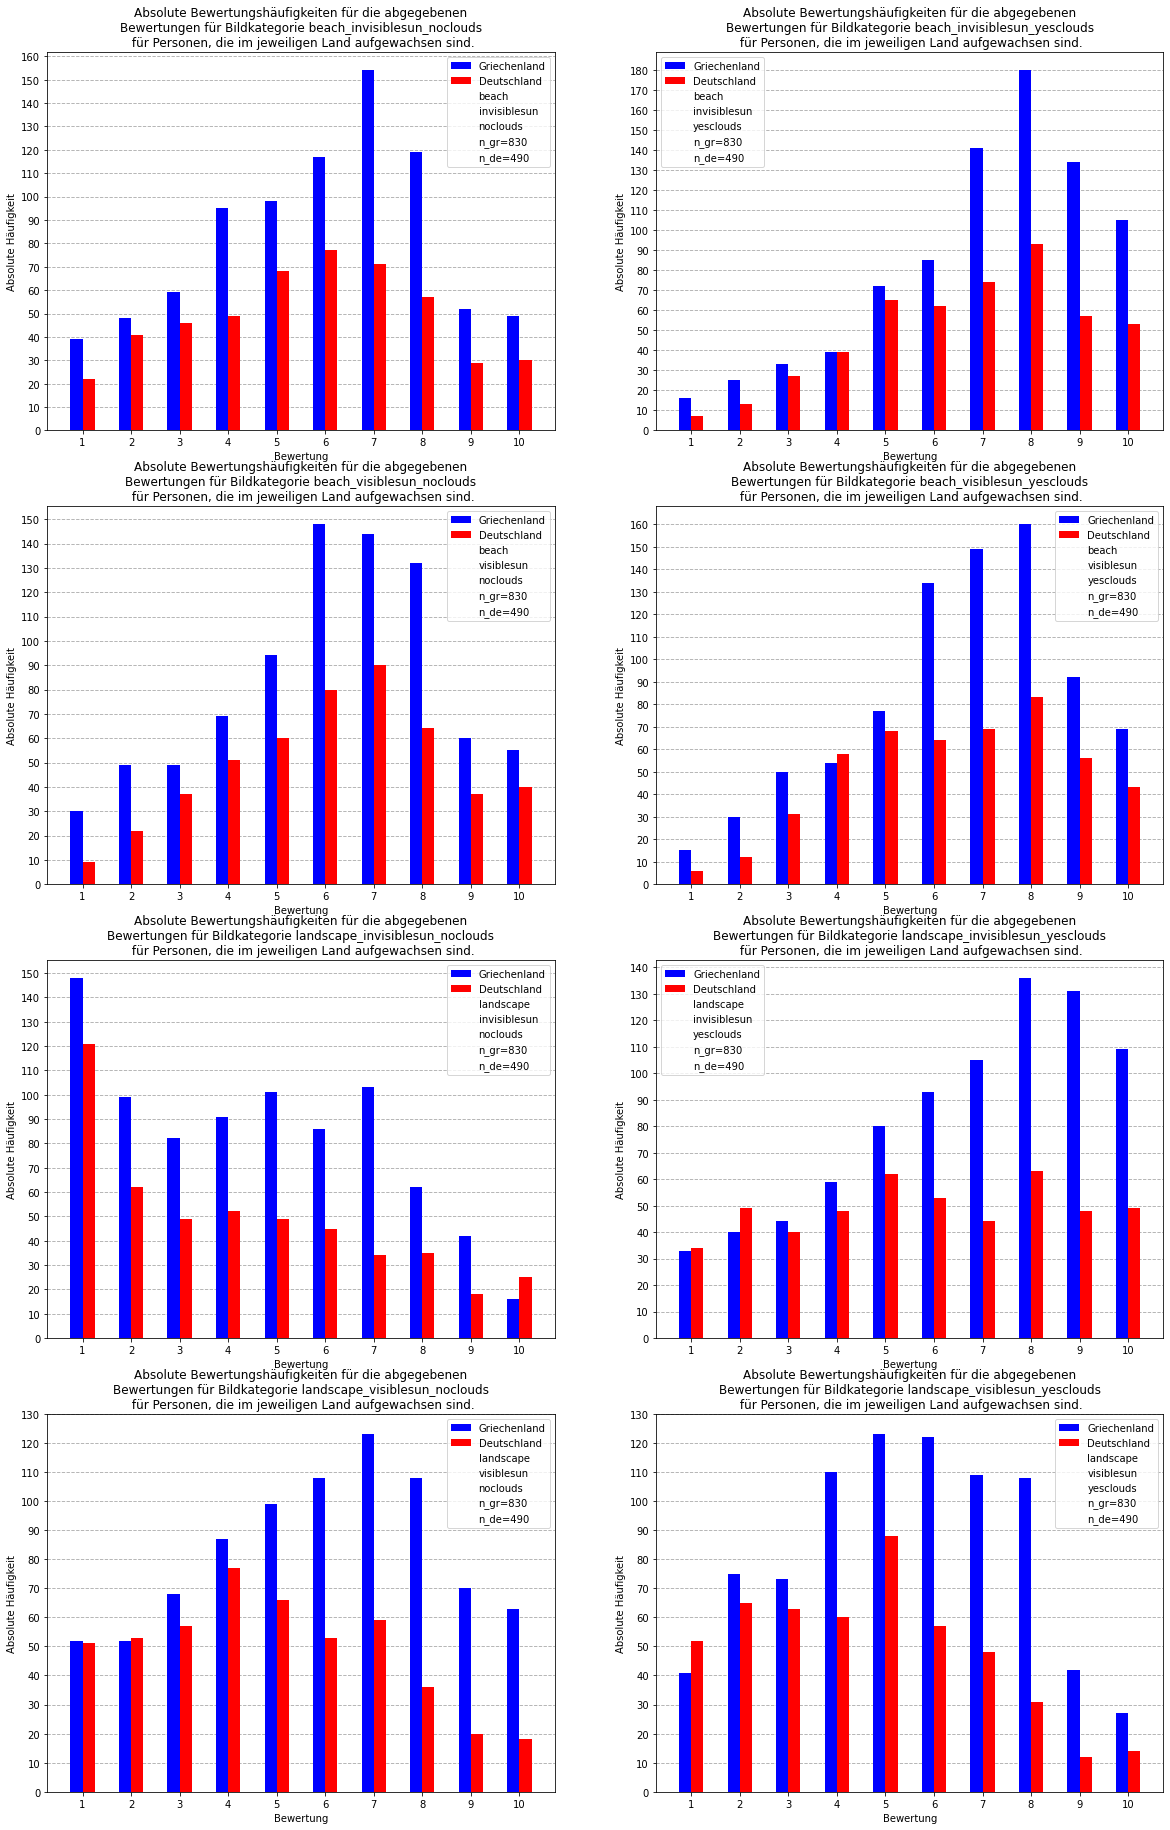

In [21]:
# asdf = (np.arange(0, 3001, 250).astype(np.float64)/100)
# [str(perc)+"%" for perc in asdf]
def plotFrequenciesForEverything():
    fig, axs = plt.subplots(4,2,figsize=(20,4*8))
#     for i in range(0,len(axs)):
#         ax = axs[i]
#     plotFor2DictsOnAx(axs[0], 'beach_invisiblesun_noclouds',cat1_n_gr,cat1_n_de,[cat1GrRatings_avg, cat1DeRatings_avg])
#     plotFor2DictsOnAx(axs[1], 'beach_invisiblesun_yesclouds',cat2_n_gr,cat2_n_de, [cat2GrRatings_avg, cat2DeRatings_avg])
    plotFrequenciesForCategoryOnAx(axs[0][0], 'beach_invisiblesun_noclouds')
    plotFrequenciesForCategoryOnAx(axs[0][1], 'beach_invisiblesun_yesclouds')
    plotFrequenciesForCategoryOnAx(axs[1][0], 'beach_visiblesun_noclouds')
    plotFrequenciesForCategoryOnAx(axs[1][1], 'beach_visiblesun_yesclouds')
    plotFrequenciesForCategoryOnAx(axs[2][0], 'landscape_invisiblesun_noclouds')
    plotFrequenciesForCategoryOnAx(axs[2][1], 'landscape_invisiblesun_yesclouds')
    plotFrequenciesForCategoryOnAx(axs[3][0], 'landscape_visiblesun_noclouds')
    plotFrequenciesForCategoryOnAx(axs[3][1], 'landscape_visiblesun_yesclouds')
    plt.savefig('abs_haeuf.jpg', dpi=150)
    
    
def plotFrequenciesForCategoryOnAx(ax, category):
#     fig, axs = plt.subplots(1,2,figsize=(20,21))
#     gr_ratings_avg, n_gr, de_ratings_avg, n_de = getAveragedDataForCategory(category)
#     plotFor2DictsOnAx(ax, category, n_gr, n_de,[gr_ratings_avg, de_ratings_avg])
    gr_ratings, n_gr, de_ratings, n_de = getAbsoluteDataForCategory(category)
    plotFor2DictsOnAx(ax, category, n_gr, n_de,[gr_ratings, de_ratings])

    
def plotFor2DictsOnAx(ax, imageCategory,n_gr, n_de, ratingsDicts):
# fig = plt.figure(figsize=(10,8))
    width = 0.5
    colors = ['blue', 'red'] #Blue - Greece, Red - Germany
    bars = []
    ymax = 0
    for i, ratingsDict in enumerate(ratingsDicts):
        w = width/2
        x, y = getxyFromDict(ratingsDict)
        if max(y)>ymax:
            ymax=max(y)
        bar = ax.bar(x+(i*w),y,w,color=colors[i], zorder=10)
        bars.append(bar)
    parameters = imageCategory.split('_')
    parameters.append(f"n_gr={n_gr}")
    parameters.append(f"n_de={n_de}")
    for param in parameters:
        emptyBar = ax.bar(1.5,0, alpha=0)
        bars.append(emptyBar)
    ax.set_xticks(x+width/4)
    ax.set_xticklabels(x)
#     ax.set_yticks(np.arange(0,0.3,step=0.025)) #For relative frequencies
    ax.set_yticks(np.arange(0,ymax+10,step=10))
#     ax.set_yticks()
#     ax.set_xticklabels(x)
    ax.set_xlabel(f"Bewertung")
#     ax.set_ylabel(f"Relative Häufigkeit")
    ax.set_ylabel("Absolute Häufigkeit")
    ax.legend(bars, ['Griechenland','Deutschland'] + parameters)#,'beach'])
    ax.grid(ls = '--', lw = 0.9, axis = 'y', zorder = 0)
#     ax.set_title(f"Relative Bewertungshäufigkeiten für die abgegebenen\nBewertungen für Bildkategorie {imageCategory}\n für Personen die im jeweiligen Land aufgewachsen sind.")
    ax.set_title(f"Absolute Bewertungshäufigkeiten für die abgegebenen\nBewertungen für Bildkategorie {imageCategory}\n für Personen, die im jeweiligen Land aufgewachsen sind.")
    return bars

plotFrequenciesForEverything()

In [22]:
de_avg_variance = np.average([p.getVariance() for p in dePersons])
de_avg = np.average([p.getAverage() for p in dePersons])
gr_avg_variance = np.average([p.getVariance() for p in grPersons])
gr_avg = np.average([p.getAverage() for p in grPersons])

In [23]:
def getRatingListForCategory(category, homeland):
    categoryImages = imgsDictByCategory[category]
    res_ratings = []
    for img in categoryImages:
        res_ratings += img.getRatingsAsList(homeland)
    return res_ratings
        
def getAllRatingsListForCategory(category):
    categoryImages = imgsDictByCategory[category]
    res_ratings = []
    for img in categoryImages:
        res_ratings += img.getAllRatingsAsList()
    return res_ratings

def getRatingDictForCategory(category, homeland):
    categoryImages = imgsDictByCategory[category]
    ratingScale = categoryImages[0].getRatingDict(homeland).keys()
    res = dict()
    for rating in ratingScale:
        res[rating] = 0
    for img in categoryImages:
        imgRatingDict = img.getRatingDict(homeland)
        for rating in ratingScale:
            res[rating] += imgRatingDict[rating]
    return res

def getN(homeland):
    persons_with_that_homeland = [person for person in persons if person.homeland == homeland]
    return len(persons_with_that_homeland)
# getRatingDictForCategory('beach_invisiblesun_noclouds','gr')
# getRatingListForCategory('beach_invisiblesun_noclouds', 'gr')
# len(getAllRatingsListForCategory('beach_invisiblesun_noclouds'))

In [24]:
def showDataForCategories():
    print("Statistic data for each category:\n")
    for category in imgsDictByCategory.keys():
        deRatings = getRatingListForCategory(category, 'de')
        de_avg = np.average(deRatings)
        de_var = np.var(deRatings)
        de_std = np.std(deRatings)
        
        grRatings = getRatingListForCategory(category, 'gr')
        gr_avg = np.average(grRatings)
        gr_var = np.var(grRatings)
        gr_std = np.std(grRatings)
        
        totalRatings = getAllRatingsListForCategory(category)
        total_avg = np.average(totalRatings)
        total_var = np.var(totalRatings)
        total_std = np.std(totalRatings)
        
        diff_avg = np.abs(de_avg-gr_avg)
        diff_var = np.abs(de_var-gr_var)
        diff_std = np.abs(de_std-gr_std)
        
        gr_rating_dict = getRatingDictForCategory(category,'gr')
        gr_abs_rating_frequencies = np.array(list(gr_rating_dict.values()))
#         gr_abs_rating_frequencies = gr_abs_rating_frequencies/gr_abs_rating_frequencies.sum()
        de_rating_dict = getRatingDictForCategory(category,'de')
        de_abs_rating_frequencies = np.array(list(de_rating_dict.values()))
#         de_abs_rating_frequencies = de_abs_rating_frequencies/de_abs_rating_frequencies.sum()
        
        
        corr_coeff = np.corrcoef(de_abs_rating_frequencies,gr_abs_rating_frequencies)[0,1]
        
        line = f"{category:32}\n"
        line += f"         DE - Avg: {de_avg:4.2f} - Var: {de_var:4.2f} - Std: {de_std:4.2f}\n"
        line += f"         GR - Avg: {gr_avg:4.2f} - Var: {gr_var:4.2f} - Std: {gr_std:4.2f}\n"
        line += f"Differences - Avg: {diff_avg:4.2f} - Var: {diff_var:4.2f} - Std: {diff_std:4.2f}\n"
        line += f"      Total - Avg: {total_avg:4.2f} - Var: {total_var:4.2f} - Std: {total_std:4.2f}\n"
        line += f"Correlation Coefficient of abs. rating frequencies De-Gr: {corr_coeff:4.3f}\n"
        print(line)
    
showDataForCategories()

Statistic data for each category:

beach_invisiblesun_noclouds     
         DE - Avg: 5.62 - Var: 5.82 - Std: 2.41
         GR - Avg: 5.87 - Var: 5.57 - Std: 2.36
Differences - Avg: 0.25 - Var: 0.26 - Std: 0.05
      Total - Avg: 5.78 - Var: 5.68 - Std: 2.38
Correlation Coefficient of abs. rating frequencies De-Gr: 0.882

beach_invisiblesun_yesclouds    
         DE - Avg: 6.68 - Var: 4.96 - Std: 2.23
         GR - Avg: 7.08 - Var: 4.95 - Std: 2.23
Differences - Avg: 0.40 - Var: 0.01 - Std: 0.00
      Total - Avg: 6.93 - Var: 4.99 - Std: 2.23
Correlation Coefficient of abs. rating frequencies De-Gr: 0.908

beach_visiblesun_noclouds       
         DE - Avg: 6.17 - Var: 5.06 - Std: 2.25
         GR - Avg: 6.10 - Var: 5.34 - Std: 2.31
Differences - Avg: 0.07 - Var: 0.28 - Std: 0.06
      Total - Avg: 6.13 - Var: 5.23 - Std: 2.29
Correlation Coefficient of abs. rating frequencies De-Gr: 0.945

beach_visiblesun_yesclouds      
         DE - Avg: 6.45 - Var: 4.93 - Std: 2.22
         GR - 

In [25]:
def calculateStatsForCategories():
#     print("Statistic data for each category:\n")
    stats = dict()
    for category in imgsDictByCategory.keys():
        entry = dict()
        
        deRatings = getRatingListForCategory(category, 'de')
        de_avg = np.average(deRatings)
        de_var = np.var(deRatings)
        de_std = np.std(deRatings)
        
        grRatings = getRatingListForCategory(category, 'gr')
        gr_avg = np.average(grRatings)
        gr_var = np.var(grRatings)
        gr_std = np.std(grRatings)
        
        totalRatings = getAllRatingsListForCategory(category)
        total_avg = np.average(totalRatings)
        total_var = np.var(totalRatings)
        total_std = np.std(totalRatings)
        
        diff_avg = np.abs(de_avg-gr_avg)
        diff_var = np.abs(de_var-gr_var)
        diff_std = np.abs(de_std-gr_std)
        
        gr_rating_dict = getRatingDictForCategory(category,'gr')
        gr_abs_rating_frequencies = np.array(list(gr_rating_dict.values()))
#         gr_abs_rating_frequencies = gr_abs_rating_frequencies/gr_abs_rating_frequencies.sum()
        de_rating_dict = getRatingDictForCategory(category,'de')
        de_abs_rating_frequencies = np.array(list(de_rating_dict.values()))
#         de_abs_rating_frequencies = de_abs_rating_frequencies/de_abs_rating_frequencies.sum()
        
        
        corr_coeff = np.corrcoef(de_abs_rating_frequencies,gr_abs_rating_frequencies)[0,1]
        
        entry['de'] = {
            'avg': de_avg,
            'var': de_var,
            'std': de_std,
             }
        entry['gr'] = {
            'avg': gr_avg,
            'var': gr_var,
            'std': gr_std,
             }
        entry['total'] = {
            'avg': total_avg,
            'var': total_var,
            'std': total_std,
             }
        entry['diff'] = {
            'avg': diff_avg,
            'var': diff_var,
            'std': diff_std
             }
        entry['corr_coeff'] = corr_coeff
        stats[category] = entry
    return stats

In [26]:
allStats = calculateStatsForCategories()
allStats['beach_invisiblesun_noclouds']['diff'], allStats

({'avg': 0.24947135480698268,
  'var': 0.257055785956509,
  'std': 0.053862748687923734},
 {'beach_invisiblesun_noclouds': {'de': {'avg': 5.6204081632653065,
    'var': 5.823256976259891,
    'std': 2.413142551997269},
   'gr': {'avg': 5.869879518072289,
    'var': 5.566201190303382,
    'std': 2.359279803309345},
   'total': {'avg': 5.777272727272727,
    'var': 5.676150137741047,
    'std': 2.3824672374958373},
   'diff': {'avg': 0.24947135480698268,
    'var': 0.257055785956509,
    'std': 0.053862748687923734},
   'corr_coeff': 0.8818211374786769},
  'beach_invisiblesun_yesclouds': {'de': {'avg': 6.677551020408163,
    'var': 4.957251145356103,
    'std': 2.226488523517717},
   'gr': {'avg': 7.0771084337349395,
    'var': 4.950680795471041,
    'std': 2.2250125382727712},
   'total': {'avg': 6.928787878787879,
    'var': 4.9903833792470165,
    'std': 2.2339166007814653},
   'diff': {'avg': 0.3995574133267761,
    'var': 0.006570349885061333,
    'std': 0.0014759852449457433},
   '

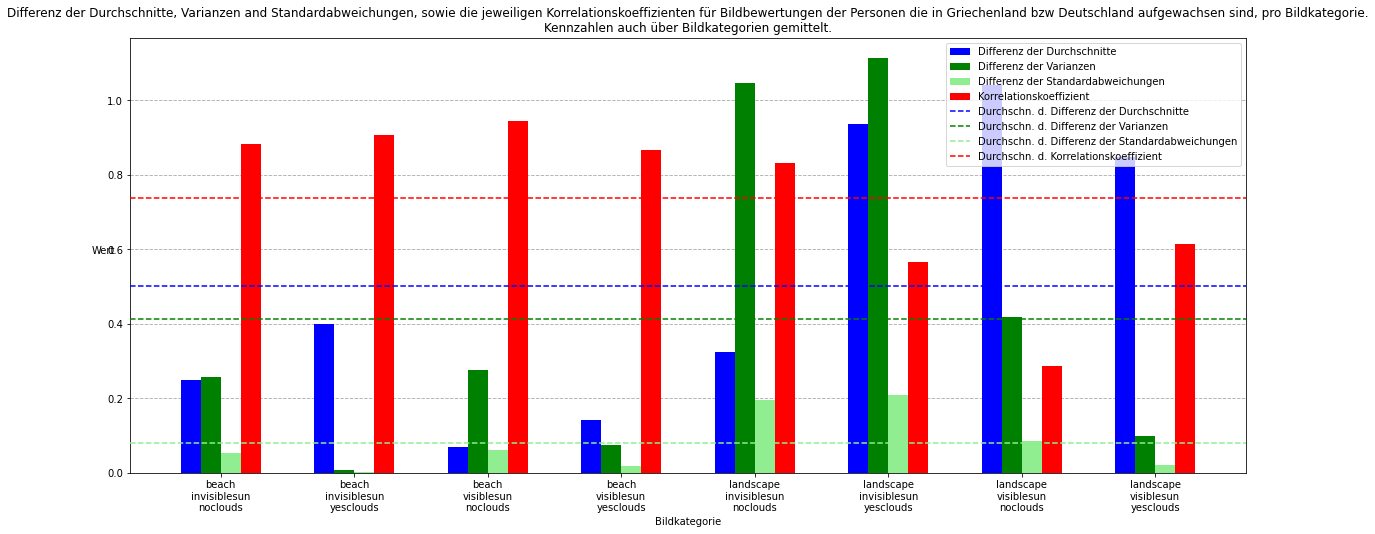

In [27]:
def plotDifferences(stats):
    categories = list(stats.keys())
    indices = np.array(list(range(1, len(categories)+1)))
    colors = ['blue', 'green','lightGreen','red']
    label_ticks = []
    labels = ['\n'.join(cat.split('_')) for cat in categories]
    
    averages = []
    variances = []
    stds = []
    corr_coeffs = []
    toAverage = {'avg': averages, 'var': variances, 'std':stds, 'corr_coeff': corr_coeffs}
    
    width = 0.6
    parameters = ['avg', 'var', 'std']
    w = width/(len(parameters)+1)
    
    fig = plt.figure(figsize=(20,8))
    plt.grid(linestyle='--', linewidth=0.9, axis='y', zorder=0)
    bars = []
    for i, category in enumerate(categories):
#         b = plt.bar(category, stats[category]['diff'][parameter])
        for j, param in enumerate(parameters):
#             w = width/(len(parameters)+1)
            x = i +(j*w)+1
            y = stats[category]['diff'][param]
            toAverage[param].append(y)
            b = plt.bar(x,y,w, color=colors[j], zorder=5)
            bars.append(b)
#             label_ticks.append(x)
#             labels.append(param)
#        w = width/(len(parameters)+1)
        x = i +((j+1)*w)+1
        y = stats[category]['corr_coeff']
        toAverage['corr_coeff'].append(y)
#         label_ticks.append(x)
#         labels.append('corr_coeff')
        b = plt.bar(x,y,w, color=colors[j+1],zorder=5)
        bars.append(b)
            
    
    hlines = []
    for i, param in enumerate(parameters):
        hline = plt.axhline(np.average(toAverage[param]), color = colors[i], zorder = 10, ls='--')
        hlines.append(hline)
    hline = plt.axhline(np.average(toAverage['corr_coeff']), color = 'red', zorder = 10, ls='--')   
    hlines.append(hline)
    
#     barLabels = ['Averages Difference', 'Variances Difference', 'Standard Deviations Difference', 'Correlation Coefficient']
#     hlineLabels = ['Average ' + barLabel for barLabel in barLabels]
    barLabels = ['Differenz der Durchschnitte', 'Differenz der Varianzen', 'Differenz der Standardabweichungen', 'Korrelationskoeffizient']
    hlineLabels = ['Durchschn. d. ' + barLabel for barLabel in barLabels]
    plt.legend(bars[0:4] + hlines, barLabels + hlineLabels)
    #Add the average lines
    
    
    plt.xticks(indices+1.5*w,labels)#, rotation=60)
#     plt.xticks(label_ticks, labels, rotation = 45)
#     plt.xlabel("Image Category")
#     plt.ylabel("Value")
    plt.xlabel("Bildkategorie")
    plt.ylabel("Wert", rotation=0)
#     plt.title("Differences of average, variance and standart deviation as well as correlation coefficient for image ratings of people who were raised in Greece vs in Germany for each image category")
    plt.title("Differenz der Durchschnitte, Varianzen and Standardabweichungen, sowie die jeweiligen Korrelationskoeffizienten für Bildbewertungen der Personen die in Griechenland bzw Deutschland aufgewachsen sind, pro Bildkategorie.\nKennzahlen auch über Bildkategorien gemittelt.")
    plt.savefig('differences2.jpg', dpi=150)
    plt.show()
    
plotDifferences(allStats)

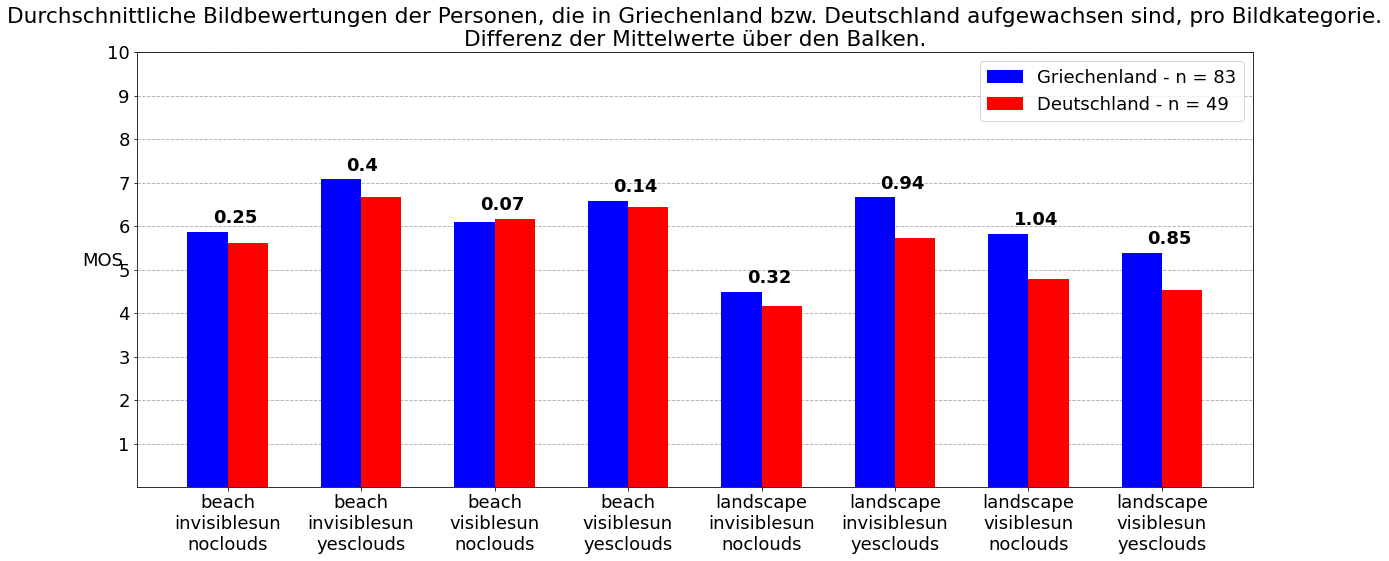

In [28]:
def plotAverages(stats):
    plt.rcParams.update({'font.size': 18})
    categories = list(stats.keys())
    indices = np.array(list(range(1, len(categories)+1)))
    colors = ['blue', 'red']
    homelands = ['gr','de']
    label_ticks = []
    labels = ['\n'.join(cat.split('_')) for cat in categories]
    
    averages = []
#     variances = []
#     stds = []
#     corr_coeffs = []
    toAverage = {'avg': averages}#, 'var': variances, 'std':stds, 'corr_coeff': corr_coeffs}
    
    width = 0.6
    parameters = ['avg']#, 'var', 'std']
    w = width/(len(parameters)+1)
    
    fig = plt.figure(figsize=(20,8))
    plt.grid(linestyle='--', linewidth=0.9, axis='y', zorder=0)
    bars = []
    for i, category in enumerate(categories):
        toMax = []
        for j, homeland in enumerate(homelands):
            x = i +(j*w)+1
            y = stats[category][homeland]['avg']
            b = plt.bar(x,y,w, color=colors[j], zorder=5)
            bars.append(b)
            toMax.append(y)
        max_bar_value = max(toMax)
        diff_of_avg = round(stats[category]['diff']['avg'],2)
        plt.text(i+0.5*w+0.89,max_bar_value+0.2, str(diff_of_avg), color='black', fontweight='bold') #Plot the differences as number above the bars
#     emptyBars = []
#     for homeland in homelands:
#         emptyBar = plt.bar(1.5,0, alpha=0)
#         emptyBars.append(emptyBar)
    n_gr = getN('gr')
    n_de = getN('de')
    barLabels = [f'Griechenland - n = {n_gr}',f'Deutschland - n = {n_de}']
#     emptyBarLabels = [f'{n_gr} Versuchspersonen aus Griechenland', f'{n_de} Versuchspersonen aus Deutschland']
    plt.legend(bars[0:2], barLabels)# + emptyBarLabels)

    
    
    plt.xticks(indices+0.5*w,labels)#, rotation=60)
    plt.yticks(range(1,11))
    plt.ylabel("MOS", rotation=0)
    plt.title("Durchschnittliche Bildbewertungen der Personen, die in Griechenland bzw. " +
            "Deutschland aufgewachsen sind, pro Bildkategorie.\n" + 
            "Differenz der Mittelwerte über den Balken.")
#     plt.savefig('averages.jpg', dpi=150, bbox_inches='tight')
    plt.show()
    
plotAverages(allStats)

## Daten zu den Versuchspersonen

In [29]:
n_gr = getN('gr')
n_de = getN('de')
ages_gr = [p.age for p in grPersons]
genders_gr = [p.gender for p in grPersons]

ages_de = [p.age for p in dePersons]
genders_de = [p.gender for p in dePersons]


print("Aufwachsland: Griechenland")
print(f"n: {n_gr}")
print(f"Alter: {min(ages_gr)}-{max(ages_gr)}, durchschnittliches Alter von {round(np.average(ages_gr),2)} und Standardabweichung von {round(np.std(ages_gr),2)}")
print(f"Weiblich: {genders_gr.count('f')}, Männlich: {genders_gr.count('m')}, Andere: {genders_gr.count('x')}")
print("")
print("Aufwachsland: Deutschland")
print(f"n: {n_de}")
print(f"Alter: {min(ages_de)}-{max(ages_de)}, durchschnittliches Alter von {round(np.average(ages_de),2)} und Standardabweichung von {round(np.std(ages_de),2)}")
print(f"Weiblich: {genders_de.count('f')}, Männlich: {genders_de.count('m')}, Andere: {genders_de.count('x')}")


Aufwachsland: Griechenland
n: 83
Alter: 18-62, durchschnittliches Alter von 27.36 und Standardabweichung von 10.72
Weiblich: 41, Männlich: 40, Andere: 2

Aufwachsland: Deutschland
n: 49
Alter: 21-68, durchschnittliches Alter von 33.2 und Standardabweichung von 11.02
Weiblich: 21, Männlich: 27, Andere: 1


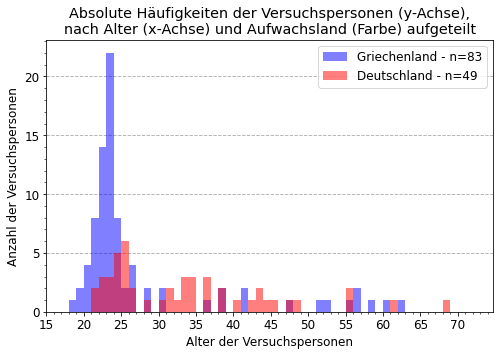

In [30]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(8,5))
bins = np.arange(min(ages_gr+ages_de), max(ages_gr+ages_de)+5, 1.0)
plt.hist(ages_gr, bins,alpha=0.5, color='blue', label=f'Griechenland - n={n_gr}',zorder=10)
plt.hist(ages_de, bins,alpha=0.5, color='red', label=f'Deutschland - n={n_de}',zorder=10)
plt.grid(linestyle='--', linewidth=0.9, axis='y', zorder=0)
# plt.xticks(np.arange(min(ages_gr+ages_de), max(ages_gr+ages_de)+5, 5.0))
plt.xticks(np.arange(15, max(ages_gr+ages_de)+5, 5.0))
plt.xlabel("Alter der Versuchspersonen")
plt.ylabel("Anzahl der Versuchspersonen")
plt.title("Absolute Häufigkeiten der Versuchspersonen (y-Achse),\nnach Alter (x-Achse) und Aufwachsland (Farbe) aufgeteilt")
plt.legend()
plt.minorticks_on()
# plt.savefig('alter_versuchspersonen.jpg', dpi=150, bbox_inches='tight')
plt.show()

# Von hier an werden die Hypothesen überprüft

### Die Daten der Markup Zellen sind nicht auf dem letzten Stand - der korrekte und aktuelle Stand befindet sich in der Bachelorarbeit

In [31]:
#For t-tests
import pandas as pd
import scipy.stats as stats
import researchpy as rp
from IPython.display import Markdown as md
#For ANOVA:
import statsmodels.api as sm
from statsmodels.formula.api import ols
#For Tukey
from statsmodels.stats.multicomp import pairwise_tukeyhsd

## Hypothese 1
### Wenn der Aufwachsort der Versuchspersonen für die ästhetische Wahrnehmung von Sonnenuntergangsbildern eine Rolle spielt, dann sollten sich die MOS bei der Beurteilung von Bildern von Deutschen und Griechen unterscheiden.
Hierfür wird ein <b>t-Test für unabhängige Stichproben</b> durchgeführt:<br>
Stichprobe $S_1$ mit Mittelwert $\mu_1$ und Standardabweichung $\sigma^2_1$: Bildbewertungen von Personen die in <b>Griechenland</b> aufgewachsen sind<br>
Stichprobe $S_2$ mit Mittelwert $\mu_2$ und Standardabweichung $\sigma^2_2$: Bildbewertungen von Personen die in <b>Deutschland</b> aufgewachsen sind<br>
Es wird der Einfluss von<br>
<b>X: Aufwachsort der Versuchspersonen</b><br>
auf<br>
<b>Y = $\mu_1 - \mu_2$: Differenz der MOS</b>
untersucht.

Voraussetzungen für diesen Test:<br>
<ol>
    <li>Die <u>Stichproben sind unabhänhig</u>: <b>Liegt vor</b>, da 2 individuelle Gruppen von Versuchspersonen geprüft werden, welche keinen Einfluss aufeinander haben.</li>
    <li>Das <u>untersuchte Merkmal ist in den Grundgesamtheiten der beiden Gruppen normalverteilt</u>: Das <b>muss überprüft werden</b></li>
    <li>Die <u>Varianzen der Stichproben müssen homogen sein</u>: Das <b>muss überprüft werden</b></li>
</ol>

#### 2. Ist die Differenz der MOS der Bildbewertungen bei beiden Gruppen normalverteilt?

Laut dem Zentralen Grenzwertsatz (ZGS) der Statistik wird die Stichprobenverteilung des standardisierten
Stichprobenmittelwerts bei wachsender Stichprobengröße $n$ der Standardnormalverteilung immer ähnlicher. Die Dauemenregel besagt dabei eine Stichprobengröße von $n\geq30$. Dies ist für beide Stichproben zutreffend. Somit wird davon ausgegangen, dass die Bildbewertungen von Personen die in Griechenland sowie in Deutschland aufgewachsen sind in ihrer Grundgesamtheit normalverteilt sind.

In [32]:
#Shapiro-Wilk (SW) Test für Normalität
mos_gr = np.array([p.getAverage() for p in grPersons])
mos_de = np.array([p.getAverage() for p in dePersons])
minSize = min(len(mos_gr), len(mos_de))
print("Cutting size down to:",minSize)
sampling_difference_hyp_1 = mos_gr[0:minSize] - mos_de[0:minSize]
shapiro_result = stats.shapiro(sampling_difference_hyp_1)#Wenn p < 0.05 --> Daten sind nicht normalverteilt
print(shapiro_result)
if(shapiro_result.pvalue>0.05):
    print("Die Nullhypothese, dass die Daten Normalverteilt sind, kann nicht abgelehnt werden, da p>0.05.")
    print("Die Daten sind demnach höchstwahrscheinlich in ihrer Grundgesamtheit normalverteilt.")
else:
    print("Die Nullhypothese, dass die Daten Normalverteilt sind, wurde abgelehnt, da p<0.05.")
    print("Die Daten sind demnach in ihrer Grundgesamtheit höchstwahrscheinlich nicht normalverteilt.")
#np.average(mos_gr),np.average(mos_de),np.average(sampling_difference_hyp_1)

Cutting size down to: 49
ShapiroResult(statistic=0.9844216704368591, pvalue=0.7569506764411926)
Die Nullhypothese, dass die Daten Normalverteilt sind, kann nicht abgelehnt werden, da p>0.05.
Die Daten sind demnach höchstwahrscheinlich in ihrer Grundgesamtheit normalverteilt.


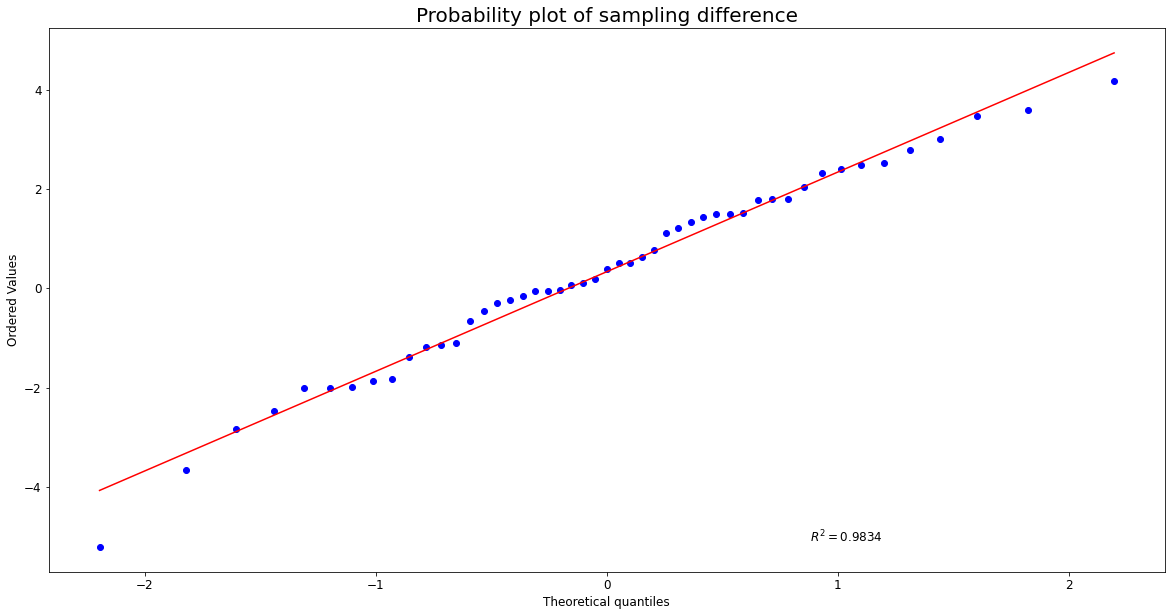

In [33]:
fig = plt.figure(figsize= (20, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(sampling_difference_hyp_1, plot= plt, rvalue= True)
ax.set_title("Probability plot of sampling difference", fontsize= 20)
ax.set

# plt.savefig("hyp1-qq-plot.jpg", dpi=150, bbox_inches='tight')
plt.show()

#### 3. Sind die Varianzen der Stichproben homogen?

In [34]:
levene_result = stats.levene(mos_gr,mos_de)
print(levene_result)
def interpret_levene(levene_res):
    if(levene_res.pvalue>0.05):
        print("Die Nullhypothese, dass die 2 Stichproben homogene Varianzen haben, kann nicht abgelehnt werden, da p>0.05.")
        print("Die 2 Stichproben haben demnach höchstwahrscheinlich homogene Varianzen.")
    else:
        print("Die Nullhypothese, dass die 2 Stichproben homogene Varianzen haben, wurde abgelehnt, da p<0.05.")
        print("Die 2 Stichproben haben demnach höchstwahrscheinlich inhomogene Varianzen.")
interpret_levene(levene_result)

LeveneResult(statistic=0.2771155720068472, pvalue=0.599495029114895)
Die Nullhypothese, dass die 2 Stichproben homogene Varianzen haben, kann nicht abgelehnt werden, da p>0.05.
Die 2 Stichproben haben demnach höchstwahrscheinlich homogene Varianzen.


#### Alle Voraussetzungen des t-Tests sind somit erfüllt.
### t-Test
#### Die Nullhypothese lautet:
<b>$\mu_1-\mu_2=H_0$</b>
Dabei wird $H_0 = 0$ gesetzt. Um einen statistisch signifikanten Unterschied der MOS zu zeigen, muss die Nullhypothese abgelehnt werden. Hierfür sollte p<0.05 sein.

In [35]:
#Create the dataframe
col1_header = 'Aufwachsort'
col2_header = 'MOS'
col1_vals = []
col2_vals = []
for mos in mos_gr:
    col1_vals.append('gr')
    col2_vals.append(mos)
for mos in mos_de:
    col1_vals.append('de')
    col2_vals.append(mos)
data_hyp_1 = {col1_header:col1_vals, col2_header:col2_vals}
df_hyp_1 = pd.DataFrame(data_hyp_1)
# df_hyp_1

In [36]:
#Execute the t-Test
#Trimming überlegen aufgrund von einer Menge von Ausreißern?
summary_hyp_1, results_hyp_1 = rp.ttest(group1=df_hyp_1['MOS'][df_hyp_1['Aufwachsort'] == 'gr'], group1_name="MOS von Personen mit GR Aufwachsort",
                            group2=df_hyp_1['MOS'][df_hyp_1['Aufwachsort'] == 'de'], group2_name="MOS von Personen mit DE Aufwachsort")

In [37]:
summary_hyp_1

Variable      N      Mean        SD        SE  \
0  MOS von Personen mit GR Aufwachsort   83.0  6.001657  1.217787  0.133670   
1  MOS von Personen mit DE Aufwachsort   49.0  5.517857  1.285002  0.183572   
2                             combined  132.0  5.822064  1.260308  0.109696   

   95% Conf.  Interval  
0   5.735745  6.267568  
1   5.148761  5.886953  
2   5.605060  6.039069

In [38]:
results_hyp_1

Independent t-test   results
0  Difference (MOS von Personen mit GR Aufwachsor...    0.4838
1                              Degrees of freedom =   130.0000
2                                               t =     2.1604
3                           Two side test p value =     0.0326
4                          Difference < 0 p value =     0.9837
5                          Difference > 0 p value =     0.0163
6                                       Cohen's d =     0.3892
7                                       Hedge's g =     0.3870
8                                   Glass's delta =     0.3973
9                                     Pearson's r =     0.1862

In Zeile 3 lässt sich der Wert p = 0.0326 ablesen. Dieser ist kleiner als das Signifikanzniveau 0.05, somit kann die Nullhypothese abgelehnt werden, was bedeutet, dass sich die MOS der Personen die in Griechenland aufgewachsen sind, von den MOS der Personen die in Detuschland aufgewachsen sind bei einem Freiheitsgrad von $f=130$ und Stichprobengrößen von respektive 83 und 49 statistisch signifikant unterscheiden. Der Unterschied der durschnittlichen MOS der Gruppen beträgt 0.48 Skalenpunkte. <br>
Das bedeutet, dass Personen die in Griechenland aufgewachsen sind um 0.48 Skalenpunkte höher bewerten, als Personen die in Deutschland aufgewachsen sind.<br>
<b>Die 1. Hypothese ist somit bestätigt.</b>

In [39]:
#Pearson-Produkt-Momentkorrelation r NUR FUER n1=n2
# def calcPearson(t, df):
#     r = np.power(t,2) / ( np.power(t,2) + df )
#     r = np.sqrt(r)
#     return r

# def interpretPearson(r):
#     print("r =",r)
#     if (r>=0.1 and r<0.3):
#         print("Der Effekt ist schwach.")
#     elif()
def calculateCohen(t, n1, n2):
    d = 1/n1 + 1/n2
    d = np.sqrt(d)
    d = t*d
    return d

def interpretCohen(d):
    print("Cohen's d =",d)
    d_abs = np.abs(d)
    if (d_abs>=0.2 and d_abs<0.5):
        print("Der Effekt ist schwach.")
    elif(d_abs>=0.5 and d<0.8):
        print("Der Effekt ist mittelstark.")
    elif(d_abs>=0.8):
        print("Der Effekt ist stark.")
    else:
        print("Der Effekt ist minimal(?).")

In [40]:
# np.average([allStats[category]['diff']['avg'] for category in allStats.keys()])
gr_avg, de_avg

(6.001656626506024, 5.517857142857143)

In [41]:
# d_hyp1 = calculateCohen(results_hyp_1['results'][2], summary_hyp_1['N'][0],summary_hyp_1['N'][1])
interpretCohen(results_hyp_1['results'][6])

Cohen's d = 0.3892
Der Effekt ist schwach.


## Hypothese 2
### Wenn die Präsenz von Wolken auf Sonnenuntergangsbildern für die ästhetische Wahrnehmung solcher Bilder eine Rolle spielt, dann sollten die MOS von Bildern mit Wolken sich von denen ohne Wolken unterscheiden.
Hierfür wird ein <b>t-Test für abhängige Stichproben</b> durchgeführt:<br>
Stichprobe $S_1$ mit Mittelwert $\mu_1$ und Standardabweichung $\sigma^2_1$: MOS von Bildern <b>mit Wolken</b><br>
Stichprobe $S_2$ mit Mittelwert $\mu_2$ und Standardabweichung $\sigma^2_2$: MOS von Bildern <b>ohne Wolken</b><br>
Es wird der Einfluss von<br>
<b>X: Präsenz von Wolken auf dem Bild</b><br>
auf<br>
<b>Y = $\mu_1 - \mu_2$: Differenz der MOS</b>
untersucht.

Voraussetzungen für diesen Test:<br>
<ol>
    <li>Die <u>Messwertpaare</u> der verbundenen Stichproben sind <u>voneinander unabhänhig</u>: <b>Liegt vor</b>, da dieselbe Gruppe von Versuchspersonen geprüft wird, und zwar für unterschiedliche Typen von Bildern, welche keinen Einfluss aufeinander haben.</li>
    <li>Die <u>Unterschiede zwischen den verbundenen Testwerten sind in der Grundgesamtheit normalverteilt</u> (ab $n>30$ sind Verletzungen unproblematisch): Das <b>muss nicht überprüft werden</b>, da jeweils $n=60$ Personen</li>
</ol>

#### 2. Ist die Differenz der MOS der Bilder mit und ohne Wolken normalverteilt?

In [42]:
categories_yes_clouds = [cat for cat in imgsDictByCategory.keys() if 'yesclouds' in cat]
categories_no_clouds = [cat for cat in imgsDictByCategory.keys() if 'noclouds' in cat]

In [43]:
def getAverageForCategories(person, categories):
    categoryStatsDict = person.getCategoryStatsDict()
    ratingsForCategory = []
    for cat in categories:
        ratingsForCategory.append(categoryStatsDict[cat]['average'])
    return np.average(ratingsForCategory)

In [44]:
mos_ohne_wolken = np.array([getAverageForCategories(person, categories_no_clouds) for person in persons])
mos_mit_wolken = np.array([getAverageForCategories(person, categories_yes_clouds) for person in persons])
sampling_difference_hyp_2 = mos_ohne_wolken-mos_mit_wolken
np.average(mos_ohne_wolken), np.average(mos_mit_wolken), len(mos_ohne_wolken), len(mos_mit_wolken)

(5.429924242424242, 6.214204545454545, 132, 132)

In [45]:
# mos_ohne_wolken_old = np.array([image.getAllAverage() for image in allImgs if image.cloudVisibility=='noclouds'])
# mos_mit_wolken_old = np.array([image.getAllAverage() for image in allImgs if image.cloudVisibility=='yesclouds'])
# np.average(mos_ohne_wolken_old), np.average(mos_mit_wolken_old)
np.where(sampling_difference_hyp_2<-3), sampling_difference_hyp_2[114], sampling_difference_hyp_2[130]
sampling_difference_hyp_2_adjusted = np.array(sampling_difference_hyp_2)
print(len(sampling_difference_hyp_2_adjusted))
sampling_difference_hyp_2_adjusted = np.delete(sampling_difference_hyp_2_adjusted, 130)
sampling_difference_hyp_2_adjusted = np.delete(sampling_difference_hyp_2_adjusted, 114)
# sampling_difference_hyp_2_adjusted = np.delete(sampling_difference_hyp_2_adjusted, 10)
# sampling_difference_hyp_2_adjusted = np.delete(sampling_difference_hyp_2_adjusted, -1)
print(len(sampling_difference_hyp_2_adjusted))
np.argwhere(sampling_difference_hyp_2_adjusted<-2.5)
print(persons[130],persons[114])

132
130
<__main__.Person object at 0x0000021F61892040> <__main__.Person object at 0x0000021F5FBA4310>


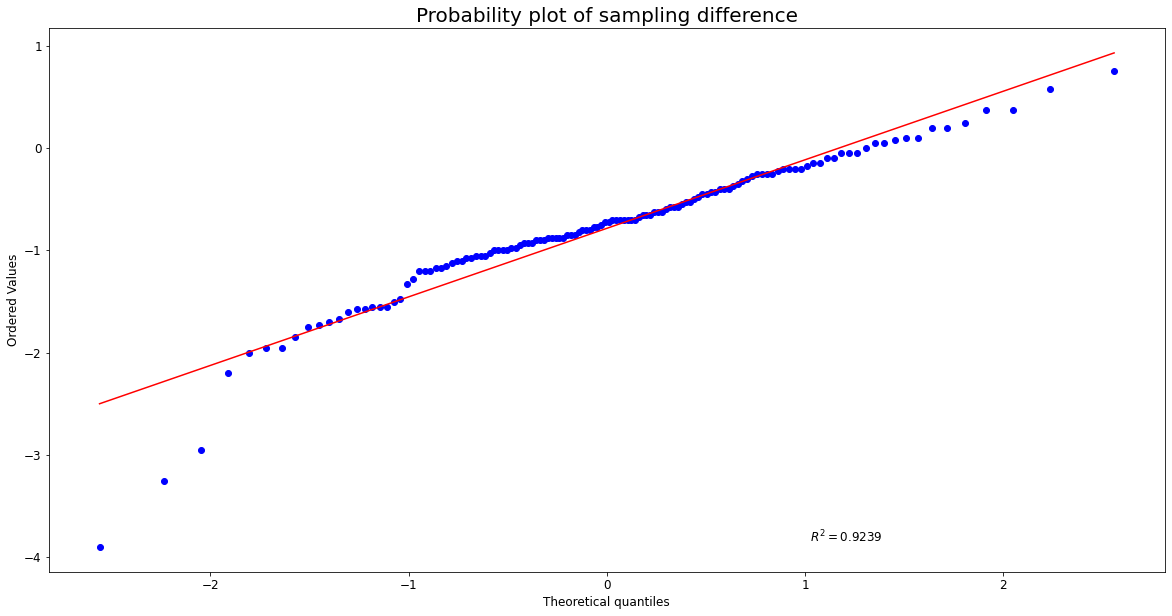

In [46]:
fig = plt.figure(figsize= (20, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(sampling_difference_hyp_2, plot= plt, rvalue= True)
ax.set_title("Probability plot of sampling difference", fontsize= 20)
ax.set

# plt.savefig("hyp2-qq-plot.jpg", dpi=150, bbox_inches='tight')
plt.show()

In [47]:
shapiro_result = stats.shapiro(sampling_difference_hyp_2)
print(shapiro_result)
if(shapiro_result.pvalue>0.05):
    print("Die Nullhypothese, dass die Daten Normalverteilt sind, kann nicht abgelehnt werden, da p>0.05.")
    print("Die Daten sind demnach höchstwahrscheinlich in ihrer Grundgesamtheit normalverteilt.")
else:
    print("Die Nullhypothese, dass die Daten Normalverteilt sind, wurde abgelehnt, da p<0.05.")
    print("Die Daten sind demnach in ihrer Grundgesamtheit höchstwahrscheinlich nicht normalverteilt.")

ShapiroResult(statistic=0.9305312037467957, pvalue=4.096614702575607e-06)
Die Nullhypothese, dass die Daten Normalverteilt sind, wurde abgelehnt, da p<0.05.
Die Daten sind demnach in ihrer Grundgesamtheit höchstwahrscheinlich nicht normalverteilt.


#### Alle Voraussetzungen des t-Tests sind somit erfüllt.
### t-Test
#### Die Nullhypothese lautet:
<b>$\mu_1-\mu_2=H_0$</b>
Dabei wird $H_0 = 0$ gesetzt. Um einen statistisch signifikanten Unterschied der MOS zu zeigen, muss die Nullhypothese abgelehnt werden. Hierfür sollte p<0.05 sein.

In [48]:
#Create the dataframe
hyp_2_col1_header = 'noclouds'
hyp_2_col2_header = 'yesclouds'

# mos_ohne_wolken_adjusted = np.array(mos_ohne_wolken)
# mos_ohne_wolken_adjusted = np.delete(mos_ohne_wolken_adjusted, 130)
# mos_ohne_wolken_adjusted = np.delete(mos_ohne_wolken_adjusted, 114)
# mos_mit_wolken_adjusted = np.array(mos_mit_wolken)
# mos_mit_wolken_adjusted = np.delete(mos_mit_wolken_adjusted, 130)
# mos_mit_wolken_adjusted = np.delete(mos_mit_wolken_adjusted, 114)

hyp_2_col1_vals = mos_ohne_wolken
hyp_2_col2_vals = mos_mit_wolken
data_hyp_2 = {hyp_2_col1_header:hyp_2_col1_vals, hyp_2_col2_header:hyp_2_col2_vals}
df_hyp_2 = pd.DataFrame(data_hyp_2)

In [49]:
print(stats.ttest_rel(df_hyp_2['noclouds'], df_hyp_2['yesclouds']))
summary_hyp_2, results_hyp_2 = rp.ttest(group1=df_hyp_2['noclouds'], group1_name="MOS von Bildern ohne Wolken",
                            group2=df_hyp_2['yesclouds'], group2_name="MOS von Bildern mit Wolken", paired=True)

Ttest_relResult(statistic=-13.08850559554755, pvalue=1.4964930764507057e-25)


In [50]:
summary_hyp_2

Variable      N      Mean        SD        SE  \
0  MOS von Bildern ohne Wolken  132.0  5.429924  1.244474  0.108318   
1   MOS von Bildern mit Wolken  132.0  6.214205  1.365654  0.118865   
2                         diff  132.0 -0.784280  0.688443  0.059921   

   95% Conf.  Interval  
0   5.215646  5.644202  
1   5.979061  6.449348  
2  -0.902819 -0.665742

In [51]:
results_hyp_2

Paired samples t-test   results
0  Difference (MOS von Bildern ohne Wolken - MOS ...   -0.7843
1                              Degrees of freedom =   131.0000
2                                               t =   -13.0885
3                           Two side test p value =     0.0000
4                          Difference < 0 p value =     0.0000
5                          Difference > 0 p value =     1.0000
6                                       Cohen's d =    -0.6010
7                                       Hedge's g =    -0.5992
8                                   Glass's delta =    -0.6302
9                                     Pearson's r =     0.7528

In [52]:
avg_mit_wolken = np.average(mos_mit_wolken)
avg_ohne_wolken = np.average(mos_ohne_wolken)
differenz_hyp_2 = avg_mit_wolken - avg_ohne_wolken
print(f"Durchschnittliche Bewertung ohne Wolken:", round(avg_ohne_wolken,2))
print(f"Durchschnittliche Bewertung mit Wolken", round(avg_mit_wolken,2))
print(f"Differenz von:", round(differenz_hyp_2,2))
interpretCohen(results_hyp_2['results'][6])

Durchschnittliche Bewertung ohne Wolken: 5.43
Durchschnittliche Bewertung mit Wolken 6.21
Differenz von: 0.78
Cohen's d = -0.601
Der Effekt ist mittelstark.


Der p-Wert beträgt 0.0065. Dieser ist viel kleiner als das Signifikanzniveau 0.05, somit kann die Nullhypothese abgelehnt werden, was bedeutet, dass sich die MOS von Bildern ohne Wolken, von den MOS von Bildern mit Wolken bei einem Freiheitsgrad von $f=60-1=59$ und Stichprobengrößen von jeweils $n=60$ Personen statistisch signifikant unterscheiden. Der Unterschied der durschnittlichen MOS der Gruppen beträgt 0.74 Skalenpunkte. Das bedeutet, dass Bilder mit Wolken um 0.74 Skalenpunkte höher bewertet werden, als Bilder ohne Wolken.<br>
<b>Die 2. Hypothese ist somit bestätigt.</b>

## Hypothese 3
### Wenn die Präsenz von Stränden oder Meeren auf Sonnenuntergangsbildern für die ästhetische Wahrnehmung solcher Bilder eine Rolle spielt, dann sollten die MOS von Bildern mit Strand oder Meer sich von denen mit Landschaft unterscheiden. 
Hierfür wird ein <b>t-Test für abhängige Stichproben</b> durchgeführt:<br>
Stichprobe $S_1$ mit Mittelwert $\mu_1$ und Standardabweichung $\sigma^2_1$: MOS von Bildern <b>mit Meer</b><br>
Stichprobe $S_2$ mit Mittelwert $\mu_2$ und Standardabweichung $\sigma^2_2$: MOS von Bildern <b>ohne Meer</b><br>
Es wird der Einfluss von<br>
<b>X: Präsenz von Meer auf dem Bild</b><br>
auf<br>
<b>Y = $\mu_1 - \mu_2$: Differenz der MOS</b>
untersucht.

Voraussetzungen für diesen Test:<br>
<ol>
    <li>Die <u>Messwertpaare</u> der verbundenen Stichproben sind <u>voneinander unabhänhig</u>: <b>Liegt vor</b>, da dieselbe Gruppe von Versuchspersonen geprüft wird, und zwar für unterschiedliche Typen von Bildern, welche keinen Einfluss aufeinander haben.</li>
    <li>Die <u>Unterschiede zwischen den verbundenen Testwerten sind in der Grundgesamtheit normalverteilt</u> (ab $n>30$ sind Verletzungen unproblematisch): Das <b>muss nicht überprüft werden</b>, da jeweils $n=40$ Bilder</li>
</ol>

#### 2. Ist die Differenz der MOS der Bilder mit und ohne Wolken normalverteilt?

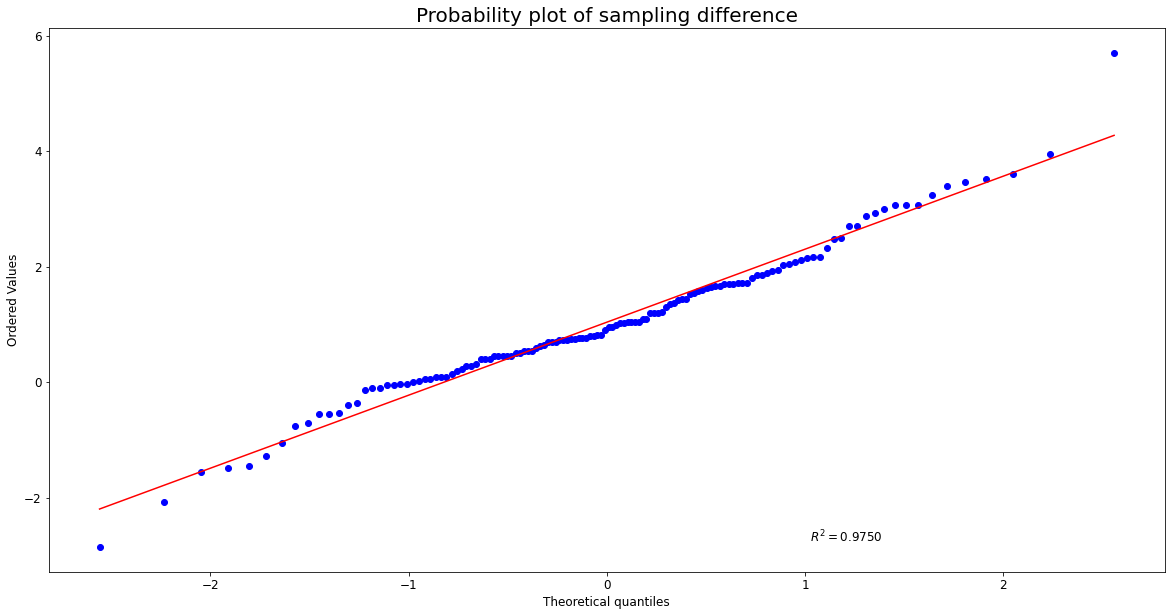

In [53]:
categories_beach = [cat for cat in imgsDictByCategory.keys() if 'beach' in cat]
categories_landscape = [cat for cat in imgsDictByCategory.keys() if 'landscape' in cat]
mos_ohne_meer = np.array([getAverageForCategories(person, categories_beach) for person in persons])
mos_mit_meer = np.array([getAverageForCategories(person, categories_landscape) for person in persons])
# mos_ohne_meer = np.sort([image.getAllAverage() for image in allImgs if image.environment!='beach'])
# mos_mit_meer = np.sort([image.getAllAverage() for image in allImgs if image.environment=='beach'])
sampling_difference_hyp_3 = mos_ohne_meer - mos_mit_meer
fig = plt.figure(figsize= (20, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(sampling_difference_hyp_3, plot= plt, rvalue= True)
ax.set_title("Probability plot of sampling difference", fontsize= 20)
ax.set

# plt.savefig("hyp3-qq-plot.jpg", dpi=150, bbox_inches='tight')
plt.show()

In [54]:
shapiro_result = stats.shapiro(mos_ohne_meer-mos_mit_meer)
print(shapiro_result)
if(shapiro_result.pvalue>0.05):
    print("Die Nullhypothese, dass die Daten Normalverteilt sind, kann nicht abgelehnt werden, da p>0.05.")
    print("Die Daten sind demnach höchstwahrscheinlich in ihrer Grundgesamtheit normalverteilt.")
else:
    print("Die Nullhypothese, dass die Daten Normalverteilt sind, wurde abgelehnt, da p<0.05.")
    print("Die Daten sind demnach in ihrer Grundgesamtheit höchstwahrscheinlich nicht normalverteilt.")

ShapiroResult(statistic=0.980724036693573, pvalue=0.05783868581056595)
Die Nullhypothese, dass die Daten Normalverteilt sind, kann nicht abgelehnt werden, da p>0.05.
Die Daten sind demnach höchstwahrscheinlich in ihrer Grundgesamtheit normalverteilt.


#### Alle Voraussetzungen des t-Tests sind somit erfüllt.
### t-Test
#### Die Nullhypothese lautet:
<b>$\mu_1-\mu_2=H_0$</b>
Dabei wird $H_0 = 0$ gesetzt. Um einen statistisch signifikanten Unterschied der MOS zu zeigen, muss die Nullhypothese abgelehnt werden. Hierfür sollte p<0.05 sein.

In [55]:
#Create the dataframe
hyp_3_col1_header = 'landscape'
hyp_3_col2_header = 'beach'
hyp_3_col1_vals = mos_ohne_meer
hyp_3_col2_vals = mos_mit_meer
data_hyp_3 = {hyp_3_col1_header:hyp_3_col1_vals, hyp_3_col2_header:hyp_3_col2_vals}
df_hyp_3 = pd.DataFrame(data_hyp_3)

In [56]:
print(stats.ttest_rel(mos_ohne_meer, mos_mit_meer))
summary_hyp_3, results_hyp_3 = rp.ttest(group1=df_hyp_3['landscape'], group1_name="MOS von Bildern mit Landschaft",
                            group2=df_hyp_3['beach'], group2_name="MOS von Bildern mit Meer", paired=True)

Ttest_relResult(statistic=9.467598574287585, pvalue=1.5994302798001726e-16)


In [57]:
summary_hyp_3

Variable      N      Mean        SD        SE  \
0  MOS von Bildern mit Landschaft  132.0  6.342614  1.450779  0.126274   
1        MOS von Bildern mit Meer  132.0  5.301515  1.367506  0.119026   
2                            diff  132.0  1.041098  1.263394  0.109964   

   95% Conf.  Interval  
0   6.092813  6.592414  
1   5.066053  5.536977  
2   0.823563  1.258634

In [58]:
results_hyp_3

Paired samples t-test   results
0  Difference (MOS von Bildern mit Landschaft - M...    1.0411
1                              Degrees of freedom =   131.0000
2                                               t =     9.4676
3                           Two side test p value =     0.0000
4                          Difference < 0 p value =     1.0000
5                          Difference > 0 p value =     0.0000
6                                       Cohen's d =     0.7388
7                                       Hedge's g =     0.7367
8                                   Glass's delta =     0.7176
9                                     Pearson's r =     0.6374

In [59]:
avg_mit_meer = np.average(mos_mit_meer)
avg_ohne_meer = np.average(mos_ohne_meer)
differenz_hyp_2 = avg_mit_meer - avg_ohne_meer
print(f"Durchschnittliche Bewertung ohne Meer:", round(avg_ohne_meer,2))
print(f"Durchschnittliche Bewertung mit Meer", round(avg_mit_meer,2))
print(f"Differenz von:", round(differenz_hyp_2,2))
interpretCohen(results_hyp_3['results'][6])

Durchschnittliche Bewertung ohne Meer: 6.34
Durchschnittliche Bewertung mit Meer 5.3
Differenz von: -1.04
Cohen's d = 0.7388
Der Effekt ist mittelstark.


Der p-Wert beträgt $0.0085\cdot10^{-10}$, ist also fast 0. Dieser ist deutlich kleiner als das Signifikanzniveau 0.05, somit kann die Nullhypothese abgelehnt werden, was bedeutet, dass sich die MOS von Bildern ohne Meer/Strand, von den MOS von Bildern mit Meer/Strand bei Stichprobengrößen von jeweils $n=40$ Bildern  und einem Freiheitsgrad von $f=40-1=39$ statistisch signifikant unterscheiden. Der Unterschied der durschnittlichen MOS der Gruppen beträgt 1.52 Skalenpunkte. Das bedeutet, dass Bilder ohne Meer/Strand um 1.52 Skalenpunkte höher bewertet wurden, als Bilder mit Meer/Strand.<br>
<b>Die 3. Hypothese ist somit widerlegt. Der umgekehrte Fall der 3. Hypothese ist jedoch zutreffend.</b>

## Hypothese 4 - <font color='red'>nicht aktuell</font> - die Auswertung befindet sich in der cw_anova.R Datei
### Wenn der Aufwachsort der Versuchspersonen und die Präsenz von Landschaften auf Sonnenuntergangsbildern für die ästhetische Wahrnehmung solcher Bilder eine Rolle spielen, dann sollten die MOS von Bildern mit Landschaft bei der Beurteilung von Deutschen höher sein, als bei der Beurteilung von Griechen.
Hierfür wird ein <b>t-Test für abhängige Stichproben</b> durchgeführt:<br>
Stichprobe $S_1$ mit Mittelwert $\mu_1$ und Standardabweichung $\sigma^2_1$: Personen mit <b>GR</b> Aufwachsort<br>
Stichprobe $S_2$ mit Mittelwert $\mu_2$ und Standardabweichung $\sigma^2_2$: Personen mit <b>DE</b> Aufwachsort<br>
Es wird der Einfluss von<br>
<b>X1: Aufwachsort der Versuchsperson</b> (GR oder DE)<br>
<b>X2: Umgebung der Bilder</b> (Landschaft oder Meer)<br>
auf<br>
<b>Y: MOS der Landschaftsbilder von Deutschen > MOS der Landschaftsbilder von Griechen </b>
untersucht.

In [60]:
dataDictHyp4 = {'Aufwachsort':[],
                'Umgebung':[],
                'MOS':[]}
for person in persons:
    for env in ['landscape','beach']:
        dataDictHyp4['Aufwachsort'].append(person.homeland)
        dataDictHyp4['Umgebung'].append(env)
        if (env=='landscape'):
            dataDictHyp4['MOS'].append(getAverageForCategories(person, categories_landscape))
        elif (env=='beach'):
            dataDictHyp4['MOS'].append(getAverageForCategories(person, categories_beach))
        else:
            print("ERROR")
            break
df_hyp_4 = pd.DataFrame(dataDictHyp4)
df_hyp_4

Aufwachsort   Umgebung    MOS
0            gr  landscape  4.900
1            gr      beach  5.450
2            gr  landscape  4.425
3            gr      beach  7.350
4            gr  landscape  5.125
..          ...        ...    ...
259          de      beach  4.175
260          gr  landscape  6.625
261          gr      beach  7.425
262          gr  landscape  4.075
263          gr      beach  4.875

[264 rows x 3 columns]

#### Homogenität der Varianzen überprüfen (Normalverteilung schon in vorangehenden Hypothesen geprüft)

In [61]:
print("Levene für Umgebung:")
mos_landscape_h4 = df_hyp_4['MOS'][df_hyp_4['Umgebung']=='landscape']
mos_beach_h4 = df_hyp_4['MOS'][df_hyp_4['Umgebung']=='beach']
levene_umgebung = levene_result = stats.levene(mos_landscape_h4,mos_beach_h4)
#['MOS'][df_hyp_1['Aufwachsort'] == 'gr']
print(levene_umgebung)
interpret_levene(levene_umgebung)

print("**********************************")

print("Levene für Aufwachsort:")
mos_gr_h4 = df_hyp_4['MOS'][df_hyp_4['Aufwachsort']=='gr']
mos_de_h4 = df_hyp_4['MOS'][df_hyp_4['Aufwachsort']=='de']
levene_aufwachsort = levene_result = stats.levene(mos_gr_h4,mos_de_h4)
#['MOS'][df_hyp_1['Aufwachsort'] == 'gr']
print(levene_aufwachsort)
interpret_levene(levene_aufwachsort)

len(mos_de), len(mos_de_h4), np.average(mos_de), np.average(mos_de_h4)

Levene für Umgebung:
LeveneResult(statistic=0.2582198157288651, pvalue=0.6117733733704824)
Die Nullhypothese, dass die 2 Stichproben homogene Varianzen haben, kann nicht abgelehnt werden, da p>0.05.
Die 2 Stichproben haben demnach höchstwahrscheinlich homogene Varianzen.
**********************************
Levene für Aufwachsort:
LeveneResult(statistic=3.141512040696901, pvalue=0.07748505519348632)
Die Nullhypothese, dass die 2 Stichproben homogene Varianzen haben, kann nicht abgelehnt werden, da p>0.05.
Die 2 Stichproben haben demnach höchstwahrscheinlich homogene Varianzen.


(49, 98, 5.517857142857143, 5.5178571428571415)

In [62]:
model = ols('MOS ~ C(Aufwachsort) + C(Umgebung) + C(Aufwachsort):C(Umgebung)', data=df_hyp_4).fit()
sm.stats.anova_lm(model, typ=2)

sum_sq     df          F        PR(>F)
C(Aufwachsort)               14.423180    1.0   7.490863  6.629043e-03
C(Umgebung)                  71.536480    1.0  37.153382  3.923351e-09
C(Aufwachsort):C(Umgebung)    5.666443    1.0   2.942940  8.744495e-02
Residual                    500.613496  260.0        NaN           NaN

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
    de_beach de_landscape  -1.4224  0.001 -2.1474 -0.6975   True
    de_beach     gr_beach   0.1806 0.8799 -0.4659   0.827  False
    de_beach gr_landscape  -0.6354  0.056 -1.2818   0.011  False
de_landscape     gr_beach    1.603  0.001  0.9566  2.2494   True
de_landscape gr_landscape    0.787 0.0099  0.1406  1.4335   True
    gr_beach gr_landscape   -0.816 0.0011 -1.3729  -0.259   True
----------------------------------------------------------------


D:\ProgramData\Anaconda3\envs\labeler_venv\lib\site-packages\statsmodels\sandbox\stats\multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


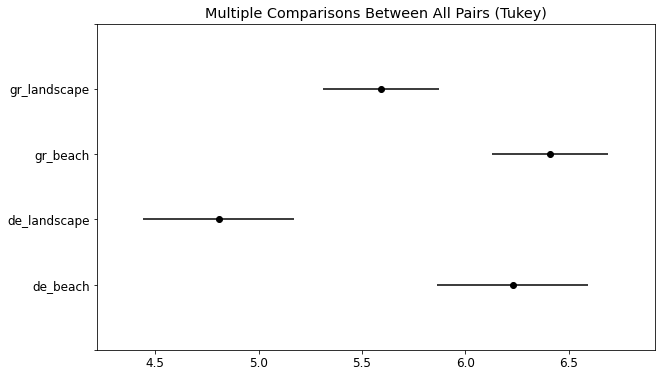

In [63]:
de_landscape = df_hyp_4['MOS'][df_hyp_4['Aufwachsort'] == 'de'][df_hyp_4['Umgebung'] == 'landscape']
gr_landscape = df_hyp_4['MOS'][df_hyp_4['Aufwachsort'] == 'gr'][df_hyp_4['Umgebung'] == 'landscape']
de_beach = df_hyp_4['MOS'][df_hyp_4['Aufwachsort'] == 'de'][df_hyp_4['Umgebung'] == 'beach']
gr_beach = df_hyp_4['MOS'][df_hyp_4['Aufwachsort'] == 'gr'][df_hyp_4['Umgebung'] == 'beach']
de_landscape = list(de_landscape)
gr_landscape = list(gr_landscape)
de_beach = list(de_beach)
gr_beach = list(gr_beach)
groupData = de_landscape + gr_landscape + de_beach + gr_beach
groupData=np.array(groupData)
repetitions_de = len(de_landscape)
repetitions_gr = len(gr_beach)
assert(len(de_landscape)==len(de_beach))
assert(len(gr_landscape)==len(gr_beach))
groupNames = np.array(['de_landscape']*repetitions_de + ['gr_landscape']*repetitions_gr + ['de_beach']* repetitions_de + ['gr_beach']*repetitions_gr)
tukey = pairwise_tukeyhsd(groupData,groupNames)
print(tukey.summary())
tukey.plot_simultaneous()#comparison_name="de_landscape")
# plt.savefig("tukey.jpg",dpi=150)
plt.show()

In [64]:
results_as_html = tukey.summary().as_html()
tukey_res = pd.read_html(results_as_html, header=0, index_col=0)[0]
tukey_res

group2  meandiff   p-adj   lower   upper  reject
group1                                                              
de_beach      de_landscape   -1.4224  0.0010 -2.1474 -0.6975    True
de_beach          gr_beach    0.1806  0.8799 -0.4659  0.8270   False
de_beach      gr_landscape   -0.6354  0.0560 -1.2818  0.0110   False
de_landscape      gr_beach    1.6030  0.0010  0.9566  2.2494    True
de_landscape  gr_landscape    0.7870  0.0099  0.1406  1.4335    True
gr_beach      gr_landscape   -0.8160  0.0011 -1.3729 -0.2590    True

In [65]:
np.array(tukey_res['meandiff'])

array([-1.4224,  0.1806, -0.6354,  1.603 ,  0.787 , -0.816 ])

{'mean_beach': MOS    6.31936
dtype: float64, 'mean_landscape': MOS    5.200154
dtype: float64, 'mean_de': MOS    5.517857
dtype: float64, 'mean_gr': MOS    6.001657
dtype: float64}
{'gr_beach': MOS    6.409639
dtype: float64, 'gr_landscape': MOS    5.593675
dtype: float64, 'de_beach': MOS    6.229082
dtype: float64, 'de_landscape': MOS    4.806633
dtype: float64}


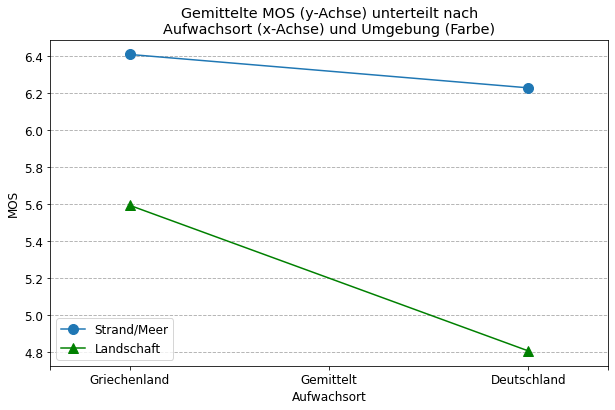

In [66]:
fig = plt.figure(figsize=(10,6))
# print((df_hyp_4['Umgebung']=='beach') & (df_hyp_4['Aufwachsort']=='gr'))
# asdf = df_hyp_4.loc[(df_hyp_4['Umgebung']=='beach') & (df_hyp_4['Aufwachsort']=='de')].mean()
# print(asdf)

hyp_4_data = {
    'gr_beach' : df_hyp_4.loc[(df_hyp_4['Umgebung']=='beach') & (df_hyp_4['Aufwachsort']=='gr')].mean(),
    'gr_landscape' : df_hyp_4.loc[(df_hyp_4['Umgebung']=='landscape') & (df_hyp_4['Aufwachsort']=='gr')].mean(),
    'de_beach' : df_hyp_4.loc[(df_hyp_4['Umgebung']=='beach') & (df_hyp_4['Aufwachsort']=='de')].mean(),
    'de_landscape' : df_hyp_4.loc[(df_hyp_4['Umgebung']=='landscape') & (df_hyp_4['Aufwachsort']=='de')].mean()
}
mean_labels = ['Griechenland','Deutschland']

# plt.plot('',5)
beachPlot = plt.plot([1,1.5], [hyp_4_data['gr_beach'],hyp_4_data['de_beach']], marker='o', markersize=10, zorder=10, label="Strand/Meer")
landscapePlot = plt.plot([1,1.5], [hyp_4_data['gr_landscape'],hyp_4_data['de_landscape']], marker='^', markersize=10, zorder=10, color='green', label="Landschaft")
# plt.plot('',6)
hyp_4_means = {
    'mean_beach' : (hyp_4_data['gr_beach'] + hyp_4_data['de_beach'])/2,
    'mean_landscape' : (hyp_4_data['gr_landscape'] + hyp_4_data['de_landscape'])/2,
    'mean_de' : (hyp_4_data['de_beach'] + hyp_4_data['de_landscape'])/2,
    'mean_gr' : (hyp_4_data['gr_beach'] + hyp_4_data['gr_landscape'])/2,
}
# mean_beach = (hyp_4_data['gr_beach'] + hyp_4_data['de_beach'])/2
# mean_landscape = (hyp_4_data['gr_landscape'] + hyp_4_data['de_landscape'])/2
# mean_de = (hyp_4_data['de_beach'] + hyp_4_data['de_landscape'])/2
# mean_gr = (hyp_4_data['gr_beach'] + hyp_4_data['gr_landscape'])/2
print(hyp_4_means)

# meanBeachPlot = plt.plot(1.25,mean_beach,marker='X', color='darkblue', markersize=12, zorder=10, label=r"$MOS(P_{Alle}, B_{Strand/Meer})$")
# meanLandscapePlot = plt.plot(1.25,mean_landscape,marker='X', color='darkgreen', markersize=12, zorder=10, label=r"$MOS(P_{Alle}, B_{Landschaft})$")

# meanDePlot = plt.plot(1.5,mean_de,marker='X', color='red', markersize=12, zorder=10, label=r"$MOS(P_{DE}, B_{Alle})$")
# meanDeConnectorPlot = plt.plot([1.5, 1.5], [hyp_4_data['de_beach'],hyp_4_data['de_landscape']], color='grey', ls='--', zorder=8)

# meanGrPlot = plt.plot(1,mean_gr,marker='X', color='red', markersize=12, zorder=10, label=r"$MOS(P_{GR}, B_{Alle})$")
# meanGrConnectorPlot = plt.plot([1, 1], [hyp_4_data['gr_beach'],hyp_4_data['gr_landscape']], color='grey', ls='--', zorder=8)

# plt.xticks([0,1], ['gr','de'])
plt.xticks([0.9,1,1.25,1.5, 1.6],[''] + ['Griechenland'] + ['Gemittelt'] + ['Deutschland'] + [''] )
plt.grid(linestyle='--', linewidth=0.9, axis='y', zorder=0)
plt.ylabel("MOS")
plt.xlabel("Aufwachsort")
plt.legend()
plt.title("Gemittelte MOS (y-Achse) unterteilt nach\nAufwachsort (x-Achse) und Umgebung (Farbe)")
# plt.tight_layout()
# plt.savefig("MOS_Hyp4.jpg", dpi=150, bbox_inches='tight')
print(hyp_4_data)

plt.show()

## Hier kommen diverse Operationen

### Berechnung des schlechtesten Bildes

Worst image id: 48 with MOS 2.765151515151515
Average all MOS: 5.822064393939394
677_Carmen_f6b02e29-8941-4977-9435-3868ae50a52e_[,use,landscape,invisiblesun,noclouds,badquality,].jpeg


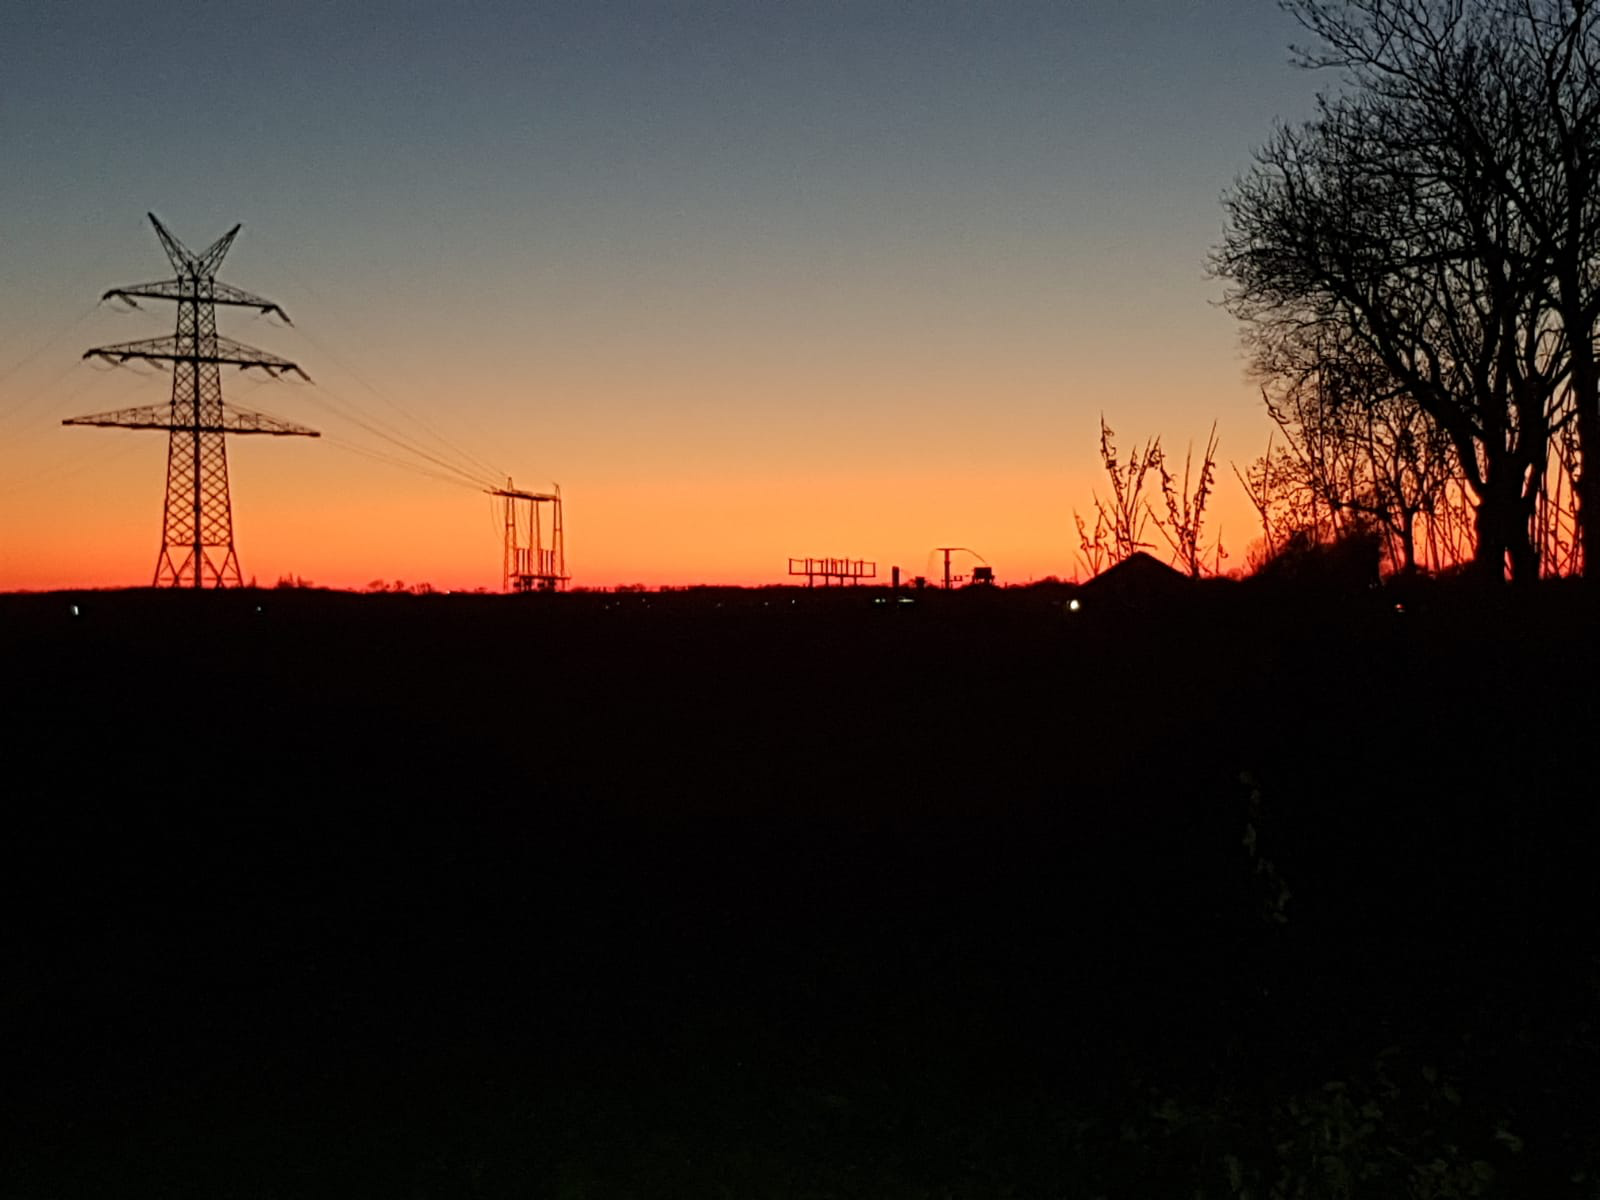

In [67]:
allMOS = [img.getAllAverage() for img in allImgs]
worstIndex = np.argmin(allMOS)
worstImg = allImgs[worstIndex]
print("Worst image id:",worstIndex, "with MOS", allMOS[worstIndex])
print("Average all MOS:", np.average(allMOS))
print(worstImg.name)
worstImg.getImage()

## Erstellung der finalen Info-CSV-Datei für Bildinformationen

In [68]:
#InfoFileCleanup
infoFile = open("clean_infoFile.csv", "r",encoding='utf-8')
header = infoFile.readline()
infoFileLines = infoFile.readlines()
infoFile.close()

In [69]:
maxId = len(infoFileLines)
allImgIds = [img.id for img in allImgs]

In [70]:
existingImgIds = [img_id for img_id in allImgIds if img_id <= maxId]
myImgIds = [img_id for img_id in allImgIds if img_id > maxId]

In [71]:
finalLines = [infoFileLines[img_id] for img_id in existingImgIds]

In [72]:
finalLines

['51,https://live.staticflickr.com/6093/6294882383_498624f097_o.jpg,"sunset",minicooper93402,CC BY 2.0,https://www.flickr.com/photos/minicooper93402/6294882383/\n',
 '104,https://live.staticflickr.com/1509/25993330175_ddb40fe942_o.jpg,"Southern Sunset (EXPLORED)",Thanks for over 2 million views!!,CC BY 2.0,https://www.flickr.com/photos/chad_sparkes/25993330175/\n',
 '117,https://live.staticflickr.com/4074/4768357051_5cd5f41f87_o.jpg,"Aci Trezza Faraglioni Sea Dawn Sunset Sicilia Italy Italia - Creative Commons by gnuckx",gnuckx,CC0 1.0,https://www.flickr.com/photos/gnuckx/4768357051/\n',
 '247,https://live.staticflickr.com/6211/6295413648_40c7e0d865_o.jpg,"sunset",minicooper93402,CC BY 2.0,https://www.flickr.com/photos/minicooper93402/6295413648/\n',
 '654,https://live.staticflickr.com/7520/16173430812_dea2d66443_o.jpg,"Sunset Coucher de soleil - Cap Ferret Bassin d\'Arcachon Ocean Pecheur Fisherman Beach Plage Waves Vagues Water Eau Boat Bateau Oiseau Birds bleu orange Claouey Aquitai

In [73]:
# finalInfoFile = open("finalInfoFile.csv",'w',encoding='utf-8')
# finalInfoFile.write(header)
# for line in finalLines:
#     finalInfoFile.write(line)
# finalInfoFile.close()

In [74]:
print(myImgIds)
len(myImgIds)

[638, 655, 657, 660, 663, 641, 643, 654, 656, 650, 667, 673, 674, 676, 677, 682, 679, 680, 632]


19